In [1]:

from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import applications
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input, Convolution2D, MaxPool2D, Flatten
from keras.models import Model
from keras.layers import Input
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
import os
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
from sklearn.utils import compute_class_weight
from keras.optimizers import Adam
from keras.layers import Dense
# from keras.layers.core import Activation
from keras.layers import Activation
from keras.layers import BatchNormalization
# from keras.layers.convolutional import UpSampling2D
from tensorflow.keras.layers import UpSampling2D
# from keras.layers.core import Flatten
from tensorflow.keras.layers import Flatten
from keras.layers import Input
# from keras.layers.convolutional import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from keras.models import Model
from keras.layers import LeakyReLU, PReLU
from keras.layers import add
from keras.applications.vgg19 import VGG19
import torch
import torch.optim as optim
import torch.nn.functional as F


In [2]:
#Make sure we are running on the
print(torch.cuda.is_available())
# Storing ID of current CUDA device
if torch.cuda.is_available():
  cuda_id = torch.cuda.current_device()
  print(torch.cuda.get_device_name(cuda_id))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

True
NVIDIA GeForce RTX 3060 Ti
cuda


In [3]:
#create custom data generator which inherts from tf.keras.utils.Sequence
#args of the data generator are list of image paths, list of asscoiated labels, batch size, and shuffle
#outout is a tensor of tensors holding a batch of low resoltuion images, 
#a tensor of tensors holding a batch of high resoltuion images, 
#and a list of labels associated
class DataGenerator(tf.keras.utils.Sequence):
    
    def __init__(self, x_in, y_in, batch_size, shuffle):
        #initialize variables
        self.x = x_in
        self.y = y_in
        self.batch_size = batch_size
        self.datalen = len(y_in)
        self.indexes = np.arange(self.datalen)
        self.shuffle = shuffle
        if self.shuffle:
            np.random.shuffle(self.indexes)
        

    def __len__(self):
        return self.datalen // self.batch_size

    def __getitem__(self, idx):
        #create batch of image paths and their labels
        batch_x = self.x[idx*self.batch_size : (idx + 1)*self.batch_size]
        batch_y = self.y[idx*self.batch_size : (idx + 1)*self.batch_size]
        #initialize empty array to hold tensor of images
        low_res_images = []
        high_res_images = []

        #Loop through batch of image paths
        for path_sample in batch_x:
           #grab image from path, set size to 128x128
            img = tf.keras.preprocessing.image.load_img(path_sample, target_size=(128,128))
            #convert image to tensor
            high_res = tf.image.convert_image_dtype(img, tf.float32)
            #resize high resolution image to 32x32 to create low resolution image
            low_res = tf.image.resize(high_res, [32, 32])
            #add images to arrays
            low_res_images.append(low_res)
            high_res_images.append(high_res)
        
        #convert array of image tensors to a tensor of tensors
        low_res_images = tf.stack(low_res_images)
        high_res_images = tf.stack(high_res_images)
        return low_res_images, high_res_images, batch_y

In [4]:
from pathlib import Path

In [5]:
#define directories
train_dir = Path ('D:/UNCC/Fall_23/ECGR_8119/hw_1/dogs_vs_cats/splitdata_midterm/train')
test_dir   = Path ('D:/UNCC/Fall_23/ECGR_8119/hw_1/dogs_vs_cats/splitdata_midterm/val')

#define class names
classes = ['cat', 'dog']

# create lists to store the file paths and labels
train_files = []
train_labels = []
test_files = []
test_labels = []

# loop through the two classes to get the file paths and labels for train, val and test sets
for class_name in classes:
    train_class_dir = os.path.join(train_dir, class_name)
    for file in os.listdir(train_class_dir):
        train_files.append(os.path.join(train_class_dir, file))
        train_labels.append(class_name)
    test_class_dir = os.path.join(test_dir, class_name)
    for file in os.listdir(test_class_dir):
        test_files.append(os.path.join(test_class_dir, file))
        test_labels.append(class_name)

# convert the labels to numerical values
label_map = {'cat': 0, 'dog': 1}
train_labels = [label_map[label] for label in train_labels]
test_labels = [label_map[label] for label in test_labels]

In [6]:
#This block is used to shuffle the lists created above
import random

# Combine the lists into a list of tuples
combined1 = list(zip(train_files, train_labels))
combined2 = list(zip(test_files, test_labels))

# Shuffle the list of tuples
random.shuffle(combined1)
random.shuffle(combined2)

# Separate the shuffled list of tuples back into two lists
train_files, train_labels = zip(*combined1)
test_files, test_labels = zip(*combined2)

In [7]:
train_num = len(train_files)
test_num = len(test_files)

#convert labels to multilabel using one-hot encoding
num_classes = 2
train_labels = tf.one_hot(train_labels, num_classes)
test_labels = tf.one_hot(test_labels, num_classes)

In [8]:
#create generators using custom class for training, validation, and testing
train_gen = DataGenerator(train_files, train_labels, batch_size = 75, shuffle=True)
test_gen = DataGenerator(test_files, test_labels, batch_size = 75, shuffle=True)

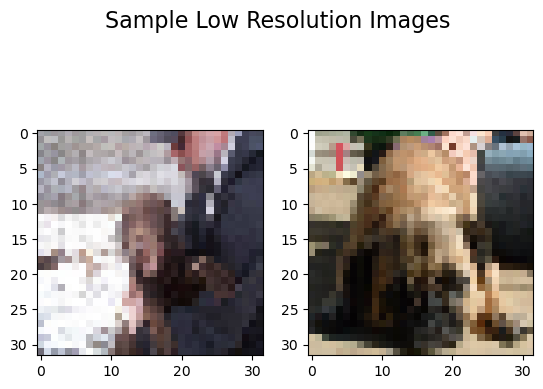

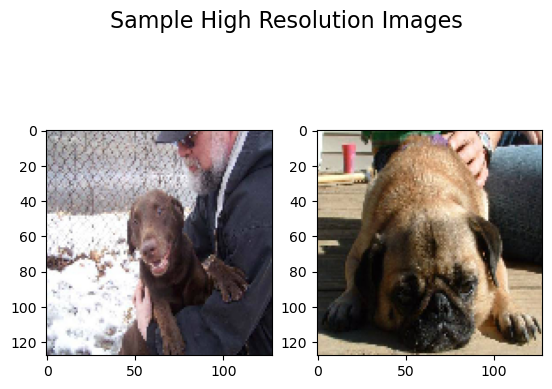

y Labels:  tf.Tensor(
[[0. 1.]
 [0. 1.]], shape=(2, 2), dtype=float32)


In [9]:
#visualize the augmented data
# Get the next batch of images from the train generator
train_low_res_images, train_high_res_images, train_labels = train_gen.__getitem__(0)

#grab the first 8 in the batch and their labels and plot them
for k in range(1,3):
    sample_lr_img = train_low_res_images[k,:,:,:]
    plt.subplot(1, 2, k)
    plt.imshow(sample_lr_img)
plt.suptitle('Sample Low Resolution Images', fontsize = 16)    
plt.show()

for k in range(1,3):
    sample_hr_img = train_high_res_images[k,:,:,:]
    plt.subplot(1, 2, k)
    plt.imshow(sample_hr_img)
plt.suptitle('Sample High Resolution Images', fontsize = 16)    
plt.show()

print('y Labels: ', train_labels[1:3])

In [10]:
# Residual block
def res_block_gen(model, kernal_size, filters, strides):
    
    gen = model
    
    model = Conv2D(filters = filters, kernel_size = kernal_size, strides = strides, padding = "same")(model)
    model = BatchNormalization(momentum = 0.5)(model)
    # Using Parametric ReLU
    model = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=[1,2])(model)
    model = Conv2D(filters = filters, kernel_size = kernal_size, strides = strides, padding = "same")(model)
    model = BatchNormalization(momentum = 0.5)(model)
        
    model = add([gen, model])
    
    return model

In [11]:
def discriminator_block(model, filters, kernel_size, strides):
    
    model = Conv2D(filters = filters, kernel_size = kernel_size, strides = strides, padding = "same")(model)
    model = BatchNormalization(momentum = 0.5)(model)
    model = LeakyReLU(alpha = 0.2)(model)
    
    return model

In [12]:
def up_sampling_block(model, kernal_size, filters, strides):
    
    model = Conv2D(filters = filters, kernel_size = kernal_size, strides = strides, padding = "same")(model)
    model = UpSampling2D(size = 2)(model)
    model = LeakyReLU(alpha = 0.2)(model)
    
    return model 

In [13]:
class Generator(object):

    def __init__(self, noise_shape):
        self.noise_shape = noise_shape
        
    def generator(self):
        gen_input = Input(shape = self.noise_shape)
			
        model = Conv2D(filters=64, kernel_size=9, strides=1, padding="same")(gen_input)
        model = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=[1,2])(model)
				
        gen_model = model

        # Using 16 Residual Blocks
        for index in range(16):
            model = res_block_gen(model, 3, 64, 1)
        
        model = Conv2D(filters=64, kernel_size=3, strides=1, padding="same")(model)
        model = BatchNormalization(momentum=0.5)(model)
        model = add([gen_model, model])
        
        # Using 2 UpSampling Blocks
        for index in range(2):
            model = up_sampling_block(model, 3, 256, 1)
        
        model = Conv2D(filters=3, kernel_size=9, strides=1, padding="same")(model)
        model = Activation('tanh')(model)
       
        generator_model = Model(inputs=gen_input, outputs=model)
        
        return generator_model

In [14]:
class Discriminator(object):

    def __init__(self, image_shape):
        
        self.image_shape = image_shape
    
    def discriminator(self):
        
        dis_input = Input(shape = self.image_shape)
        
        model = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = "same")(dis_input)
        model = LeakyReLU(alpha = 0.2)(model)
        
        model = discriminator_block(model, 64, 3, 2)
        model = discriminator_block(model, 128, 3, 1)
        model = discriminator_block(model, 128, 3, 2)
        model = discriminator_block(model, 256, 3, 1)
        model = discriminator_block(model, 256, 3, 2)
        model = discriminator_block(model, 512, 3, 1)
        model = discriminator_block(model, 512, 3, 2)
        
        model = Flatten()(model)
        model = Dense(1024)(model)
        model = LeakyReLU(alpha = 0.2)(model)
       
        model = Dense(1)(model)
        model = Activation('sigmoid')(model) 
        
        discriminator_model = Model(inputs = dis_input, outputs = model)
        
        return discriminator_model

In [15]:
#combines discriminator and generator to be one model
def get_SRgan_network(discriminator, shape, generator, optimizer, vgg_loss):
    discriminator.trainable = False
    gan_input = Input(shape=shape)
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=[x,gan_output])
    gan.compile(loss=[vgg_loss, "binary_crossentropy"],
                loss_weights=[1., 1e-3],
                optimizer=optimizer)

    return gan

In [16]:
class VGGLoss(tf.keras.Model):
    def __init__(self, feature_layer=36):
        super(VGGLoss, self).__init__()
        self.vgg = VGG19(include_top=False, input_shape=(None, None, 3))
        self.vgg.trainable = False
        self.feature_layer = feature_layer
        self.loss = tf.keras.losses.MeanSquaredError()

    def call(self, x, y):
        # Use the VGG feature extractor to compute features
        x_features = self.vgg(x)
        y_features = self.vgg(y)

        # Compute the feature difference between the generated and target images
        x_features = tf.stop_gradient(x_features)
        y_features = tf.stop_gradient(y_features)
        loss = self.loss(x_features, y_features)

        return loss

In [17]:
import tensorflow.keras.backend as K

def dis_loss_fn(real_pred, fake_pred):
    real_loss = K.binary_crossentropy(tf.ones_like(real_pred), real_pred)
    fake_loss = K.binary_crossentropy(tf.zeros_like(fake_pred), fake_pred)
    d_loss = real_loss + fake_loss
    return d_loss

In [18]:
from PIL import Image
import os
from contextlib import redirect_stdout
import sys
from tqdm import tqdm
original_stdout = sys.stdout

def train(epochs, batch_size, output_dir, model_save_dir, generator, discriminator, train_dataloader, val_dataloader, generator_optimizer, discriminator_optimizer, generator_loss_fn, discriminator_loss_fn):
     
    loss = VGGLoss(image_shape)

    for e in range(epochs):
      train_bar_desc = f"Epoch {e+1} Training"
      running_train_generator_loss = 0.0
      running_train_discriminator_loss = 0.0
      running_val_generator_loss = 0.0
      running_val_discriminator_loss = 0.0

      for batch_idx, (low_res_images, high_res_images, labels) in enumerate(tqdm(train_dataloader, desc=train_bar_desc)):         
            generator.trainable = True
            #generate prediction
            generated_images_sr = generator.predict(low_res_images)
            
            #compute discriminator Loss
            real_data_Y = np.ones(batch_size) - np.random.random_sample(batch_size)*0.2
            fake_data_Y = np.random.random_sample(batch_size)*0.2
            
            discriminator.trainable = True
            sys.stdout = open(os.devnull, 'w')
            d_loss_real = discriminator.train_on_batch(high_res_images, real_data_Y)
            d_loss_fake = discriminator.train_on_batch(generated_images_sr, fake_data_Y)
            sys.stdout = original_stdout
            discriminator_loss = 0.5 * np.add(d_loss_fake, d_loss_real)

            #gen loss
            gan_Y = np.ones(batch_size) - np.random.random_sample(batch_size)*0.2

            discriminator.trainable = False

            sys.stdout = open(os.devnull, 'w')
            gan_loss = gan.train_on_batch(low_res_images, [high_res_images,gan_Y])
            sys.stdout = original_stdout

            running_train_generator_loss += sum(gan_loss)
            #running_train_discriminator_loss += sum(discriminator_loss.numpy())
            running_train_discriminator_loss += discriminator_loss

      # for batch_idx, (low_res_images, high_res_images, labels) in enumerate(val_dataloader):
      #     # Compute generator and discriminator loss
      #     generated_images = generator(low_res_images)

      #     real_scores = discriminator(high_res_images, training=False)
      #     fake_scores = discriminator(generated_images, training=False)

      #     discriminator_loss = discriminator_loss_fn(real_scores, fake_scores)

      #     #gen loss
      #     gan_Y = np.ones(batch_size) - np.random.random_sample(batch_size)*0.2

      #     sys.stdout = open(os.devnull, 'w')
      #     gan_loss = gan.train_on_batch(low_res_images, [high_res_images,gan_Y])
      #     sys.stdout = original_stdout

      #     # Keep track of validation losses and accuracy
      #     running_val_generator_loss += sum(gan_loss)
      #     running_val_discriminator_loss += sum(discriminator_loss.numpy())

      train_generator_loss = running_train_generator_loss / len(train_dataloader)
      train_discriminator_loss = running_train_discriminator_loss / len(train_dataloader)
      #val_generator_loss = running_val_generator_loss / len(val_dataloader)
      #val_discriminator_loss = running_val_discriminator_loss / len(val_dataloader)
      # Print losses and accuracy for this epoch

      #print(f"Epoch {e+1}: Train Gen Loss: {str(train_generator_loss)}, Train Disc Loss: {str(train_discriminator_loss)}, Val Gen Loss: {str(val_generator_loss)}, Val Disc Loss: {str(val_discriminator_loss)}")
      print(f"Epoch {e+1}: Train Gen Loss: {str(train_generator_loss)}, Train Disc Loss: {str(train_discriminator_loss)}")

      if e % 10 == 0:
          generator.save(model_save_dir + 'gen_model%d.h5' % e)
          # Get a random low-res image from the validation dataset
          idx = np.random.randint(len(val_dataloader))
          low_res_image, high_res_image, _ = val_dataloader[idx]
          low_res_image = low_res_image[0]
          high_res_image = high_res_image[0]

          # Generate a high-res image from the low-res input
          generated_image = generator.predict(np.expand_dims(low_res_image, axis=0))[0]

          # Create a figure with three subplots
          fig, axs = plt.subplots(1, 3, figsize=(10, 5))

          # Show the low-res image in the first subplot
          axs[0].imshow(low_res_image)
          axs[0].set_title(f"Resolution: {low_res_image.shape[0]}x{low_res_image.shape[1]}")

          # Show the high-res image in the second subplot
          axs[1].imshow(high_res_image)
          axs[1].set_title(f"Resolution: {high_res_image.shape[0]}x{high_res_image.shape[1]}")

          # Show the generated image in the third subplot
          axs[2].imshow(generated_image)
          axs[2].set_title(f"Resolution: {generated_image.shape[0]}x{generated_image.shape[1]}")

          plt.show()

          # Save the figure to a file
          #plt.savefig(os.path.join(output_dir, f'epoch{e}_sample{e}.png'))

In [19]:
epochs = 150

batch_size = 75
shape = (32,32,3)
image_shape = (128,128,3)

gen_loss_fn = VGGLoss(image_shape)

generator = Generator(shape).generator()
discriminator = Discriminator(image_shape).discriminator()

# Define the optimizer
gen_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
disc_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

generator.compile(loss=gen_loss_fn.call, optimizer=gen_optimizer)
discriminator.compile(loss="binary_crossentropy", optimizer=disc_optimizer)

gan = get_SRgan_network(discriminator, shape, generator, gen_optimizer, gen_loss_fn.call)


output_dir = "D:/UNCC/Fall_23/ECGR_8119/mid_term/srImages"
model_save_dir = 'D:/UNCC/Fall_23/ECGR_8119/mid_term/midtermModels'

In [20]:
# import os

# output_dir = "D:/UNCC/Fall_23/ECGR_8119/mid_term/srImages"
# model_save_dir = 'D:/UNCC/Fall_23/ECGR_8119/mid_term/midtermModels'
# os.path.isdir(model_save_dir)

# os.path.isdir(output_dir)

# if os.path.exists(output_dir):
#     print("it works")

# else:
#     print(f"The directory '{model_save_dir}' does not exist or cannot be accessed.")

Epoch 1 Training:   0%|          | 0/233 [00:00<?, ?it/s]

3/3 [==============================] - 9s 2s/step


Epoch 1 Training:   0%|          | 1/233 [01:37<6:17:44, 97.69s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:   1%|          | 2/233 [03:02<5:46:38, 90.04s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:   1%|▏         | 3/233 [04:20<5:24:25, 84.63s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:   2%|▏         | 4/233 [05:35<5:09:05, 80.99s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:   2%|▏         | 5/233 [06:50<4:59:34, 78.83s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:   3%|▎         | 6/233 [08:06<4:54:20, 77.80s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:   3%|▎         | 7/233 [09:23<4:51:14, 77.32s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:   3%|▎         | 8/233 [10:38<4:47:26, 76.65s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:   4%|▍         | 9/233 [11:55<4:47:20, 76.97s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:   4%|▍         | 10/233 [13:11<4:43:55, 76.39s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:   5%|▍         | 11/233 [14:26<4:41:44, 76.15s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:   5%|▌         | 12/233 [15:41<4:39:07, 75.78s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:   6%|▌         | 13/233 [16:56<4:37:01, 75.55s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:   6%|▌         | 14/233 [18:11<4:35:15, 75.41s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:   6%|▋         | 15/233 [19:26<4:33:32, 75.29s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:   7%|▋         | 16/233 [20:41<4:31:51, 75.17s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:   7%|▋         | 17/233 [21:56<4:30:20, 75.09s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:   8%|▊         | 18/233 [23:11<4:28:48, 75.02s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:   8%|▊         | 19/233 [24:26<4:28:09, 75.18s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:   9%|▊         | 20/233 [25:42<4:26:47, 75.15s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:   9%|▉         | 21/233 [26:57<4:25:34, 75.16s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:   9%|▉         | 22/233 [28:12<4:24:21, 75.17s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  10%|▉         | 23/233 [29:27<4:22:59, 75.14s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  10%|█         | 24/233 [30:42<4:21:35, 75.10s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  11%|█         | 25/233 [31:57<4:20:24, 75.12s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  11%|█         | 26/233 [33:12<4:19:13, 75.14s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  12%|█▏        | 27/233 [34:27<4:17:46, 75.08s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  12%|█▏        | 28/233 [35:42<4:16:32, 75.09s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  12%|█▏        | 29/233 [36:58<4:15:26, 75.13s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  13%|█▎        | 30/233 [38:12<4:13:49, 75.02s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  13%|█▎        | 31/233 [39:28<4:13:11, 75.20s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  14%|█▎        | 32/233 [40:43<4:11:49, 75.17s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  14%|█▍        | 33/233 [41:58<4:10:28, 75.14s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  15%|█▍        | 34/233 [43:13<4:09:19, 75.17s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  15%|█▌        | 35/233 [44:29<4:08:21, 75.26s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  15%|█▌        | 36/233 [45:44<4:07:12, 75.29s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  16%|█▌        | 37/233 [47:00<4:06:03, 75.33s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  16%|█▋        | 38/233 [48:15<4:05:16, 75.47s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  17%|█▋        | 39/233 [49:31<4:03:47, 75.40s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  17%|█▋        | 40/233 [50:46<4:02:24, 75.36s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  18%|█▊        | 41/233 [52:01<4:01:07, 75.35s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  18%|█▊        | 42/233 [53:17<3:59:49, 75.34s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  18%|█▊        | 43/233 [54:32<3:58:33, 75.34s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  19%|█▉        | 44/233 [55:48<3:57:34, 75.42s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  19%|█▉        | 45/233 [57:03<3:56:21, 75.43s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  20%|█▉        | 46/233 [58:18<3:55:02, 75.41s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  20%|██        | 47/233 [59:34<3:53:50, 75.43s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  21%|██        | 48/233 [1:00:49<3:52:30, 75.41s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  21%|██        | 49/233 [1:02:05<3:51:17, 75.42s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  21%|██▏       | 50/233 [1:03:20<3:50:13, 75.49s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  22%|██▏       | 51/233 [1:04:36<3:48:48, 75.43s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  22%|██▏       | 52/233 [1:05:51<3:47:18, 75.35s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  23%|██▎       | 53/233 [1:07:06<3:46:07, 75.38s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  23%|██▎       | 54/233 [1:08:22<3:45:00, 75.42s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  24%|██▎       | 55/233 [1:09:37<3:43:37, 75.38s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  24%|██▍       | 56/233 [1:10:52<3:42:20, 75.37s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  24%|██▍       | 57/233 [1:12:08<3:41:30, 75.51s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  25%|██▍       | 58/233 [1:13:24<3:40:13, 75.51s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  25%|██▌       | 59/233 [1:14:39<3:39:02, 75.53s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  26%|██▌       | 60/233 [1:15:55<3:37:31, 75.44s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  26%|██▌       | 61/233 [1:17:10<3:35:53, 75.31s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  27%|██▋       | 62/233 [1:18:25<3:34:21, 75.21s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  27%|██▋       | 63/233 [1:19:40<3:32:54, 75.15s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  27%|██▋       | 64/233 [1:20:55<3:31:39, 75.14s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  28%|██▊       | 65/233 [1:22:10<3:30:30, 75.18s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  28%|██▊       | 66/233 [1:23:25<3:29:26, 75.25s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  29%|██▉       | 67/233 [1:24:41<3:28:08, 75.23s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  29%|██▉       | 68/233 [1:25:57<3:27:38, 75.51s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  30%|██▉       | 69/233 [1:27:12<3:26:09, 75.42s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  30%|███       | 70/233 [1:28:27<3:25:01, 75.47s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  30%|███       | 71/233 [1:29:43<3:23:51, 75.51s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  31%|███       | 72/233 [1:30:58<3:22:28, 75.46s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  31%|███▏      | 73/233 [1:32:14<3:21:19, 75.50s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  32%|███▏      | 74/233 [1:33:30<3:20:11, 75.55s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  32%|███▏      | 75/233 [1:34:45<3:18:57, 75.55s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  33%|███▎      | 76/233 [1:36:01<3:17:56, 75.65s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  33%|███▎      | 77/233 [1:37:16<3:16:25, 75.55s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  33%|███▎      | 78/233 [1:38:32<3:15:01, 75.50s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  34%|███▍      | 79/233 [1:39:48<3:14:01, 75.59s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  34%|███▍      | 80/233 [1:41:04<3:13:35, 75.92s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  35%|███▍      | 81/233 [1:42:20<3:12:06, 75.83s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  35%|███▌      | 82/233 [1:43:36<3:10:54, 75.86s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  36%|███▌      | 83/233 [1:44:51<3:09:18, 75.72s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  36%|███▌      | 84/233 [1:46:07<3:07:49, 75.63s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  36%|███▋      | 85/233 [1:47:22<3:06:35, 75.65s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  37%|███▋      | 86/233 [1:48:38<3:05:41, 75.80s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  37%|███▋      | 87/233 [1:49:54<3:04:18, 75.74s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  38%|███▊      | 88/233 [1:51:10<3:02:54, 75.69s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  38%|███▊      | 89/233 [1:52:25<3:01:31, 75.63s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  39%|███▊      | 90/233 [1:53:41<3:00:02, 75.54s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  39%|███▉      | 91/233 [1:54:56<2:58:46, 75.54s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  39%|███▉      | 92/233 [1:56:12<2:58:04, 75.78s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  40%|███▉      | 93/233 [1:57:28<2:56:53, 75.81s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  40%|████      | 94/233 [1:58:44<2:55:24, 75.72s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  41%|████      | 95/233 [2:00:00<2:54:12, 75.74s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  41%|████      | 96/233 [2:01:15<2:52:48, 75.68s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  42%|████▏     | 97/233 [2:02:31<2:51:26, 75.63s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  42%|████▏     | 98/233 [2:03:47<2:50:22, 75.72s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  42%|████▏     | 99/233 [2:05:02<2:48:58, 75.66s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  43%|████▎     | 100/233 [2:06:18<2:47:44, 75.67s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  43%|████▎     | 101/233 [2:07:33<2:46:27, 75.66s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  44%|████▍     | 102/233 [2:08:49<2:45:00, 75.58s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  44%|████▍     | 103/233 [2:10:04<2:43:40, 75.54s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  45%|████▍     | 104/233 [2:11:20<2:42:50, 75.74s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  45%|████▌     | 105/233 [2:12:36<2:41:36, 75.76s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  45%|████▌     | 106/233 [2:13:52<2:40:03, 75.61s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  46%|████▌     | 107/233 [2:15:07<2:38:43, 75.58s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  46%|████▋     | 108/233 [2:16:23<2:37:38, 75.67s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  47%|████▋     | 109/233 [2:17:39<2:36:25, 75.69s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  47%|████▋     | 110/233 [2:18:54<2:35:05, 75.65s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  48%|████▊     | 111/233 [2:20:10<2:33:52, 75.67s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  48%|████▊     | 112/233 [2:21:25<2:32:27, 75.60s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  48%|████▊     | 113/233 [2:22:41<2:31:19, 75.66s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  49%|████▉     | 114/233 [2:23:56<2:29:43, 75.49s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  49%|████▉     | 115/233 [2:25:11<2:28:18, 75.41s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  50%|████▉     | 116/233 [2:26:27<2:27:14, 75.51s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  50%|█████     | 117/233 [2:27:43<2:25:52, 75.45s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  51%|█████     | 118/233 [2:28:58<2:24:28, 75.38s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  51%|█████     | 119/233 [2:30:13<2:23:14, 75.39s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  52%|█████▏    | 120/233 [2:31:29<2:22:05, 75.44s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  52%|█████▏    | 121/233 [2:32:44<2:20:49, 75.44s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  52%|█████▏    | 122/233 [2:34:01<2:20:31, 75.96s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  53%|█████▎    | 123/233 [2:35:18<2:19:30, 76.09s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  53%|█████▎    | 124/233 [2:36:34<2:18:33, 76.27s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  54%|█████▎    | 125/233 [2:37:49<2:16:20, 75.74s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  54%|█████▍    | 126/233 [2:39:03<2:14:24, 75.37s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  55%|█████▍    | 127/233 [2:40:19<2:13:16, 75.44s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  55%|█████▍    | 128/233 [2:41:34<2:11:56, 75.40s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  55%|█████▌    | 129/233 [2:42:50<2:10:43, 75.42s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  56%|█████▌    | 130/233 [2:44:06<2:09:41, 75.55s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  56%|█████▌    | 131/233 [2:45:21<2:08:20, 75.50s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  57%|█████▋    | 132/233 [2:46:37<2:07:07, 75.52s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  57%|█████▋    | 133/233 [2:47:52<2:05:59, 75.60s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  58%|█████▊    | 134/233 [2:49:08<2:04:37, 75.53s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  58%|█████▊    | 135/233 [2:50:24<2:03:46, 75.78s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  58%|█████▊    | 136/233 [2:51:40<2:02:25, 75.73s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  59%|█████▉    | 137/233 [2:52:55<2:00:49, 75.51s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  59%|█████▉    | 138/233 [2:54:10<1:59:17, 75.34s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  60%|█████▉    | 139/233 [2:55:25<1:57:55, 75.27s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  60%|██████    | 140/233 [2:56:40<1:56:36, 75.23s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  61%|██████    | 141/233 [2:57:55<1:55:28, 75.31s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  61%|██████    | 142/233 [2:59:11<1:54:19, 75.37s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  61%|██████▏   | 143/233 [3:00:28<1:54:02, 76.03s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  62%|██████▏   | 144/233 [3:01:44<1:52:22, 75.76s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  62%|██████▏   | 145/233 [3:02:59<1:50:49, 75.57s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  63%|██████▎   | 146/233 [3:04:14<1:49:26, 75.47s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  63%|██████▎   | 147/233 [3:05:30<1:48:22, 75.61s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  64%|██████▎   | 148/233 [3:06:45<1:46:56, 75.49s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  64%|██████▍   | 149/233 [3:08:00<1:45:37, 75.44s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  64%|██████▍   | 150/233 [3:09:16<1:44:26, 75.50s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  65%|██████▍   | 151/233 [3:10:32<1:43:10, 75.49s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  65%|██████▌   | 152/233 [3:11:47<1:41:59, 75.55s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  66%|██████▌   | 153/233 [3:13:03<1:40:49, 75.62s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  66%|██████▌   | 154/233 [3:14:19<1:39:33, 75.61s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  67%|██████▋   | 155/233 [3:15:34<1:38:11, 75.53s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  67%|██████▋   | 156/233 [3:16:49<1:36:46, 75.41s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  67%|██████▋   | 157/233 [3:18:04<1:35:27, 75.37s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  68%|██████▊   | 158/233 [3:19:20<1:34:13, 75.37s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  68%|██████▊   | 159/233 [3:20:35<1:32:58, 75.38s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  69%|██████▊   | 160/233 [3:21:50<1:31:35, 75.28s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  69%|██████▉   | 161/233 [3:23:05<1:30:19, 75.26s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  70%|██████▉   | 162/233 [3:24:21<1:29:07, 75.32s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  70%|██████▉   | 163/233 [3:25:36<1:27:49, 75.28s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  70%|███████   | 164/233 [3:26:51<1:26:34, 75.29s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  71%|███████   | 165/233 [3:28:07<1:25:34, 75.51s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  71%|███████   | 166/233 [3:29:26<1:25:25, 76.50s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  72%|███████▏  | 167/233 [3:30:45<1:24:59, 77.27s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  72%|███████▏  | 168/233 [3:32:04<1:24:19, 77.83s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  73%|███████▎  | 169/233 [3:33:23<1:23:25, 78.21s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  73%|███████▎  | 170/233 [3:34:42<1:22:18, 78.38s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  73%|███████▎  | 171/233 [3:35:59<1:20:32, 77.95s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  74%|███████▍  | 172/233 [3:37:14<1:18:26, 77.15s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  74%|███████▍  | 173/233 [3:38:30<1:16:33, 76.56s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  75%|███████▍  | 174/233 [3:39:45<1:14:54, 76.17s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  75%|███████▌  | 175/233 [3:41:00<1:13:22, 75.90s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  76%|███████▌  | 176/233 [3:42:16<1:12:01, 75.81s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  76%|███████▌  | 177/233 [3:43:31<1:10:42, 75.76s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  76%|███████▋  | 178/233 [3:44:46<1:09:14, 75.54s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  77%|███████▋  | 179/233 [3:46:01<1:07:50, 75.38s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  77%|███████▋  | 180/233 [3:47:17<1:06:30, 75.29s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  78%|███████▊  | 181/233 [3:48:32<1:05:16, 75.31s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  78%|███████▊  | 182/233 [3:49:47<1:04:01, 75.33s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  79%|███████▊  | 183/233 [3:51:04<1:03:05, 75.71s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  79%|███████▉  | 184/233 [3:52:19<1:01:47, 75.66s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  79%|███████▉  | 185/233 [3:53:34<1:00:22, 75.46s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  80%|███████▉  | 186/233 [3:54:49<59:00, 75.33s/it]  

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  80%|████████  | 187/233 [3:56:05<57:46, 75.37s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  81%|████████  | 188/233 [3:57:20<56:26, 75.26s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  81%|████████  | 189/233 [3:58:35<55:11, 75.26s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  82%|████████▏ | 190/233 [3:59:51<53:59, 75.34s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  82%|████████▏ | 191/233 [4:01:06<52:40, 75.24s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  82%|████████▏ | 192/233 [4:02:21<51:24, 75.23s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  83%|████████▎ | 193/233 [4:03:36<50:09, 75.23s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  83%|████████▎ | 194/233 [4:04:52<48:55, 75.28s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  84%|████████▎ | 195/233 [4:06:07<47:39, 75.26s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  84%|████████▍ | 196/233 [4:07:22<46:26, 75.30s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  85%|████████▍ | 197/233 [4:08:37<45:10, 75.29s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  85%|████████▍ | 198/233 [4:09:52<43:51, 75.18s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  85%|████████▌ | 199/233 [4:11:08<42:37, 75.22s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  86%|████████▌ | 200/233 [4:12:23<41:22, 75.22s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  86%|████████▋ | 201/233 [4:13:38<40:03, 75.10s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  87%|████████▋ | 202/233 [4:14:53<38:51, 75.22s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  87%|████████▋ | 203/233 [4:16:09<37:38, 75.29s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  88%|████████▊ | 204/233 [4:17:24<36:20, 75.19s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  88%|████████▊ | 205/233 [4:18:39<35:06, 75.24s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  88%|████████▊ | 206/233 [4:19:55<33:54, 75.36s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  89%|████████▉ | 207/233 [4:21:10<32:38, 75.32s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  89%|████████▉ | 208/233 [4:22:25<31:22, 75.32s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  90%|████████▉ | 209/233 [4:23:41<30:10, 75.44s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  90%|█████████ | 210/233 [4:24:56<28:52, 75.32s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  91%|█████████ | 211/233 [4:26:11<27:36, 75.29s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  91%|█████████ | 212/233 [4:27:26<26:20, 75.26s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  91%|█████████▏| 213/233 [4:28:42<25:04, 75.24s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  92%|█████████▏| 214/233 [4:29:56<23:47, 75.14s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  92%|█████████▏| 215/233 [4:31:12<22:34, 75.25s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  93%|█████████▎| 216/233 [4:32:27<21:17, 75.16s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  93%|█████████▎| 217/233 [4:33:42<20:01, 75.08s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  94%|█████████▎| 218/233 [4:34:57<18:44, 75.00s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  94%|█████████▍| 219/233 [4:36:12<17:31, 75.08s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  94%|█████████▍| 220/233 [4:37:27<16:17, 75.21s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  95%|█████████▍| 221/233 [4:38:42<15:01, 75.13s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  95%|█████████▌| 222/233 [4:39:58<13:47, 75.21s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  96%|█████████▌| 223/233 [4:41:13<12:31, 75.18s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  96%|█████████▌| 224/233 [4:42:28<11:16, 75.16s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  97%|█████████▋| 225/233 [4:43:43<10:01, 75.18s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  97%|█████████▋| 226/233 [4:44:58<08:46, 75.16s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  97%|█████████▋| 227/233 [4:46:13<07:30, 75.12s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  98%|█████████▊| 228/233 [4:47:29<06:16, 75.24s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  98%|█████████▊| 229/233 [4:48:44<05:00, 75.24s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  99%|█████████▊| 230/233 [4:49:59<03:45, 75.23s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training:  99%|█████████▉| 231/233 [4:51:15<02:30, 75.24s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training: 100%|█████████▉| 232/233 [4:52:30<01:15, 75.45s/it]

3/3 [==============================] - 8s 2s/step


Epoch 1 Training: 100%|██████████| 233/233 [4:53:46<00:00, 75.65s/it]
C:\Users\anaconda_navigator\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1: Train Gen Loss: 1.374541569037499, Train Disc Loss: 0.4884951286689406
1/1 [==============================] - 0s 140ms/step


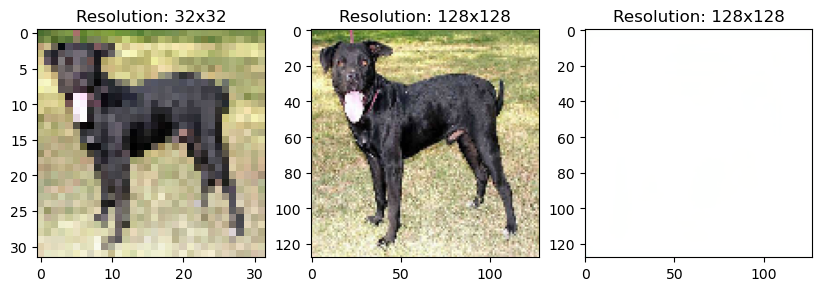

Epoch 2 Training:   0%|          | 0/233 [00:00<?, ?it/s]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:   0%|          | 1/233 [01:15<4:51:21, 75.35s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:   1%|          | 2/233 [02:30<4:50:05, 75.35s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:   1%|▏         | 3/233 [03:46<4:48:52, 75.36s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:   2%|▏         | 4/233 [05:01<4:47:23, 75.30s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:   2%|▏         | 5/233 [06:16<4:46:18, 75.34s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:   3%|▎         | 6/233 [07:55<5:14:56, 83.24s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:   3%|▎         | 7/233 [09:10<5:03:06, 80.47s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:   3%|▎         | 8/233 [10:25<4:55:25, 78.78s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:   4%|▍         | 9/233 [11:40<4:49:39, 77.59s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:   4%|▍         | 10/233 [12:55<4:45:20, 76.77s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:   5%|▍         | 11/233 [14:11<4:43:14, 76.55s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:   5%|▌         | 12/233 [15:26<4:40:12, 76.07s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:   6%|▌         | 13/233 [16:41<4:37:49, 75.77s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:   6%|▌         | 14/233 [17:56<4:35:34, 75.50s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:   6%|▋         | 15/233 [19:10<4:33:19, 75.23s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:   7%|▋         | 16/233 [20:25<4:31:19, 75.02s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:   7%|▋         | 17/233 [21:39<4:29:43, 74.92s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:   8%|▊         | 18/233 [22:54<4:28:30, 74.93s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:   8%|▊         | 19/233 [24:09<4:26:52, 74.83s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:   9%|▊         | 20/233 [25:24<4:25:39, 74.83s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:   9%|▉         | 21/233 [26:39<4:24:32, 74.87s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:   9%|▉         | 22/233 [27:53<4:23:06, 74.82s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  10%|▉         | 23/233 [29:09<4:22:52, 75.11s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  10%|█         | 24/233 [30:24<4:21:28, 75.06s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  11%|█         | 25/233 [31:39<4:19:57, 74.99s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  11%|█         | 26/233 [32:54<4:18:28, 74.92s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  12%|█▏        | 27/233 [34:09<4:17:23, 74.97s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  12%|█▏        | 28/233 [35:24<4:16:01, 74.94s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  12%|█▏        | 29/233 [36:38<4:14:24, 74.83s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  13%|█▎        | 30/233 [37:54<4:13:53, 75.04s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  13%|█▎        | 31/233 [39:09<4:12:19, 74.95s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  14%|█▎        | 32/233 [40:23<4:10:31, 74.78s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  14%|█▍        | 33/233 [41:38<4:09:19, 74.80s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  15%|█▍        | 34/233 [42:53<4:08:11, 74.83s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  15%|█▌        | 35/233 [44:08<4:06:56, 74.83s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  15%|█▌        | 36/233 [45:23<4:06:02, 74.94s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  16%|█▌        | 37/233 [46:38<4:04:55, 74.98s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  16%|█▋        | 38/233 [47:53<4:03:27, 74.91s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  17%|█▋        | 39/233 [49:07<4:02:06, 74.88s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  17%|█▋        | 40/233 [50:22<4:00:56, 74.90s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  18%|█▊        | 41/233 [51:37<3:59:45, 74.93s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  18%|█▊        | 42/233 [52:52<3:58:32, 74.93s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  18%|█▊        | 43/233 [54:07<3:57:19, 74.95s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  19%|█▉        | 44/233 [55:22<3:55:56, 74.90s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  19%|█▉        | 45/233 [56:37<3:54:34, 74.86s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  20%|█▉        | 46/233 [57:52<3:53:33, 74.94s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  20%|██        | 47/233 [59:07<3:52:13, 74.91s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  21%|██        | 48/233 [1:00:22<3:51:28, 75.07s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  21%|██        | 49/233 [1:01:37<3:50:10, 75.06s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  21%|██▏       | 50/233 [1:02:52<3:49:07, 75.12s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  22%|██▏       | 51/233 [1:04:07<3:47:31, 75.01s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  22%|██▏       | 52/233 [1:05:22<3:46:07, 74.96s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  23%|██▎       | 53/233 [1:06:37<3:44:59, 75.00s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  23%|██▎       | 54/233 [1:07:52<3:43:27, 74.90s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  24%|██▎       | 55/233 [1:09:07<3:42:09, 74.89s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  24%|██▍       | 56/233 [1:10:22<3:41:05, 74.95s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  24%|██▍       | 57/233 [1:11:37<3:39:49, 74.94s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  25%|██▍       | 58/233 [1:13:15<3:59:08, 81.99s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  25%|██▌       | 59/233 [1:14:30<3:51:40, 79.89s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  26%|██▌       | 60/233 [1:15:46<3:46:30, 78.56s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  26%|██▌       | 61/233 [1:17:01<3:42:06, 77.48s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  27%|██▋       | 62/233 [1:18:16<3:38:45, 76.76s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  27%|██▋       | 63/233 [1:19:31<3:35:59, 76.23s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  27%|██▋       | 64/233 [1:20:45<3:33:14, 75.71s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  28%|██▊       | 65/233 [1:22:00<3:31:19, 75.47s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  28%|██▊       | 66/233 [1:23:15<3:29:15, 75.18s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  29%|██▉       | 67/233 [1:24:29<3:27:22, 74.95s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  29%|██▉       | 68/233 [1:25:44<3:26:01, 74.92s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  30%|██▉       | 69/233 [1:26:59<3:24:41, 74.89s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  30%|███       | 70/233 [1:28:13<3:23:19, 74.85s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  30%|███       | 71/233 [1:29:28<3:21:57, 74.80s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  31%|███       | 72/233 [1:30:44<3:21:20, 75.03s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  31%|███▏      | 73/233 [1:31:58<3:19:57, 74.98s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  32%|███▏      | 74/233 [1:33:13<3:18:28, 74.90s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  32%|███▏      | 75/233 [1:34:28<3:17:23, 74.96s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  33%|███▎      | 76/233 [1:35:43<3:15:52, 74.86s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  33%|███▎      | 77/233 [1:36:58<3:14:45, 74.91s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  33%|███▎      | 78/233 [1:38:13<3:13:49, 75.03s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  34%|███▍      | 79/233 [1:39:28<3:12:15, 74.91s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  34%|███▍      | 80/233 [1:40:43<3:10:57, 74.88s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  35%|███▍      | 81/233 [1:41:58<3:09:40, 74.87s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  35%|███▌      | 82/233 [1:43:12<3:08:23, 74.86s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  36%|███▌      | 83/233 [1:44:27<3:07:02, 74.81s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  36%|███▌      | 84/233 [1:45:42<3:05:50, 74.83s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  36%|███▋      | 85/233 [1:46:57<3:04:53, 74.96s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  37%|███▋      | 86/233 [1:48:12<3:03:25, 74.87s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  37%|███▋      | 87/233 [1:49:27<3:02:07, 74.85s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  38%|███▊      | 88/233 [1:50:42<3:00:54, 74.86s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  38%|███▊      | 89/233 [1:51:56<2:59:34, 74.82s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  39%|███▊      | 90/233 [1:53:11<2:58:25, 74.86s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  39%|███▉      | 91/233 [1:54:26<2:57:18, 74.92s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  39%|███▉      | 92/233 [1:55:41<2:55:59, 74.89s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  40%|███▉      | 93/233 [1:57:19<3:11:10, 81.93s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  40%|████      | 94/233 [1:58:35<3:05:01, 79.87s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  41%|████      | 95/233 [1:59:49<3:00:15, 78.37s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  41%|████      | 96/233 [2:01:04<2:56:39, 77.37s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  42%|████▏     | 97/233 [2:02:20<2:53:57, 76.75s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  42%|████▏     | 98/233 [2:03:35<2:51:22, 76.16s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  42%|████▏     | 99/233 [2:04:49<2:49:17, 75.80s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  43%|████▎     | 100/233 [2:06:05<2:47:32, 75.58s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  43%|████▎     | 101/233 [2:07:19<2:45:48, 75.37s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  44%|████▍     | 102/233 [2:08:34<2:44:16, 75.24s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  44%|████▍     | 103/233 [2:09:49<2:42:55, 75.19s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  45%|████▍     | 104/233 [2:11:04<2:41:22, 75.06s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  45%|████▌     | 105/233 [2:12:19<2:39:54, 74.96s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  45%|████▌     | 106/233 [2:13:34<2:38:47, 75.02s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  46%|████▌     | 107/233 [2:14:49<2:37:39, 75.07s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  46%|████▋     | 108/233 [2:16:04<2:36:25, 75.09s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  47%|████▋     | 109/233 [2:17:20<2:35:18, 75.15s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  47%|████▋     | 110/233 [2:18:35<2:34:01, 75.13s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  48%|████▊     | 111/233 [2:19:50<2:32:34, 75.04s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  48%|████▊     | 112/233 [2:21:05<2:31:16, 75.01s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  48%|████▊     | 113/233 [2:22:19<2:29:56, 74.97s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  49%|████▉     | 114/233 [2:23:35<2:28:45, 75.00s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  49%|████▉     | 115/233 [2:24:49<2:27:26, 74.97s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  50%|████▉     | 116/233 [2:26:04<2:26:15, 75.00s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  50%|█████     | 117/233 [2:27:19<2:24:46, 74.88s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  51%|█████     | 118/233 [2:28:34<2:23:28, 74.86s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  51%|█████     | 119/233 [2:29:49<2:22:10, 74.82s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  52%|█████▏    | 120/233 [2:31:03<2:20:54, 74.82s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  52%|█████▏    | 121/233 [2:32:19<2:20:08, 75.08s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  52%|█████▏    | 122/233 [2:33:34<2:18:48, 75.03s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  53%|█████▎    | 123/233 [2:34:49<2:17:29, 74.99s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  53%|█████▎    | 124/233 [2:36:04<2:16:11, 74.97s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  54%|█████▎    | 125/233 [2:37:19<2:14:47, 74.88s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  54%|█████▍    | 126/233 [2:38:33<2:13:26, 74.83s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  55%|█████▍    | 127/233 [2:39:48<2:12:04, 74.76s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  55%|█████▍    | 128/233 [2:41:02<2:10:43, 74.70s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  55%|█████▌    | 129/233 [2:42:17<2:09:29, 74.71s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  56%|█████▌    | 130/233 [2:43:32<2:08:12, 74.69s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  56%|█████▌    | 131/233 [2:44:47<2:07:03, 74.74s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  57%|█████▋    | 132/233 [2:46:01<2:05:46, 74.71s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  57%|█████▋    | 133/233 [2:47:17<2:04:49, 74.90s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  58%|█████▊    | 134/233 [2:48:31<2:03:24, 74.79s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  58%|█████▊    | 135/233 [2:49:46<2:02:09, 74.79s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  58%|█████▊    | 136/233 [2:51:01<2:00:50, 74.75s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  59%|█████▉    | 137/233 [2:52:15<1:59:30, 74.70s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  59%|█████▉    | 138/233 [2:53:30<1:58:12, 74.66s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  60%|█████▉    | 139/233 [2:54:44<1:57:00, 74.69s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  60%|██████    | 140/233 [2:55:59<1:55:47, 74.70s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  61%|██████    | 141/233 [2:57:14<1:54:31, 74.69s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  61%|██████    | 142/233 [2:58:29<1:53:30, 74.84s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  61%|██████▏   | 143/233 [2:59:44<1:52:06, 74.73s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  62%|██████▏   | 144/233 [3:00:58<1:50:40, 74.62s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  62%|██████▏   | 145/233 [3:02:13<1:49:30, 74.67s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  63%|██████▎   | 146/233 [3:03:27<1:48:19, 74.71s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  63%|██████▎   | 147/233 [3:04:42<1:46:56, 74.61s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  64%|██████▎   | 148/233 [3:05:57<1:45:48, 74.69s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  64%|██████▍   | 149/233 [3:07:11<1:44:24, 74.57s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  64%|██████▍   | 150/233 [3:08:25<1:43:03, 74.50s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  65%|██████▍   | 151/233 [3:09:40<1:41:54, 74.57s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  65%|██████▌   | 152/233 [3:10:55<1:40:41, 74.58s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  66%|██████▌   | 153/233 [3:12:09<1:39:25, 74.57s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  66%|██████▌   | 154/233 [3:13:24<1:38:21, 74.70s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  67%|██████▋   | 155/233 [3:14:39<1:37:05, 74.68s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  67%|██████▋   | 156/233 [3:15:54<1:35:49, 74.67s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  67%|██████▋   | 157/233 [3:17:08<1:34:34, 74.67s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  68%|██████▊   | 158/233 [3:18:24<1:33:44, 74.99s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  68%|██████▊   | 159/233 [3:19:39<1:32:22, 74.90s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  69%|██████▊   | 160/233 [3:20:53<1:31:05, 74.88s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  69%|██████▉   | 161/233 [3:22:09<1:29:55, 74.94s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  70%|██████▉   | 162/233 [3:23:23<1:28:37, 74.89s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  70%|██████▉   | 163/233 [3:24:38<1:27:14, 74.78s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  70%|███████   | 164/233 [3:25:53<1:26:02, 74.82s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  71%|███████   | 165/233 [3:27:07<1:24:42, 74.74s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  71%|███████   | 166/233 [3:28:22<1:23:30, 74.78s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  72%|███████▏  | 167/233 [3:29:37<1:22:13, 74.75s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  72%|███████▏  | 168/233 [3:30:51<1:20:51, 74.64s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  73%|███████▎  | 169/233 [3:32:06<1:19:38, 74.66s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  73%|███████▎  | 170/233 [3:33:21<1:18:29, 74.76s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  73%|███████▎  | 171/233 [3:34:36<1:17:13, 74.73s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  74%|███████▍  | 172/233 [3:35:50<1:15:54, 74.66s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  74%|███████▍  | 173/233 [3:37:05<1:14:40, 74.67s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  75%|███████▍  | 174/233 [3:38:20<1:13:30, 74.76s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  75%|███████▌  | 175/233 [3:39:34<1:12:08, 74.63s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  76%|███████▌  | 176/233 [3:40:49<1:10:52, 74.61s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  76%|███████▌  | 177/233 [3:42:03<1:09:40, 74.66s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  76%|███████▋  | 178/233 [3:43:18<1:08:21, 74.58s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  77%|███████▋  | 179/233 [3:44:32<1:07:03, 74.51s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  77%|███████▋  | 180/233 [3:45:47<1:05:48, 74.49s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  78%|███████▊  | 181/233 [3:47:01<1:04:35, 74.53s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  78%|███████▊  | 182/233 [3:48:16<1:03:20, 74.51s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  79%|███████▊  | 183/233 [3:49:31<1:02:16, 74.74s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  79%|███████▉  | 184/233 [3:50:46<1:01:00, 74.70s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  79%|███████▉  | 185/233 [3:52:00<59:41, 74.62s/it]  

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  80%|███████▉  | 186/233 [3:53:15<58:25, 74.58s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  80%|████████  | 187/233 [3:54:29<57:11, 74.60s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  81%|████████  | 188/233 [3:55:44<56:02, 74.72s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  81%|████████  | 189/233 [3:56:59<54:44, 74.66s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  82%|████████▏ | 190/233 [3:58:13<53:31, 74.68s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  82%|████████▏ | 191/233 [3:59:28<52:10, 74.54s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  82%|████████▏ | 192/233 [4:00:42<50:58, 74.60s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  83%|████████▎ | 193/233 [4:01:57<49:47, 74.68s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  83%|████████▎ | 194/233 [4:03:12<48:33, 74.69s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  84%|████████▎ | 195/233 [4:04:27<47:23, 74.83s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  84%|████████▍ | 196/233 [4:05:42<46:10, 74.88s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  85%|████████▍ | 197/233 [4:06:57<44:55, 74.89s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  85%|████████▍ | 198/233 [4:08:12<43:37, 74.79s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  85%|████████▌ | 199/233 [4:09:26<42:23, 74.81s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  86%|████████▌ | 200/233 [4:10:41<41:11, 74.89s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  86%|████████▋ | 201/233 [4:11:56<39:53, 74.79s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  87%|████████▋ | 202/233 [4:13:11<38:38, 74.80s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  87%|████████▋ | 203/233 [4:14:26<37:25, 74.84s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  88%|████████▊ | 204/233 [4:15:40<36:06, 74.71s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  88%|████████▊ | 205/233 [4:16:55<34:52, 74.72s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  88%|████████▊ | 206/233 [4:18:10<33:39, 74.80s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  89%|████████▉ | 207/233 [4:19:25<32:22, 74.73s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  89%|████████▉ | 208/233 [4:20:39<31:08, 74.73s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  90%|████████▉ | 209/233 [4:21:54<29:53, 74.74s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  90%|█████████ | 210/233 [4:23:09<28:39, 74.74s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  91%|█████████ | 211/233 [4:24:24<27:24, 74.74s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  91%|█████████ | 212/233 [4:25:39<26:12, 74.87s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  91%|█████████▏| 213/233 [4:26:53<24:56, 74.80s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  92%|█████████▏| 214/233 [4:28:08<23:41, 74.81s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  92%|█████████▏| 215/233 [4:29:23<22:25, 74.73s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  93%|█████████▎| 216/233 [4:30:37<21:09, 74.68s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  93%|█████████▎| 217/233 [4:31:52<19:53, 74.62s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  94%|█████████▎| 218/233 [4:33:06<18:39, 74.64s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  94%|█████████▍| 219/233 [4:34:21<17:25, 74.67s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  94%|█████████▍| 220/233 [4:35:36<16:13, 74.88s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  95%|█████████▍| 221/233 [4:36:51<14:57, 74.82s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  95%|█████████▌| 222/233 [4:38:06<13:42, 74.74s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  96%|█████████▌| 223/233 [4:39:20<12:27, 74.73s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  96%|█████████▌| 224/233 [4:40:35<11:11, 74.65s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  97%|█████████▋| 225/233 [4:41:49<09:56, 74.61s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  97%|█████████▋| 226/233 [4:43:04<08:41, 74.56s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  97%|█████████▋| 227/233 [4:44:18<07:27, 74.52s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  98%|█████████▊| 228/233 [4:45:33<06:12, 74.52s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  98%|█████████▊| 229/233 [4:46:48<04:58, 74.59s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  99%|█████████▊| 230/233 [4:48:02<03:43, 74.56s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training:  99%|█████████▉| 231/233 [4:49:17<02:29, 74.54s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training: 100%|█████████▉| 232/233 [4:50:32<01:14, 74.84s/it]

3/3 [==============================] - 8s 2s/step


Epoch 2 Training: 100%|██████████| 233/233 [4:51:47<00:00, 75.14s/it]


Epoch 2: Train Gen Loss: 1.038408973921778, Train Disc Loss: 0.3315669946020765


Epoch 3 Training:   0%|          | 0/233 [00:00<?, ?it/s]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:   0%|          | 1/233 [01:14<4:48:23, 74.58s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:   1%|          | 2/233 [02:29<4:47:57, 74.79s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:   1%|▏         | 3/233 [03:44<4:46:19, 74.69s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:   2%|▏         | 4/233 [04:58<4:45:00, 74.67s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:   2%|▏         | 5/233 [06:14<4:44:40, 74.92s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:   3%|▎         | 6/233 [07:28<4:43:11, 74.85s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:   3%|▎         | 7/233 [08:43<4:41:09, 74.65s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:   3%|▎         | 8/233 [09:57<4:39:42, 74.59s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:   4%|▍         | 9/233 [11:11<4:38:10, 74.51s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:   4%|▍         | 10/233 [12:26<4:36:42, 74.45s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:   5%|▍         | 11/233 [13:40<4:35:32, 74.47s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:   5%|▌         | 12/233 [14:55<4:34:27, 74.51s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:   6%|▌         | 13/233 [16:09<4:33:08, 74.49s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:   6%|▌         | 14/233 [17:24<4:32:06, 74.55s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:   6%|▋         | 15/233 [18:38<4:30:46, 74.52s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:   7%|▋         | 16/233 [19:53<4:29:14, 74.44s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:   7%|▋         | 17/233 [21:07<4:28:21, 74.54s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:   8%|▊         | 18/233 [22:22<4:27:05, 74.54s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:   8%|▊         | 19/233 [23:36<4:25:34, 74.46s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:   9%|▊         | 20/233 [24:51<4:24:15, 74.44s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:   9%|▉         | 21/233 [26:06<4:23:30, 74.58s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:   9%|▉         | 22/233 [27:20<4:22:02, 74.51s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  10%|▉         | 23/233 [28:35<4:20:55, 74.55s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  10%|█         | 24/233 [29:50<4:20:40, 74.84s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  11%|█         | 25/233 [31:05<4:19:14, 74.78s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  11%|█         | 26/233 [32:19<4:17:40, 74.69s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  12%|█▏        | 27/233 [33:34<4:16:19, 74.66s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  12%|█▏        | 28/233 [35:12<4:39:17, 81.74s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  12%|█▏        | 29/233 [36:27<4:31:10, 79.76s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  13%|█▎        | 30/233 [37:42<4:24:55, 78.30s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  13%|█▎        | 31/233 [38:57<4:19:56, 77.21s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  14%|█▎        | 32/233 [40:13<4:17:23, 76.83s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  14%|█▍        | 33/233 [41:30<4:16:50, 77.05s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  15%|█▍        | 34/233 [42:47<4:15:44, 77.11s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  15%|█▌        | 35/233 [44:02<4:12:15, 76.44s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  15%|█▌        | 36/233 [45:18<4:09:53, 76.11s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  16%|█▌        | 37/233 [46:33<4:07:53, 75.88s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  16%|█▋        | 38/233 [47:48<4:05:39, 75.59s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  17%|█▋        | 39/233 [49:03<4:03:47, 75.40s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  17%|█▋        | 40/233 [50:18<4:02:26, 75.37s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  18%|█▊        | 41/233 [51:33<4:00:39, 75.21s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  18%|█▊        | 42/233 [52:48<3:59:09, 75.13s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  18%|█▊        | 43/233 [54:03<3:57:38, 75.05s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  19%|█▉        | 44/233 [55:18<3:56:28, 75.07s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  19%|█▉        | 45/233 [56:33<3:55:05, 75.03s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  20%|█▉        | 46/233 [57:48<3:53:48, 75.02s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  20%|██        | 47/233 [59:02<3:52:06, 74.88s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  21%|██        | 48/233 [1:00:18<3:51:37, 75.12s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  21%|██        | 49/233 [1:01:33<3:50:14, 75.08s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  21%|██▏       | 50/233 [1:02:48<3:49:03, 75.10s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  22%|██▏       | 51/233 [1:04:03<3:47:44, 75.08s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  22%|██▏       | 52/233 [1:05:19<3:46:43, 75.16s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  23%|██▎       | 53/233 [1:06:34<3:45:39, 75.22s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  23%|██▎       | 54/233 [1:07:49<3:44:07, 75.12s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  24%|██▎       | 55/233 [1:09:04<3:42:42, 75.07s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  24%|██▍       | 56/233 [1:10:19<3:41:32, 75.10s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  24%|██▍       | 57/233 [1:11:34<3:40:03, 75.02s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  25%|██▍       | 58/233 [1:12:49<3:38:37, 74.96s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  25%|██▌       | 59/233 [1:14:04<3:37:26, 74.98s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  26%|██▌       | 60/233 [1:15:19<3:36:21, 75.04s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  26%|██▌       | 61/233 [1:16:34<3:35:01, 75.01s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  27%|██▋       | 62/233 [1:17:49<3:33:40, 74.97s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  27%|██▋       | 63/233 [1:19:03<3:32:18, 74.93s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  27%|██▋       | 64/233 [1:20:19<3:31:08, 74.96s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  28%|██▊       | 65/233 [1:21:34<3:30:15, 75.09s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  28%|██▊       | 66/233 [1:22:49<3:29:01, 75.10s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  29%|██▉       | 67/233 [1:24:04<3:27:21, 74.95s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  29%|██▉       | 68/233 [1:25:18<3:26:01, 74.92s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  30%|██▉       | 69/233 [1:26:34<3:25:07, 75.05s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  30%|███       | 70/233 [1:27:49<3:23:44, 75.00s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  30%|███       | 71/233 [1:29:03<3:22:08, 74.87s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  31%|███       | 72/233 [1:30:18<3:20:57, 74.89s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  31%|███▏      | 73/233 [1:31:33<3:19:38, 74.87s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  32%|███▏      | 74/233 [1:32:48<3:18:17, 74.83s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  32%|███▏      | 75/233 [1:34:02<3:16:50, 74.75s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  33%|███▎      | 76/233 [1:35:17<3:15:30, 74.71s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  33%|███▎      | 77/233 [1:36:32<3:14:33, 74.83s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  33%|███▎      | 78/233 [1:37:47<3:13:21, 74.85s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  34%|███▍      | 79/233 [1:39:02<3:12:02, 74.82s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  34%|███▍      | 80/233 [1:40:17<3:10:51, 74.85s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  35%|███▍      | 81/233 [1:41:31<3:09:21, 74.75s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  35%|███▌      | 82/233 [1:42:46<3:08:05, 74.74s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  36%|███▌      | 83/233 [1:44:00<3:06:28, 74.59s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  36%|███▌      | 84/233 [1:45:15<3:05:12, 74.58s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  36%|███▋      | 85/233 [1:46:31<3:04:56, 74.97s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  37%|███▋      | 86/233 [1:47:47<3:04:24, 75.27s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  37%|███▋      | 87/233 [1:49:01<3:02:35, 75.04s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  38%|███▊      | 88/233 [1:50:16<3:01:14, 75.00s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  38%|███▊      | 89/233 [1:51:30<2:59:39, 74.85s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  39%|███▊      | 90/233 [1:52:45<2:58:04, 74.72s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  39%|███▉      | 91/233 [1:54:00<2:56:59, 74.78s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  39%|███▉      | 92/233 [1:55:14<2:55:38, 74.74s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  40%|███▉      | 93/233 [1:56:29<2:54:12, 74.66s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  40%|████      | 94/233 [1:57:44<2:52:59, 74.67s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  41%|████      | 95/233 [1:58:58<2:51:50, 74.72s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  41%|████      | 96/233 [2:00:13<2:50:26, 74.65s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  42%|████▏     | 97/233 [2:01:28<2:49:32, 74.79s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  42%|████▏     | 98/233 [2:02:43<2:48:28, 74.88s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  42%|████▏     | 99/233 [2:03:58<2:46:58, 74.77s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  43%|████▎     | 100/233 [2:05:13<2:45:53, 74.84s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  43%|████▎     | 101/233 [2:06:28<2:44:41, 74.86s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  44%|████▍     | 102/233 [2:07:42<2:43:12, 74.75s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  44%|████▍     | 103/233 [2:08:57<2:41:55, 74.74s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  45%|████▍     | 104/233 [2:10:12<2:40:49, 74.80s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  45%|████▌     | 105/233 [2:11:26<2:39:28, 74.75s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  45%|████▌     | 106/233 [2:12:41<2:38:12, 74.75s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  46%|████▌     | 107/233 [2:13:56<2:36:57, 74.74s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  46%|████▋     | 108/233 [2:15:10<2:35:28, 74.62s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  47%|████▋     | 109/233 [2:16:25<2:34:08, 74.58s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  47%|████▋     | 110/233 [2:17:40<2:33:13, 74.75s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  48%|████▊     | 111/233 [2:18:55<2:31:59, 74.75s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  48%|████▊     | 112/233 [2:20:09<2:30:39, 74.71s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  48%|████▊     | 113/233 [2:21:24<2:29:23, 74.70s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  49%|████▉     | 114/233 [2:22:39<2:28:17, 74.77s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  49%|████▉     | 115/233 [2:23:53<2:27:00, 74.75s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  50%|████▉     | 116/233 [2:25:08<2:25:44, 74.74s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  50%|█████     | 117/233 [2:26:23<2:24:30, 74.74s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  51%|█████     | 118/233 [2:27:38<2:23:19, 74.78s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  51%|█████     | 119/233 [2:28:52<2:21:56, 74.71s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  52%|█████▏    | 120/233 [2:30:07<2:20:34, 74.64s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  52%|█████▏    | 121/233 [2:31:45<2:32:37, 81.76s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  52%|█████▏    | 122/233 [2:33:00<2:27:36, 79.78s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  53%|█████▎    | 123/233 [2:34:15<2:23:30, 78.28s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  53%|█████▎    | 124/233 [2:35:30<2:20:07, 77.13s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  54%|█████▎    | 125/233 [2:36:44<2:17:37, 76.46s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  54%|█████▍    | 126/233 [2:37:59<2:15:25, 75.94s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  55%|█████▍    | 127/233 [2:39:14<2:13:26, 75.54s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  55%|█████▍    | 128/233 [2:40:28<2:11:37, 75.22s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  55%|█████▌    | 129/233 [2:41:43<2:10:12, 75.12s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  56%|█████▌    | 130/233 [2:42:58<2:08:48, 75.03s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  56%|█████▌    | 131/233 [2:44:12<2:07:14, 74.85s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  57%|█████▋    | 132/233 [2:45:27<2:05:58, 74.83s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  57%|█████▋    | 133/233 [2:46:42<2:04:52, 74.93s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  58%|█████▊    | 134/233 [2:47:58<2:03:46, 75.02s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  58%|█████▊    | 135/233 [2:49:12<2:02:24, 74.94s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  58%|█████▊    | 136/233 [2:50:27<2:01:04, 74.89s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  59%|█████▉    | 137/233 [2:51:42<1:59:37, 74.76s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  59%|█████▉    | 138/233 [2:52:56<1:58:20, 74.74s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  60%|█████▉    | 139/233 [2:54:11<1:57:13, 74.83s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  60%|██████    | 140/233 [2:55:26<1:55:51, 74.74s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  61%|██████    | 141/233 [2:56:41<1:54:38, 74.77s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  61%|██████    | 142/233 [2:57:56<1:53:28, 74.82s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  61%|██████▏   | 143/233 [2:59:10<1:52:12, 74.81s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  62%|██████▏   | 144/233 [3:00:25<1:50:56, 74.79s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  62%|██████▏   | 145/233 [3:01:40<1:49:45, 74.83s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  63%|██████▎   | 146/233 [3:02:55<1:48:26, 74.79s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  63%|██████▎   | 147/233 [3:04:09<1:47:10, 74.77s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  64%|██████▎   | 148/233 [3:05:24<1:45:59, 74.82s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  64%|██████▍   | 149/233 [3:06:40<1:44:56, 74.95s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  64%|██████▍   | 150/233 [3:07:55<1:43:52, 75.09s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  65%|██████▍   | 151/233 [3:09:09<1:42:10, 74.76s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  65%|██████▌   | 152/233 [3:10:23<1:40:43, 74.61s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  66%|██████▌   | 153/233 [3:11:38<1:39:33, 74.67s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  66%|██████▌   | 154/233 [3:12:53<1:38:19, 74.67s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  67%|██████▋   | 155/233 [3:14:08<1:37:07, 74.71s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  67%|██████▋   | 156/233 [3:15:22<1:35:52, 74.70s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  67%|██████▋   | 157/233 [3:16:37<1:34:33, 74.65s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  68%|██████▊   | 158/233 [3:17:52<1:33:25, 74.73s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  68%|██████▊   | 159/233 [3:19:07<1:32:28, 74.98s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  69%|██████▊   | 160/233 [3:20:22<1:31:10, 74.94s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  69%|██████▉   | 161/233 [3:21:37<1:29:55, 74.94s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  70%|██████▉   | 162/233 [3:22:52<1:28:45, 75.01s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  70%|██████▉   | 163/233 [3:24:07<1:27:21, 74.88s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  70%|███████   | 164/233 [3:25:22<1:26:10, 74.93s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  71%|███████   | 165/233 [3:26:37<1:25:01, 75.02s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  71%|███████   | 166/233 [3:27:52<1:23:45, 75.01s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  72%|███████▏  | 167/233 [3:29:07<1:22:21, 74.88s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  72%|███████▏  | 168/233 [3:30:22<1:21:14, 75.00s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  73%|███████▎  | 169/233 [3:31:37<1:19:59, 74.99s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  73%|███████▎  | 170/233 [3:32:52<1:18:42, 74.96s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  73%|███████▎  | 171/233 [3:34:08<1:17:40, 75.17s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  74%|███████▍  | 172/233 [3:35:22<1:16:20, 75.09s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  74%|███████▍  | 173/233 [3:36:37<1:15:02, 75.04s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  75%|███████▍  | 174/233 [3:37:52<1:13:49, 75.08s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  75%|███████▌  | 175/233 [3:39:07<1:12:27, 74.96s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  76%|███████▌  | 176/233 [3:40:22<1:11:06, 74.86s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  76%|███████▌  | 177/233 [3:41:36<1:09:45, 74.73s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  76%|███████▋  | 178/233 [3:42:51<1:08:34, 74.82s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  77%|███████▋  | 179/233 [3:44:06<1:07:23, 74.88s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  77%|███████▋  | 180/233 [3:45:21<1:06:02, 74.76s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  78%|███████▊  | 181/233 [3:46:35<1:04:47, 74.76s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  78%|███████▊  | 182/233 [3:47:50<1:03:32, 74.75s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  79%|███████▊  | 183/233 [3:49:05<1:02:20, 74.80s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  79%|███████▉  | 184/233 [3:50:20<1:01:04, 74.78s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  79%|███████▉  | 185/233 [3:51:34<59:44, 74.67s/it]  

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  80%|███████▉  | 186/233 [3:52:49<58:29, 74.66s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  80%|████████  | 187/233 [3:54:04<57:17, 74.73s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  81%|████████  | 188/233 [3:55:19<56:04, 74.78s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  81%|████████  | 189/233 [3:56:33<54:48, 74.74s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  82%|████████▏ | 190/233 [3:57:49<53:39, 74.86s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  82%|████████▏ | 191/233 [3:59:03<52:25, 74.90s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  82%|████████▏ | 192/233 [4:00:18<51:09, 74.86s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  83%|████████▎ | 193/233 [4:01:33<49:52, 74.82s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  83%|████████▎ | 194/233 [4:02:48<48:37, 74.81s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  84%|████████▎ | 195/233 [4:04:02<47:21, 74.77s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  84%|████████▍ | 196/233 [4:05:17<46:07, 74.80s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  85%|████████▍ | 197/233 [4:06:33<44:58, 74.96s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  85%|████████▍ | 198/233 [4:07:47<43:40, 74.88s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  85%|████████▌ | 199/233 [4:09:02<42:25, 74.88s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  86%|████████▌ | 200/233 [4:10:17<41:12, 74.93s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  86%|████████▋ | 201/233 [4:11:32<40:00, 75.02s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  87%|████████▋ | 202/233 [4:12:47<38:44, 74.99s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  87%|████████▋ | 203/233 [4:14:02<37:30, 75.01s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  88%|████████▊ | 204/233 [4:15:17<36:12, 74.93s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  88%|████████▊ | 205/233 [4:16:32<34:55, 74.85s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  88%|████████▊ | 206/233 [4:17:47<33:43, 74.93s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  89%|████████▉ | 207/233 [4:19:02<32:28, 74.96s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  89%|████████▉ | 208/233 [4:20:18<31:18, 75.12s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  90%|████████▉ | 209/233 [4:21:33<30:02, 75.09s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  90%|█████████ | 210/233 [4:22:48<28:48, 75.15s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  91%|█████████ | 211/233 [4:24:02<27:29, 75.00s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  91%|█████████ | 212/233 [4:25:18<26:15, 75.04s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  91%|█████████▏| 213/233 [4:26:33<25:00, 75.02s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  92%|█████████▏| 214/233 [4:27:47<23:44, 74.95s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  92%|█████████▏| 215/233 [4:29:02<22:28, 74.92s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  93%|█████████▎| 216/233 [4:30:17<21:14, 75.00s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  93%|█████████▎| 217/233 [4:31:32<19:58, 74.93s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  94%|█████████▎| 218/233 [4:32:47<18:42, 74.86s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  94%|█████████▍| 219/233 [4:34:02<17:29, 74.93s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  94%|█████████▍| 220/233 [4:35:17<16:16, 75.11s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  95%|█████████▍| 221/233 [4:36:32<14:59, 74.98s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  95%|█████████▌| 222/233 [4:37:47<13:44, 74.98s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  96%|█████████▌| 223/233 [4:39:02<12:30, 75.01s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  96%|█████████▌| 224/233 [4:40:17<11:15, 75.02s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  97%|█████████▋| 225/233 [4:41:32<10:00, 75.07s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  97%|█████████▋| 226/233 [4:42:48<08:45, 75.10s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  97%|█████████▋| 227/233 [4:44:02<07:30, 75.03s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  98%|█████████▊| 228/233 [4:45:17<06:14, 74.99s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  98%|█████████▊| 229/233 [4:46:33<05:00, 75.06s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  99%|█████████▊| 230/233 [4:47:47<03:44, 74.98s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training:  99%|█████████▉| 231/233 [4:49:02<02:29, 74.83s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training: 100%|█████████▉| 232/233 [4:50:18<01:15, 75.31s/it]

3/3 [==============================] - 8s 2s/step


Epoch 3 Training: 100%|██████████| 233/233 [4:51:34<00:00, 75.08s/it]


Epoch 3: Train Gen Loss: 1.3450396246088931, Train Disc Loss: 0.4526838904542473


Epoch 4 Training:   0%|          | 0/233 [00:00<?, ?it/s]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:   0%|          | 1/233 [01:14<4:47:41, 74.40s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:   1%|          | 2/233 [02:29<4:46:54, 74.52s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:   1%|▏         | 3/233 [03:43<4:46:14, 74.67s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:   2%|▏         | 4/233 [04:58<4:44:46, 74.61s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:   2%|▏         | 5/233 [06:13<4:43:38, 74.64s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:   3%|▎         | 6/233 [07:27<4:42:34, 74.69s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:   3%|▎         | 7/233 [08:42<4:41:08, 74.64s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:   3%|▎         | 8/233 [09:57<4:39:56, 74.65s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:   4%|▍         | 9/233 [11:12<4:39:07, 74.76s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:   4%|▍         | 10/233 [12:26<4:37:58, 74.79s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:   5%|▍         | 11/233 [13:42<4:37:07, 74.90s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:   5%|▌         | 12/233 [14:57<4:36:05, 74.96s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:   6%|▌         | 13/233 [16:11<4:34:22, 74.83s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:   6%|▌         | 14/233 [17:26<4:33:14, 74.86s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:   6%|▋         | 15/233 [18:41<4:32:14, 74.93s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:   7%|▋         | 16/233 [19:56<4:31:10, 74.98s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:   7%|▋         | 17/233 [21:11<4:29:54, 74.98s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:   8%|▊         | 18/233 [22:26<4:28:38, 74.97s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:   8%|▊         | 19/233 [23:41<4:27:12, 74.92s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:   9%|▊         | 20/233 [24:56<4:25:59, 74.93s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:   9%|▉         | 21/233 [26:11<4:25:11, 75.06s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:   9%|▉         | 22/233 [27:26<4:23:54, 75.04s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  10%|▉         | 23/233 [28:41<4:22:41, 75.05s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  10%|█         | 24/233 [29:57<4:22:22, 75.32s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  11%|█         | 25/233 [31:13<4:20:57, 75.27s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  11%|█         | 26/233 [32:27<4:19:16, 75.15s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  12%|█▏        | 27/233 [33:42<4:17:51, 75.11s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  12%|█▏        | 28/233 [34:58<4:16:55, 75.20s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  12%|█▏        | 29/233 [36:13<4:15:23, 75.12s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  13%|█▎        | 30/233 [37:28<4:13:53, 75.04s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  13%|█▎        | 31/233 [38:43<4:12:53, 75.12s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  14%|█▎        | 32/233 [39:58<4:11:15, 75.00s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  14%|█▍        | 33/233 [41:12<4:09:43, 74.92s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  15%|█▍        | 34/233 [42:27<4:08:29, 74.92s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  15%|█▌        | 35/233 [43:42<4:07:03, 74.87s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  15%|█▌        | 36/233 [44:57<4:06:20, 75.03s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  16%|█▌        | 37/233 [46:12<4:05:02, 75.01s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  16%|█▋        | 38/233 [47:27<4:03:39, 74.97s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  17%|█▋        | 39/233 [48:42<4:02:33, 75.02s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  17%|█▋        | 40/233 [49:58<4:01:28, 75.07s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  18%|█▊        | 41/233 [51:13<4:00:15, 75.08s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  18%|█▊        | 42/233 [52:28<3:58:44, 75.00s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  18%|█▊        | 43/233 [53:42<3:57:16, 74.93s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  19%|█▉        | 44/233 [54:57<3:56:13, 74.99s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  19%|█▉        | 45/233 [56:12<3:54:43, 74.91s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  20%|█▉        | 46/233 [57:27<3:53:28, 74.91s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  20%|██        | 47/233 [58:42<3:52:39, 75.05s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  21%|██        | 48/233 [59:58<3:51:25, 75.06s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  21%|██        | 49/233 [1:01:13<3:50:18, 75.10s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  21%|██▏       | 50/233 [1:02:28<3:49:03, 75.10s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  22%|██▏       | 51/233 [1:03:43<3:47:46, 75.09s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  22%|██▏       | 52/233 [1:04:58<3:46:18, 75.02s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  23%|██▎       | 53/233 [1:06:13<3:45:02, 75.01s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  23%|██▎       | 54/233 [1:07:28<3:43:47, 75.01s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  24%|██▎       | 55/233 [1:08:43<3:42:19, 74.94s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  24%|██▍       | 56/233 [1:09:57<3:41:05, 74.94s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  24%|██▍       | 57/233 [1:11:13<3:40:02, 75.01s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  25%|██▍       | 58/233 [1:12:27<3:38:37, 74.96s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  25%|██▌       | 59/233 [1:13:43<3:37:28, 74.99s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  26%|██▌       | 60/233 [1:14:58<3:36:25, 75.06s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  26%|██▌       | 61/233 [1:16:13<3:35:11, 75.07s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  27%|██▋       | 62/233 [1:17:28<3:34:06, 75.12s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  27%|██▋       | 63/233 [1:18:43<3:32:50, 75.12s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  27%|██▋       | 64/233 [1:19:58<3:31:42, 75.17s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  28%|██▊       | 65/233 [1:21:13<3:30:16, 75.10s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  28%|██▊       | 66/233 [1:22:29<3:29:11, 75.16s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  29%|██▉       | 67/233 [1:23:43<3:27:34, 75.03s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  29%|██▉       | 68/233 [1:24:58<3:26:15, 75.00s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  30%|██▉       | 69/233 [1:26:13<3:25:02, 75.02s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  30%|███       | 70/233 [1:27:29<3:23:51, 75.04s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  30%|███       | 71/233 [1:28:43<3:22:27, 74.99s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  31%|███       | 72/233 [1:29:58<3:21:16, 75.01s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  31%|███▏      | 73/233 [1:31:14<3:20:31, 75.20s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  32%|███▏      | 74/233 [1:32:29<3:18:53, 75.05s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  32%|███▏      | 75/233 [1:33:44<3:17:22, 74.95s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  33%|███▎      | 76/233 [1:34:59<3:16:22, 75.05s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  33%|███▎      | 77/233 [1:36:14<3:14:56, 74.98s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  33%|███▎      | 78/233 [1:37:29<3:13:37, 74.95s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  34%|███▍      | 79/233 [1:38:44<3:12:28, 74.99s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  34%|███▍      | 80/233 [1:39:58<3:11:02, 74.92s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  35%|███▍      | 81/233 [1:41:13<3:09:42, 74.88s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  35%|███▌      | 82/233 [1:42:28<3:08:43, 74.99s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  36%|███▌      | 83/233 [1:43:43<3:07:25, 74.97s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  36%|███▌      | 84/233 [1:44:58<3:06:17, 75.01s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  36%|███▋      | 85/233 [1:46:14<3:05:31, 75.21s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  37%|███▋      | 86/233 [1:47:29<3:04:04, 75.13s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  37%|███▋      | 87/233 [1:48:44<3:02:34, 75.03s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  38%|███▊      | 88/233 [1:49:59<3:01:26, 75.08s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  38%|███▊      | 89/233 [1:51:14<3:00:10, 75.08s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  39%|███▊      | 90/233 [1:52:29<2:58:41, 74.97s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  39%|███▉      | 91/233 [1:53:44<2:57:30, 75.00s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  39%|███▉      | 92/233 [1:54:59<2:56:12, 74.98s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  40%|███▉      | 93/233 [1:56:13<2:54:42, 74.87s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  40%|████      | 94/233 [1:57:28<2:53:25, 74.86s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  41%|████      | 95/233 [1:58:43<2:52:22, 74.94s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  41%|████      | 96/233 [1:59:58<2:50:55, 74.86s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  42%|████▏     | 97/233 [2:01:13<2:49:40, 74.85s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  42%|████▏     | 98/233 [2:02:28<2:48:21, 74.83s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  42%|████▏     | 99/233 [2:03:42<2:46:58, 74.76s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  43%|████▎     | 100/233 [2:04:57<2:45:37, 74.72s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  43%|████▎     | 101/233 [2:06:12<2:44:26, 74.75s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  44%|████▍     | 102/233 [2:07:26<2:43:08, 74.72s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  44%|████▍     | 103/233 [2:08:41<2:41:55, 74.74s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  45%|████▍     | 104/233 [2:09:56<2:40:41, 74.74s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  45%|████▌     | 105/233 [2:11:11<2:39:29, 74.76s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  45%|████▌     | 106/233 [2:12:25<2:38:13, 74.75s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  46%|████▌     | 107/233 [2:13:40<2:36:55, 74.72s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  46%|████▋     | 108/233 [2:14:55<2:35:50, 74.80s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  47%|████▋     | 109/233 [2:16:10<2:34:23, 74.71s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  47%|████▋     | 110/233 [2:17:25<2:33:40, 74.96s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  48%|████▊     | 111/233 [2:18:40<2:32:29, 75.00s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  48%|████▊     | 112/233 [2:19:55<2:31:17, 75.02s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  48%|████▊     | 113/233 [2:21:10<2:29:52, 74.94s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  49%|████▉     | 114/233 [2:22:25<2:28:36, 74.93s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  49%|████▉     | 115/233 [2:23:40<2:27:20, 74.92s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  50%|████▉     | 116/233 [2:24:55<2:25:56, 74.84s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  50%|█████     | 117/233 [2:26:10<2:24:49, 74.91s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  51%|█████     | 118/233 [2:27:24<2:23:33, 74.90s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  51%|█████     | 119/233 [2:28:39<2:22:16, 74.88s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  52%|█████▏    | 120/233 [2:29:54<2:21:02, 74.89s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  52%|█████▏    | 121/233 [2:31:09<2:19:54, 74.95s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  52%|█████▏    | 122/233 [2:32:25<2:19:02, 75.15s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  53%|█████▎    | 123/233 [2:33:40<2:17:38, 75.08s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  53%|█████▎    | 124/233 [2:34:55<2:16:26, 75.11s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  54%|█████▎    | 125/233 [2:36:10<2:15:16, 75.15s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  54%|█████▍    | 126/233 [2:37:25<2:14:03, 75.18s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  55%|█████▍    | 127/233 [2:38:41<2:12:54, 75.24s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  55%|█████▍    | 128/233 [2:39:56<2:11:35, 75.20s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  55%|█████▌    | 129/233 [2:41:11<2:10:03, 75.03s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  56%|█████▌    | 130/233 [2:42:26<2:08:52, 75.07s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  56%|█████▌    | 131/233 [2:43:41<2:07:36, 75.07s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  57%|█████▋    | 132/233 [2:44:56<2:06:21, 75.07s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  57%|█████▋    | 133/233 [2:46:11<2:05:04, 75.05s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  58%|█████▊    | 134/233 [2:47:26<2:04:02, 75.17s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  58%|█████▊    | 135/233 [2:48:42<2:02:52, 75.23s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  58%|█████▊    | 136/233 [2:49:57<2:01:49, 75.36s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  59%|█████▉    | 137/233 [2:51:12<2:00:22, 75.23s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  59%|█████▉    | 138/233 [2:52:27<1:58:48, 75.04s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  60%|█████▉    | 139/233 [2:53:42<1:57:24, 74.95s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  60%|██████    | 140/233 [2:54:56<1:56:02, 74.87s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  61%|██████    | 141/233 [2:56:11<1:54:43, 74.82s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  61%|██████    | 142/233 [2:57:26<1:53:24, 74.77s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  61%|██████▏   | 143/233 [2:58:41<1:52:12, 74.81s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  62%|██████▏   | 144/233 [2:59:55<1:50:58, 74.82s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  62%|██████▏   | 145/233 [3:01:10<1:49:39, 74.77s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  63%|██████▎   | 146/233 [3:02:25<1:48:26, 74.78s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  63%|██████▎   | 147/233 [3:03:40<1:47:17, 74.86s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  64%|██████▎   | 148/233 [3:04:55<1:46:07, 74.91s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  64%|██████▍   | 149/233 [3:06:10<1:44:55, 74.95s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  64%|██████▍   | 150/233 [3:07:25<1:43:43, 74.98s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  65%|██████▍   | 151/233 [3:08:40<1:42:18, 74.86s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  65%|██████▌   | 152/233 [3:09:54<1:40:55, 74.76s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  66%|██████▌   | 153/233 [3:11:09<1:39:42, 74.78s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  66%|██████▌   | 154/233 [3:12:24<1:38:24, 74.74s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  67%|██████▋   | 155/233 [3:13:38<1:37:05, 74.69s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  67%|██████▋   | 156/233 [3:14:53<1:35:59, 74.79s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  67%|██████▋   | 157/233 [3:16:08<1:34:39, 74.73s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  68%|██████▊   | 158/233 [3:17:23<1:33:23, 74.71s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  68%|██████▊   | 159/233 [3:18:38<1:32:25, 74.94s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  69%|██████▊   | 160/233 [3:19:53<1:31:16, 75.02s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  69%|██████▉   | 161/233 [3:21:09<1:30:11, 75.16s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  70%|██████▉   | 162/233 [3:22:24<1:28:57, 75.18s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  70%|██████▉   | 163/233 [3:23:39<1:27:35, 75.07s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  70%|███████   | 164/233 [3:24:55<1:26:49, 75.50s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  71%|███████   | 165/233 [3:26:10<1:25:24, 75.37s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  71%|███████   | 166/233 [3:27:25<1:24:02, 75.26s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  72%|███████▏  | 167/233 [3:28:41<1:22:46, 75.25s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  72%|███████▏  | 168/233 [3:29:55<1:21:22, 75.12s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  73%|███████▎  | 169/233 [3:31:10<1:20:03, 75.06s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  73%|███████▎  | 170/233 [3:32:25<1:18:43, 74.98s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  73%|███████▎  | 171/233 [3:33:41<1:17:52, 75.37s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  74%|███████▍  | 172/233 [3:34:57<1:16:34, 75.32s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  74%|███████▍  | 173/233 [3:36:11<1:15:10, 75.18s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  75%|███████▍  | 174/233 [3:37:26<1:13:50, 75.09s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  75%|███████▌  | 175/233 [3:38:41<1:12:32, 75.04s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  76%|███████▌  | 176/233 [3:39:56<1:11:13, 74.98s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  76%|███████▌  | 177/233 [3:41:10<1:09:47, 74.78s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  76%|███████▋  | 178/233 [3:42:25<1:08:34, 74.80s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  77%|███████▋  | 179/233 [3:43:40<1:07:15, 74.73s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  77%|███████▋  | 180/233 [3:44:54<1:05:54, 74.62s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  78%|███████▊  | 181/233 [3:46:09<1:04:38, 74.60s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  78%|███████▊  | 182/233 [3:47:23<1:03:26, 74.63s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  79%|███████▊  | 183/233 [3:48:38<1:02:15, 74.71s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  79%|███████▉  | 184/233 [3:49:53<1:01:01, 74.72s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  79%|███████▉  | 185/233 [3:51:08<59:51, 74.83s/it]  

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  80%|███████▉  | 186/233 [3:52:23<58:33, 74.75s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  80%|████████  | 187/233 [3:53:37<57:13, 74.65s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  81%|████████  | 188/233 [3:54:52<56:00, 74.67s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  81%|████████  | 189/233 [3:56:06<54:43, 74.63s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  82%|████████▏ | 190/233 [3:57:21<53:26, 74.57s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  82%|████████▏ | 191/233 [3:58:36<52:16, 74.67s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  82%|████████▏ | 192/233 [3:59:50<50:59, 74.63s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  83%|████████▎ | 193/233 [4:01:05<49:44, 74.61s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  83%|████████▎ | 194/233 [4:02:20<48:33, 74.70s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  84%|████████▎ | 195/233 [4:03:34<47:18, 74.71s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  84%|████████▍ | 196/233 [4:04:50<46:12, 74.94s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  85%|████████▍ | 197/233 [4:06:05<45:01, 75.04s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  85%|████████▍ | 198/233 [4:07:20<43:46, 75.04s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  85%|████████▌ | 199/233 [4:08:35<42:26, 74.91s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  86%|████████▌ | 200/233 [4:09:50<41:12, 74.92s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  86%|████████▋ | 201/233 [4:11:05<40:00, 75.03s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  87%|████████▋ | 202/233 [4:12:20<38:43, 74.95s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  87%|████████▋ | 203/233 [4:13:35<37:27, 74.92s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  88%|████████▊ | 204/233 [4:14:50<36:16, 75.04s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  88%|████████▊ | 205/233 [4:16:05<34:57, 74.90s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  88%|████████▊ | 206/233 [4:17:19<33:42, 74.91s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  89%|████████▉ | 207/233 [4:18:35<32:29, 74.97s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  89%|████████▉ | 208/233 [4:19:50<31:19, 75.17s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  90%|████████▉ | 209/233 [4:21:05<30:03, 75.15s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  90%|█████████ | 210/233 [4:22:21<28:48, 75.17s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  91%|█████████ | 211/233 [4:23:36<27:32, 75.11s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  91%|█████████ | 212/233 [4:24:50<26:13, 74.95s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  91%|█████████▏| 213/233 [4:26:05<24:59, 74.97s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  92%|█████████▏| 214/233 [4:27:20<23:44, 74.98s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  92%|█████████▏| 215/233 [4:28:35<22:28, 74.90s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  93%|█████████▎| 216/233 [4:29:50<21:12, 74.87s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  93%|█████████▎| 217/233 [4:31:05<19:58, 74.90s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  94%|█████████▎| 218/233 [4:32:19<18:41, 74.80s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  94%|█████████▍| 219/233 [4:33:34<17:27, 74.83s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  94%|█████████▍| 220/233 [4:34:49<16:12, 74.83s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  95%|█████████▍| 221/233 [4:36:04<14:57, 74.78s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  95%|█████████▌| 222/233 [4:37:18<13:42, 74.75s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  96%|█████████▌| 223/233 [4:38:33<12:28, 74.82s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  96%|█████████▌| 224/233 [4:39:48<11:13, 74.79s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  97%|█████████▋| 225/233 [4:41:03<09:58, 74.86s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  97%|█████████▋| 226/233 [4:42:18<08:43, 74.82s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  97%|█████████▋| 227/233 [4:43:33<07:29, 74.85s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  98%|█████████▊| 228/233 [4:44:47<06:14, 74.81s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  98%|█████████▊| 229/233 [4:46:02<04:59, 74.86s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  99%|█████████▊| 230/233 [4:47:17<03:44, 74.88s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training:  99%|█████████▉| 231/233 [4:48:32<02:29, 74.82s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training: 100%|█████████▉| 232/233 [4:49:47<01:14, 74.77s/it]

3/3 [==============================] - 8s 2s/step


Epoch 4 Training: 100%|██████████| 233/233 [4:51:03<00:00, 74.95s/it]


Epoch 4: Train Gen Loss: 1.7054102923801018, Train Disc Loss: 0.32987274076038164


Epoch 5 Training:   0%|          | 0/233 [00:00<?, ?it/s]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:   0%|          | 1/233 [01:15<4:50:24, 75.11s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:   1%|          | 2/233 [02:30<4:49:07, 75.10s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:   1%|▏         | 3/233 [03:45<4:48:45, 75.33s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:   2%|▏         | 4/233 [05:01<4:47:29, 75.33s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:   2%|▏         | 5/233 [06:16<4:45:52, 75.23s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:   3%|▎         | 6/233 [07:31<4:44:42, 75.25s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:   3%|▎         | 7/233 [08:46<4:43:13, 75.19s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:   3%|▎         | 8/233 [10:01<4:42:00, 75.20s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:   4%|▍         | 9/233 [11:17<4:40:51, 75.23s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:   4%|▍         | 10/233 [12:32<4:39:27, 75.19s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:   5%|▍         | 11/233 [13:47<4:38:01, 75.14s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:   5%|▌         | 12/233 [15:03<4:37:32, 75.35s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:   6%|▌         | 13/233 [16:18<4:36:22, 75.37s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:   6%|▌         | 14/233 [17:33<4:35:00, 75.34s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:   6%|▋         | 15/233 [18:49<4:33:40, 75.32s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:   7%|▋         | 16/233 [20:04<4:33:01, 75.49s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:   7%|▋         | 17/233 [21:19<4:31:15, 75.35s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:   8%|▊         | 18/233 [22:35<4:29:55, 75.33s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:   8%|▊         | 19/233 [23:50<4:28:50, 75.37s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:   9%|▊         | 20/233 [25:05<4:27:15, 75.28s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:   9%|▉         | 21/233 [26:20<4:25:42, 75.20s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:   9%|▉         | 22/233 [27:36<4:24:53, 75.33s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  10%|▉         | 23/233 [28:51<4:23:27, 75.27s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  10%|█         | 24/233 [30:07<4:22:52, 75.46s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  11%|█         | 25/233 [31:22<4:21:36, 75.46s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  11%|█         | 26/233 [32:38<4:19:58, 75.36s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  12%|█▏        | 27/233 [33:53<4:18:23, 75.26s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  12%|█▏        | 28/233 [35:08<4:17:12, 75.28s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  12%|█▏        | 29/233 [36:23<4:16:05, 75.32s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  13%|█▎        | 30/233 [37:38<4:14:42, 75.28s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  13%|█▎        | 31/233 [38:54<4:13:18, 75.24s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  14%|█▎        | 32/233 [40:09<4:12:14, 75.29s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  14%|█▍        | 33/233 [41:24<4:10:40, 75.20s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  15%|█▍        | 34/233 [42:39<4:09:23, 75.19s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  15%|█▌        | 35/233 [43:55<4:08:20, 75.25s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  15%|█▌        | 36/233 [45:10<4:06:58, 75.22s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  16%|█▌        | 37/233 [46:25<4:05:35, 75.18s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  16%|█▋        | 38/233 [47:40<4:04:29, 75.23s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  17%|█▋        | 39/233 [48:55<4:03:15, 75.23s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  17%|█▋        | 40/233 [50:11<4:02:13, 75.30s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  18%|█▊        | 41/233 [51:26<4:00:52, 75.28s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  18%|█▊        | 42/233 [52:41<3:59:30, 75.24s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  18%|█▊        | 43/233 [53:56<3:58:17, 75.25s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  19%|█▉        | 44/233 [55:12<3:57:01, 75.24s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  19%|█▉        | 45/233 [56:27<3:55:44, 75.23s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  20%|█▉        | 46/233 [57:42<3:54:39, 75.29s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  20%|██        | 47/233 [58:57<3:53:09, 75.21s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  21%|██        | 48/233 [1:00:12<3:51:35, 75.11s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  21%|██        | 49/233 [1:01:28<3:50:26, 75.15s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  21%|██▏       | 50/233 [1:02:42<3:48:45, 75.00s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  22%|██▏       | 51/233 [1:03:57<3:47:27, 74.99s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  22%|██▏       | 52/233 [1:05:12<3:46:12, 74.99s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  23%|██▎       | 53/233 [1:06:27<3:44:36, 74.87s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  23%|██▎       | 54/233 [1:07:42<3:43:49, 75.02s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  24%|██▎       | 55/233 [1:08:57<3:42:27, 74.99s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  24%|██▍       | 56/233 [1:10:12<3:41:09, 74.97s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  24%|██▍       | 57/233 [1:11:27<3:40:00, 75.00s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  25%|██▍       | 58/233 [1:12:42<3:38:40, 74.97s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  25%|██▌       | 59/233 [1:13:57<3:37:27, 74.98s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  26%|██▌       | 60/233 [1:15:12<3:36:28, 75.08s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  26%|██▌       | 61/233 [1:16:28<3:35:56, 75.33s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  27%|██▋       | 62/233 [1:17:43<3:34:29, 75.26s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  27%|██▋       | 63/233 [1:18:58<3:33:09, 75.23s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  27%|██▋       | 64/233 [1:20:14<3:32:33, 75.46s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  28%|██▊       | 65/233 [1:21:30<3:31:12, 75.43s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  28%|██▊       | 66/233 [1:22:45<3:29:53, 75.41s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  29%|██▉       | 67/233 [1:24:01<3:28:41, 75.43s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  29%|██▉       | 68/233 [1:25:16<3:27:19, 75.39s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  30%|██▉       | 69/233 [1:26:31<3:26:00, 75.37s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  30%|███       | 70/233 [1:27:47<3:24:52, 75.42s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  30%|███       | 71/233 [1:29:02<3:23:19, 75.31s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  31%|███       | 72/233 [1:30:17<3:22:14, 75.37s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  31%|███▏      | 73/233 [1:31:34<3:22:15, 75.85s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  32%|███▏      | 74/233 [1:32:53<3:23:25, 76.76s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  32%|███▏      | 75/233 [1:34:12<3:23:38, 77.33s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  33%|███▎      | 76/233 [1:35:29<3:22:10, 77.27s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  33%|███▎      | 77/233 [1:36:44<3:19:22, 76.69s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  33%|███▎      | 78/233 [1:38:00<3:16:59, 76.26s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  34%|███▍      | 79/233 [1:39:15<3:15:05, 76.01s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  34%|███▍      | 80/233 [1:40:30<3:13:23, 75.84s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  35%|███▍      | 81/233 [1:41:46<3:11:39, 75.66s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  35%|███▌      | 82/233 [1:43:01<3:10:17, 75.61s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  36%|███▌      | 83/233 [1:44:17<3:08:53, 75.55s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  36%|███▌      | 84/233 [1:45:32<3:07:25, 75.47s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  36%|███▋      | 85/233 [1:46:47<3:06:04, 75.44s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  37%|███▋      | 86/233 [1:48:03<3:04:52, 75.46s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  37%|███▋      | 87/233 [1:49:18<3:03:16, 75.32s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  38%|███▊      | 88/233 [1:50:34<3:02:35, 75.56s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  38%|███▊      | 89/233 [1:51:49<3:01:08, 75.48s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  39%|███▊      | 90/233 [1:53:04<2:59:36, 75.36s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  39%|███▉      | 91/233 [1:54:19<2:58:14, 75.31s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  39%|███▉      | 92/233 [1:55:35<2:57:11, 75.40s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  40%|███▉      | 93/233 [1:56:50<2:55:51, 75.37s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  40%|████      | 94/233 [1:58:06<2:54:35, 75.36s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  41%|████      | 95/233 [1:59:21<2:53:23, 75.39s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  41%|████      | 96/233 [2:00:36<2:52:09, 75.40s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  42%|████▏     | 97/233 [2:01:52<2:50:46, 75.34s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  42%|████▏     | 98/233 [2:03:07<2:49:31, 75.34s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  42%|████▏     | 99/233 [2:04:23<2:48:31, 75.46s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  43%|████▎     | 100/233 [2:05:39<2:47:35, 75.60s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  43%|████▎     | 101/233 [2:06:54<2:45:57, 75.44s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  44%|████▍     | 102/233 [2:08:09<2:44:45, 75.47s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  44%|████▍     | 103/233 [2:09:24<2:43:13, 75.33s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  45%|████▍     | 104/233 [2:10:40<2:41:54, 75.31s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  45%|████▌     | 105/233 [2:11:55<2:40:37, 75.29s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  45%|████▌     | 106/233 [2:13:10<2:39:10, 75.20s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  46%|████▌     | 107/233 [2:14:24<2:37:33, 75.03s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  46%|████▋     | 108/233 [2:15:40<2:36:28, 75.11s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  47%|████▋     | 109/233 [2:16:55<2:35:04, 75.03s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  47%|████▋     | 110/233 [2:18:10<2:33:46, 75.01s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  48%|████▊     | 111/233 [2:19:25<2:32:35, 75.04s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  48%|████▊     | 112/233 [2:20:40<2:31:26, 75.09s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  48%|████▊     | 113/233 [2:21:55<2:30:08, 75.07s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  49%|████▉     | 114/233 [2:23:10<2:28:59, 75.12s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  49%|████▉     | 115/233 [2:24:25<2:27:37, 75.07s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  50%|████▉     | 116/233 [2:25:40<2:26:23, 75.07s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  50%|█████     | 117/233 [2:26:55<2:25:02, 75.02s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  51%|█████     | 118/233 [2:28:10<2:23:48, 75.03s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  51%|█████     | 119/233 [2:29:25<2:22:31, 75.02s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  52%|█████▏    | 120/233 [2:30:40<2:21:10, 74.96s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  52%|█████▏    | 121/233 [2:31:55<2:20:02, 75.02s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  52%|█████▏    | 122/233 [2:33:10<2:18:41, 74.97s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  53%|█████▎    | 123/233 [2:34:25<2:17:23, 74.94s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  53%|█████▎    | 124/233 [2:35:40<2:16:19, 75.04s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  54%|█████▎    | 125/233 [2:36:56<2:15:22, 75.21s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  54%|█████▍    | 126/233 [2:38:11<2:14:08, 75.22s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  55%|█████▍    | 127/233 [2:39:26<2:12:56, 75.25s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  55%|█████▍    | 128/233 [2:40:42<2:11:45, 75.29s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  55%|█████▌    | 129/233 [2:41:57<2:10:17, 75.17s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  56%|█████▌    | 130/233 [2:43:12<2:09:14, 75.28s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  56%|█████▌    | 131/233 [2:44:28<2:08:12, 75.42s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  57%|█████▋    | 132/233 [2:45:45<2:07:38, 75.83s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  57%|█████▋    | 133/233 [2:47:00<2:06:24, 75.84s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  58%|█████▊    | 134/233 [2:48:16<2:05:04, 75.80s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  58%|█████▊    | 135/233 [2:49:32<2:03:54, 75.86s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  58%|█████▊    | 136/233 [2:50:48<2:02:30, 75.78s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  59%|█████▉    | 137/233 [2:52:03<2:01:01, 75.64s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  59%|█████▉    | 138/233 [2:53:18<1:59:38, 75.57s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  60%|█████▉    | 139/233 [2:54:34<1:58:17, 75.50s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  60%|██████    | 140/233 [2:55:49<1:57:04, 75.53s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  61%|██████    | 141/233 [2:57:28<2:06:26, 82.46s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  61%|██████    | 142/233 [2:58:43<2:01:41, 80.24s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  61%|██████▏   | 143/233 [2:59:58<1:58:08, 78.76s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  62%|██████▏   | 144/233 [3:01:13<1:55:06, 77.60s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  62%|██████▏   | 145/233 [3:02:28<1:52:36, 76.78s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  63%|██████▎   | 146/233 [3:03:43<1:50:33, 76.25s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  63%|██████▎   | 147/233 [3:04:58<1:48:48, 75.91s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  64%|██████▎   | 148/233 [3:06:13<1:47:10, 75.66s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  64%|██████▍   | 149/233 [3:07:29<1:45:45, 75.54s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  64%|██████▍   | 150/233 [3:08:44<1:44:14, 75.36s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  65%|██████▍   | 151/233 [3:09:59<1:43:00, 75.37s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  65%|██████▌   | 152/233 [3:11:14<1:41:43, 75.35s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  66%|██████▌   | 153/233 [3:12:29<1:40:17, 75.21s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  66%|██████▌   | 154/233 [3:13:44<1:39:03, 75.23s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  67%|██████▋   | 155/233 [3:14:59<1:37:39, 75.12s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  67%|██████▋   | 156/233 [3:16:14<1:36:23, 75.11s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  67%|██████▋   | 157/233 [3:17:30<1:35:08, 75.11s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  68%|██████▊   | 158/233 [3:18:45<1:33:59, 75.19s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  68%|██████▊   | 159/233 [3:20:00<1:32:48, 75.25s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  69%|██████▊   | 160/233 [3:21:16<1:31:36, 75.29s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  69%|██████▉   | 161/233 [3:22:31<1:30:13, 75.19s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  70%|██████▉   | 162/233 [3:23:46<1:29:09, 75.35s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  70%|██████▉   | 163/233 [3:25:01<1:27:45, 75.22s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  70%|███████   | 164/233 [3:26:16<1:26:28, 75.19s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  71%|███████   | 165/233 [3:27:32<1:25:15, 75.23s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  71%|███████   | 166/233 [3:28:47<1:23:52, 75.12s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  72%|███████▏  | 167/233 [3:30:02<1:22:34, 75.07s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  72%|███████▏  | 168/233 [3:31:17<1:21:20, 75.08s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  73%|███████▎  | 169/233 [3:32:31<1:19:59, 75.00s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  73%|███████▎  | 170/233 [3:33:46<1:18:42, 74.95s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  73%|███████▎  | 171/233 [3:35:01<1:17:29, 74.98s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  74%|███████▍  | 172/233 [3:36:17<1:16:16, 75.03s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  74%|███████▍  | 173/233 [3:37:32<1:15:01, 75.02s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  75%|███████▍  | 174/233 [3:38:47<1:13:45, 75.02s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  75%|███████▌  | 175/233 [3:40:02<1:12:31, 75.03s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  76%|███████▌  | 176/233 [3:41:17<1:11:19, 75.08s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  76%|███████▌  | 177/233 [3:42:32<1:10:04, 75.07s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  76%|███████▋  | 178/233 [3:43:47<1:08:54, 75.17s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  77%|███████▋  | 179/233 [3:45:02<1:07:39, 75.18s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  77%|███████▋  | 180/233 [3:46:18<1:06:24, 75.18s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  78%|███████▊  | 181/233 [3:47:33<1:05:14, 75.28s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  78%|███████▊  | 182/233 [3:48:48<1:03:57, 75.25s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  79%|███████▊  | 183/233 [3:50:04<1:02:45, 75.31s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  79%|███████▉  | 184/233 [3:51:20<1:01:37, 75.46s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  79%|███████▉  | 185/233 [3:52:35<1:00:20, 75.43s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  80%|███████▉  | 186/233 [3:53:50<59:02, 75.38s/it]  

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  80%|████████  | 187/233 [3:55:06<57:46, 75.37s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  81%|████████  | 188/233 [3:56:22<56:40, 75.56s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  81%|████████  | 189/233 [3:57:37<55:24, 75.56s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  82%|████████▏ | 190/233 [3:58:53<54:10, 75.59s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  82%|████████▏ | 191/233 [4:00:08<52:55, 75.61s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  82%|████████▏ | 192/233 [4:01:24<51:37, 75.55s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  83%|████████▎ | 193/233 [4:02:39<50:20, 75.51s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  83%|████████▎ | 194/233 [4:03:55<49:07, 75.57s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  84%|████████▎ | 195/233 [4:05:10<47:47, 75.45s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  84%|████████▍ | 196/233 [4:06:26<46:32, 75.48s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  85%|████████▍ | 197/233 [4:07:42<45:21, 75.61s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  85%|████████▍ | 198/233 [4:08:57<44:01, 75.47s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  85%|████████▌ | 199/233 [4:10:12<42:42, 75.38s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  86%|████████▌ | 200/233 [4:11:28<41:36, 75.65s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  86%|████████▋ | 201/233 [4:12:44<40:21, 75.67s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  87%|████████▋ | 202/233 [4:13:59<39:01, 75.53s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  87%|████████▋ | 203/233 [4:15:15<37:45, 75.53s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  88%|████████▊ | 204/233 [4:16:30<36:30, 75.53s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  88%|████████▊ | 205/233 [4:17:45<35:13, 75.47s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  88%|████████▊ | 206/233 [4:19:01<33:57, 75.47s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  89%|████████▉ | 207/233 [4:20:17<32:43, 75.53s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  89%|████████▉ | 208/233 [4:21:32<31:29, 75.57s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  90%|████████▉ | 209/233 [4:22:48<30:13, 75.54s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  90%|█████████ | 210/233 [4:24:03<28:58, 75.59s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  91%|█████████ | 211/233 [4:25:19<27:41, 75.50s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  91%|█████████ | 212/233 [4:26:35<26:30, 75.73s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  91%|█████████▏| 213/233 [4:27:51<25:14, 75.73s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  92%|█████████▏| 214/233 [4:29:06<23:55, 75.57s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  92%|█████████▏| 215/233 [4:30:21<22:39, 75.52s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  93%|█████████▎| 216/233 [4:31:37<21:24, 75.55s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  93%|█████████▎| 217/233 [4:32:52<20:06, 75.43s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  94%|█████████▎| 218/233 [4:34:07<18:50, 75.37s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  94%|█████████▍| 219/233 [4:35:23<17:36, 75.46s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  94%|█████████▍| 220/233 [4:36:38<16:20, 75.40s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  95%|█████████▍| 221/233 [4:37:54<15:04, 75.40s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  95%|█████████▌| 222/233 [4:39:10<13:51, 75.56s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  96%|█████████▌| 223/233 [4:40:25<12:35, 75.52s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  96%|█████████▌| 224/233 [4:41:40<11:18, 75.35s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  97%|█████████▋| 225/233 [4:42:55<10:03, 75.39s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  97%|█████████▋| 226/233 [4:44:11<08:47, 75.38s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  97%|█████████▋| 227/233 [4:45:26<07:32, 75.36s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  98%|█████████▊| 228/233 [4:46:42<06:16, 75.38s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  98%|█████████▊| 229/233 [4:47:57<05:01, 75.44s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  99%|█████████▊| 230/233 [4:49:12<03:46, 75.35s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training:  99%|█████████▉| 231/233 [4:50:28<02:30, 75.33s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training: 100%|█████████▉| 232/233 [4:51:43<01:15, 75.51s/it]

3/3 [==============================] - 8s 2s/step


Epoch 5 Training: 100%|██████████| 233/233 [4:52:59<00:00, 75.45s/it]


Epoch 5: Train Gen Loss: 1.673713347622765, Train Disc Loss: 0.3287259223890919


Epoch 6 Training:   0%|          | 0/233 [00:00<?, ?it/s]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:   0%|          | 1/233 [01:15<4:50:48, 75.21s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:   1%|          | 2/233 [02:30<4:50:19, 75.41s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:   1%|▏         | 3/233 [03:46<4:49:04, 75.41s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:   2%|▏         | 4/233 [05:02<4:48:40, 75.64s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:   2%|▏         | 5/233 [06:18<4:47:46, 75.73s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:   3%|▎         | 6/233 [07:33<4:46:16, 75.67s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:   3%|▎         | 7/233 [08:48<4:44:20, 75.49s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:   3%|▎         | 8/233 [10:03<4:42:50, 75.42s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:   4%|▍         | 9/233 [11:19<4:41:19, 75.35s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:   4%|▍         | 10/233 [12:34<4:39:35, 75.23s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:   5%|▍         | 11/233 [13:49<4:38:29, 75.27s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:   5%|▌         | 12/233 [15:04<4:36:55, 75.18s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:   6%|▌         | 13/233 [16:19<4:35:32, 75.15s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:   6%|▌         | 14/233 [17:34<4:33:58, 75.06s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:   6%|▋         | 15/233 [18:49<4:33:07, 75.17s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:   7%|▋         | 16/233 [20:06<4:33:13, 75.55s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:   7%|▋         | 17/233 [21:22<4:32:23, 75.66s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:   8%|▊         | 18/233 [22:37<4:30:56, 75.61s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:   8%|▊         | 19/233 [23:52<4:29:10, 75.47s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:   9%|▊         | 20/233 [25:08<4:27:42, 75.41s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:   9%|▉         | 21/233 [26:23<4:26:23, 75.39s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:   9%|▉         | 22/233 [27:38<4:25:09, 75.40s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  10%|▉         | 23/233 [28:54<4:23:53, 75.40s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  10%|█         | 24/233 [30:09<4:22:39, 75.40s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  11%|█         | 25/233 [31:24<4:21:17, 75.37s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  11%|█         | 26/233 [32:40<4:19:49, 75.31s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  12%|█▏        | 27/233 [33:55<4:19:01, 75.45s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  12%|█▏        | 28/233 [35:12<4:18:53, 75.77s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  12%|█▏        | 29/233 [36:27<4:16:58, 75.58s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  13%|█▎        | 30/233 [37:42<4:15:28, 75.51s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  13%|█▎        | 31/233 [38:58<4:14:28, 75.59s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  14%|█▎        | 32/233 [40:13<4:12:54, 75.50s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  14%|█▍        | 33/233 [41:29<4:11:34, 75.47s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  15%|█▍        | 34/233 [42:45<4:10:29, 75.53s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  15%|█▌        | 35/233 [44:00<4:08:47, 75.39s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  15%|█▌        | 36/233 [45:15<4:07:09, 75.28s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  16%|█▌        | 37/233 [46:30<4:06:15, 75.38s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  16%|█▋        | 38/233 [47:46<4:04:58, 75.38s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  17%|█▋        | 39/233 [49:01<4:03:30, 75.31s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  17%|█▋        | 40/233 [50:17<4:03:00, 75.55s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  18%|█▊        | 41/233 [51:32<4:01:41, 75.53s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  18%|█▊        | 42/233 [52:47<3:59:55, 75.37s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  18%|█▊        | 43/233 [54:02<3:58:24, 75.28s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  19%|█▉        | 44/233 [55:18<3:57:24, 75.37s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  19%|█▉        | 45/233 [56:33<3:55:42, 75.23s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  20%|█▉        | 46/233 [57:48<3:54:22, 75.20s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  20%|██        | 47/233 [59:03<3:53:15, 75.25s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  21%|██        | 48/233 [1:00:18<3:51:46, 75.17s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  21%|██        | 49/233 [1:01:34<3:50:32, 75.18s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  21%|██▏       | 50/233 [1:02:49<3:49:16, 75.17s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  22%|██▏       | 51/233 [1:04:04<3:47:49, 75.11s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  22%|██▏       | 52/233 [1:05:19<3:46:40, 75.14s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  23%|██▎       | 53/233 [1:06:34<3:45:27, 75.15s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  23%|██▎       | 54/233 [1:07:49<3:44:14, 75.16s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  24%|██▎       | 55/233 [1:09:04<3:42:46, 75.09s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  24%|██▍       | 56/233 [1:10:19<3:41:32, 75.10s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  24%|██▍       | 57/233 [1:11:34<3:40:17, 75.10s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  25%|██▍       | 58/233 [1:12:49<3:38:59, 75.08s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  25%|██▌       | 59/233 [1:14:05<3:37:52, 75.13s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  26%|██▌       | 60/233 [1:15:20<3:36:32, 75.10s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  26%|██▌       | 61/233 [1:16:35<3:35:06, 75.04s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  27%|██▋       | 62/233 [1:17:50<3:33:50, 75.03s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  27%|██▋       | 63/233 [1:19:05<3:32:52, 75.13s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  27%|██▋       | 64/233 [1:20:20<3:31:52, 75.22s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  28%|██▊       | 65/233 [1:21:36<3:30:34, 75.21s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  28%|██▊       | 66/233 [1:22:51<3:29:23, 75.23s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  29%|██▉       | 67/233 [1:24:06<3:27:59, 75.17s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  29%|██▉       | 68/233 [1:25:21<3:26:40, 75.15s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  30%|██▉       | 69/233 [1:26:36<3:25:29, 75.18s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  30%|███       | 70/233 [1:27:52<3:24:19, 75.21s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  30%|███       | 71/233 [1:29:07<3:23:07, 75.23s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  31%|███       | 72/233 [1:30:22<3:22:05, 75.31s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  31%|███▏      | 73/233 [1:31:39<3:22:03, 75.77s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  32%|███▏      | 74/233 [1:32:53<3:19:30, 75.29s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  32%|███▏      | 75/233 [1:34:08<3:17:37, 75.05s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  33%|███▎      | 76/233 [1:35:23<3:16:37, 75.14s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  33%|███▎      | 77/233 [1:36:39<3:15:59, 75.38s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  33%|███▎      | 78/233 [1:37:55<3:14:55, 75.45s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  34%|███▍      | 79/233 [1:39:10<3:13:38, 75.45s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  34%|███▍      | 80/233 [1:40:26<3:12:22, 75.44s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  35%|███▍      | 81/233 [1:42:04<3:28:55, 82.47s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  35%|███▌      | 82/233 [1:43:20<3:22:26, 80.44s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  36%|███▌      | 83/233 [1:44:36<3:17:22, 78.95s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  36%|███▌      | 84/233 [1:45:51<3:13:30, 77.92s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  36%|███▋      | 85/233 [1:47:07<3:10:32, 77.24s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  37%|███▋      | 86/233 [1:48:22<3:07:46, 76.64s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  37%|███▋      | 87/233 [1:49:37<3:05:30, 76.24s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  38%|███▊      | 88/233 [1:50:53<3:03:43, 76.02s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  38%|███▊      | 89/233 [1:52:09<3:02:21, 75.98s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  39%|███▊      | 90/233 [1:53:24<3:00:37, 75.79s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  39%|███▉      | 91/233 [1:54:40<2:59:23, 75.80s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  39%|███▉      | 92/233 [1:55:55<2:57:44, 75.63s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  40%|███▉      | 93/233 [1:57:11<2:56:15, 75.54s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  40%|████      | 94/233 [1:58:27<2:55:18, 75.67s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  41%|████      | 95/233 [1:59:42<2:53:53, 75.61s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  41%|████      | 96/233 [2:00:58<2:52:37, 75.60s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  42%|████▏     | 97/233 [2:02:13<2:51:25, 75.63s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  42%|████▏     | 98/233 [2:03:29<2:50:11, 75.64s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  42%|████▏     | 99/233 [2:04:45<2:48:55, 75.64s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  43%|████▎     | 100/233 [2:06:00<2:47:46, 75.69s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  43%|████▎     | 101/233 [2:07:17<2:47:02, 75.93s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  44%|████▍     | 102/233 [2:08:32<2:45:26, 75.78s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  44%|████▍     | 103/233 [2:09:48<2:43:53, 75.64s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  45%|████▍     | 104/233 [2:11:03<2:42:34, 75.62s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  45%|████▌     | 105/233 [2:12:19<2:41:10, 75.55s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  45%|████▌     | 106/233 [2:13:34<2:40:01, 75.60s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  46%|████▌     | 107/233 [2:14:51<2:39:29, 75.94s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  46%|████▋     | 108/233 [2:16:06<2:37:34, 75.64s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  47%|████▋     | 109/233 [2:17:22<2:36:30, 75.73s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  47%|████▋     | 110/233 [2:18:37<2:35:05, 75.65s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  48%|████▊     | 111/233 [2:19:53<2:33:37, 75.55s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  48%|████▊     | 112/233 [2:21:08<2:32:15, 75.50s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  48%|████▊     | 113/233 [2:22:24<2:31:33, 75.78s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  49%|████▉     | 114/233 [2:23:40<2:29:56, 75.60s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  49%|████▉     | 115/233 [2:24:55<2:28:35, 75.55s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  50%|████▉     | 116/233 [2:26:10<2:27:09, 75.46s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  50%|█████     | 117/233 [2:27:26<2:25:58, 75.50s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  51%|█████     | 118/233 [2:28:41<2:24:39, 75.47s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  51%|█████     | 119/233 [2:29:57<2:23:43, 75.65s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  52%|█████▏    | 120/233 [2:31:13<2:22:12, 75.51s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  52%|█████▏    | 121/233 [2:32:28<2:20:50, 75.45s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  52%|█████▏    | 122/233 [2:33:43<2:19:35, 75.45s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  53%|█████▎    | 123/233 [2:34:59<2:18:32, 75.57s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  53%|█████▎    | 124/233 [2:36:14<2:17:07, 75.48s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  54%|█████▎    | 125/233 [2:37:30<2:15:58, 75.54s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  54%|█████▍    | 126/233 [2:38:46<2:14:42, 75.54s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  55%|█████▍    | 127/233 [2:40:01<2:13:07, 75.36s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  55%|█████▍    | 128/233 [2:41:16<2:11:43, 75.27s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  55%|█████▌    | 129/233 [2:42:31<2:10:33, 75.32s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  56%|█████▌    | 130/233 [2:43:46<2:09:14, 75.28s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  56%|█████▌    | 131/233 [2:45:01<2:07:54, 75.24s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  57%|█████▋    | 132/233 [2:46:17<2:06:42, 75.27s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  57%|█████▋    | 133/233 [2:47:32<2:05:28, 75.29s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  58%|█████▊    | 134/233 [2:48:47<2:04:12, 75.28s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  58%|█████▊    | 135/233 [2:50:03<2:02:58, 75.29s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  58%|█████▊    | 136/233 [2:51:18<2:01:49, 75.36s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  59%|█████▉    | 137/233 [2:52:33<2:00:31, 75.32s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  59%|█████▉    | 138/233 [2:53:49<1:59:15, 75.32s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  60%|█████▉    | 139/233 [2:55:04<1:58:05, 75.37s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  60%|██████    | 140/233 [2:56:19<1:56:43, 75.31s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  61%|██████    | 141/233 [2:57:35<1:55:24, 75.26s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  61%|██████    | 142/233 [2:58:50<1:54:15, 75.33s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  61%|██████▏   | 143/233 [3:00:05<1:52:54, 75.27s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  62%|██████▏   | 144/233 [3:01:20<1:51:31, 75.18s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  62%|██████▏   | 145/233 [3:02:36<1:50:21, 75.25s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  63%|██████▎   | 146/233 [3:03:51<1:49:06, 75.25s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  63%|██████▎   | 147/233 [3:05:06<1:47:46, 75.19s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  64%|██████▎   | 148/233 [3:06:21<1:46:28, 75.16s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  64%|██████▍   | 149/233 [3:07:36<1:45:13, 75.16s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  64%|██████▍   | 150/233 [3:08:52<1:44:09, 75.29s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  65%|██████▍   | 151/233 [3:10:07<1:42:49, 75.24s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  65%|██████▌   | 152/233 [3:11:22<1:41:38, 75.29s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  66%|██████▌   | 153/233 [3:12:37<1:40:19, 75.24s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  66%|██████▌   | 154/233 [3:13:53<1:39:03, 75.23s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  67%|██████▋   | 155/233 [3:15:08<1:37:46, 75.21s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  67%|██████▋   | 156/233 [3:16:23<1:36:24, 75.13s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  67%|██████▋   | 157/233 [3:17:38<1:35:04, 75.06s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  68%|██████▊   | 158/233 [3:18:53<1:33:54, 75.13s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  68%|██████▊   | 159/233 [3:20:08<1:32:45, 75.20s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  69%|██████▊   | 160/233 [3:21:24<1:31:35, 75.29s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  69%|██████▉   | 161/233 [3:22:39<1:30:20, 75.29s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  70%|██████▉   | 162/233 [3:23:55<1:29:19, 75.49s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  70%|██████▉   | 163/233 [3:25:10<1:28:02, 75.46s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  70%|███████   | 164/233 [3:26:26<1:26:48, 75.48s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  71%|███████   | 165/233 [3:27:41<1:25:24, 75.37s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  71%|███████   | 166/233 [3:28:56<1:24:07, 75.34s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  72%|███████▏  | 167/233 [3:30:12<1:22:52, 75.33s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  72%|███████▏  | 168/233 [3:31:27<1:21:32, 75.27s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  73%|███████▎  | 169/233 [3:32:42<1:20:19, 75.30s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  73%|███████▎  | 170/233 [3:33:58<1:19:11, 75.42s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  73%|███████▎  | 171/233 [3:35:13<1:17:57, 75.45s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  74%|███████▍  | 172/233 [3:36:29<1:16:39, 75.40s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  74%|███████▍  | 173/233 [3:37:44<1:15:24, 75.41s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  75%|███████▍  | 174/233 [3:39:00<1:14:22, 75.64s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  75%|███████▌  | 175/233 [3:40:15<1:12:57, 75.48s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  76%|███████▌  | 176/233 [3:41:31<1:11:40, 75.46s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  76%|███████▌  | 177/233 [3:42:47<1:10:33, 75.59s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  76%|███████▋  | 178/233 [3:44:02<1:09:16, 75.57s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  77%|███████▋  | 179/233 [3:45:17<1:07:56, 75.50s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  77%|███████▋  | 180/233 [3:46:33<1:06:42, 75.53s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  78%|███████▊  | 181/233 [3:47:48<1:05:24, 75.47s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  78%|███████▊  | 182/233 [3:49:04<1:04:06, 75.42s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  79%|███████▊  | 183/233 [3:50:19<1:02:56, 75.52s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  79%|███████▉  | 184/233 [3:51:35<1:01:41, 75.54s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  79%|███████▉  | 185/233 [3:52:50<1:00:21, 75.45s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  80%|███████▉  | 186/233 [3:54:06<59:13, 75.60s/it]  

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  80%|████████  | 187/233 [3:55:22<57:56, 75.57s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  81%|████████  | 188/233 [3:56:37<56:38, 75.51s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  81%|████████  | 189/233 [3:57:52<55:19, 75.45s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  82%|████████▏ | 190/233 [3:59:08<54:02, 75.41s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  82%|████████▏ | 191/233 [4:00:23<52:46, 75.40s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  82%|████████▏ | 192/233 [4:01:39<51:31, 75.41s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  83%|████████▎ | 193/233 [4:02:54<50:16, 75.42s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  83%|████████▎ | 194/233 [4:04:10<49:06, 75.55s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  84%|████████▎ | 195/233 [4:05:26<47:52, 75.60s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  84%|████████▍ | 196/233 [4:06:41<46:36, 75.57s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  85%|████████▍ | 197/233 [4:08:20<49:33, 82.60s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  85%|████████▍ | 198/233 [4:09:36<47:04, 80.71s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  85%|████████▌ | 199/233 [4:10:52<44:53, 79.23s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  86%|████████▌ | 200/233 [4:12:08<42:57, 78.12s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  86%|████████▋ | 201/233 [4:13:23<41:12, 77.28s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  87%|████████▋ | 202/233 [4:14:39<39:40, 76.80s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  87%|████████▋ | 203/233 [4:15:54<38:12, 76.43s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  88%|████████▊ | 204/233 [4:17:10<36:47, 76.13s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  88%|████████▊ | 205/233 [4:18:25<35:26, 75.95s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  88%|████████▊ | 206/233 [4:19:41<34:08, 75.86s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  89%|████████▉ | 207/233 [4:20:56<32:49, 75.77s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  89%|████████▉ | 208/233 [4:22:12<31:32, 75.71s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  90%|████████▉ | 209/233 [4:23:28<30:15, 75.66s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  90%|█████████ | 210/233 [4:24:44<29:06, 75.92s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  91%|█████████ | 211/233 [4:26:00<27:48, 75.83s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  91%|█████████ | 212/233 [4:27:15<26:30, 75.73s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  91%|█████████▏| 213/233 [4:28:31<25:12, 75.63s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  92%|█████████▏| 214/233 [4:29:47<23:59, 75.74s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  92%|█████████▏| 215/233 [4:31:02<22:43, 75.76s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  93%|█████████▎| 216/233 [4:32:18<21:25, 75.63s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  93%|█████████▎| 217/233 [4:33:57<22:02, 82.65s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  94%|█████████▎| 218/233 [4:35:12<20:08, 80.57s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  94%|█████████▍| 219/233 [4:36:28<18:26, 79.07s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  94%|█████████▍| 220/233 [4:37:43<16:53, 77.92s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  95%|█████████▍| 221/233 [4:38:59<15:25, 77.16s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  95%|█████████▌| 222/233 [4:40:15<14:04, 76.78s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  96%|█████████▌| 223/233 [4:41:30<12:43, 76.34s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  96%|█████████▌| 224/233 [4:42:45<11:24, 76.05s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  97%|█████████▋| 225/233 [4:44:01<10:06, 75.86s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  97%|█████████▋| 226/233 [4:45:16<08:49, 75.71s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  97%|█████████▋| 227/233 [4:46:32<07:34, 75.71s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  98%|█████████▊| 228/233 [4:47:47<06:18, 75.64s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  98%|█████████▊| 229/233 [4:49:02<05:02, 75.50s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  99%|█████████▊| 230/233 [4:50:18<03:46, 75.53s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training:  99%|█████████▉| 231/233 [4:51:33<02:30, 75.46s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training: 100%|█████████▉| 232/233 [4:52:49<01:15, 75.44s/it]

3/3 [==============================] - 8s 2s/step


Epoch 6 Training: 100%|██████████| 233/233 [4:54:04<00:00, 75.73s/it]


Epoch 6: Train Gen Loss: 1.417116786693043, Train Disc Loss: 0.3315213576534787


Epoch 7 Training:   0%|          | 0/233 [00:00<?, ?it/s]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:   0%|          | 1/233 [01:16<4:54:56, 76.28s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:   1%|          | 2/233 [02:31<4:51:42, 75.77s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:   1%|▏         | 3/233 [03:47<4:49:57, 75.64s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:   2%|▏         | 4/233 [05:02<4:48:47, 75.67s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:   2%|▏         | 5/233 [06:18<4:47:17, 75.60s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:   3%|▎         | 6/233 [07:33<4:45:41, 75.52s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:   3%|▎         | 7/233 [08:49<4:44:46, 75.60s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:   3%|▎         | 8/233 [10:05<4:43:42, 75.66s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:   4%|▍         | 9/233 [11:22<4:43:50, 76.03s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:   4%|▍         | 10/233 [12:37<4:42:20, 75.97s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:   5%|▍         | 11/233 [13:53<4:40:39, 75.85s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:   5%|▌         | 12/233 [15:09<4:39:23, 75.85s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:   6%|▌         | 13/233 [16:25<4:38:41, 76.01s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:   6%|▌         | 14/233 [17:41<4:36:55, 75.87s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:   6%|▋         | 15/233 [18:56<4:35:26, 75.81s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:   7%|▋         | 16/233 [20:12<4:33:54, 75.73s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:   7%|▋         | 17/233 [21:27<4:32:20, 75.65s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:   8%|▊         | 18/233 [22:43<4:30:49, 75.58s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:   8%|▊         | 19/233 [23:59<4:29:55, 75.68s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:   9%|▊         | 20/233 [25:15<4:28:56, 75.76s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:   9%|▉         | 21/233 [26:30<4:27:29, 75.70s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:   9%|▉         | 22/233 [27:46<4:25:59, 75.64s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  10%|▉         | 23/233 [29:02<4:24:49, 75.66s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  10%|█         | 24/233 [30:17<4:23:16, 75.58s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  11%|█         | 25/233 [31:33<4:22:28, 75.72s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  11%|█         | 26/233 [32:49<4:21:19, 75.75s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  12%|█▏        | 27/233 [34:05<4:20:15, 75.81s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  12%|█▏        | 28/233 [35:20<4:18:48, 75.75s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  12%|█▏        | 29/233 [36:36<4:17:39, 75.78s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  13%|█▎        | 30/233 [37:52<4:16:15, 75.74s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  13%|█▎        | 31/233 [39:07<4:14:48, 75.68s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  14%|█▎        | 32/233 [40:23<4:13:44, 75.74s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  14%|█▍        | 33/233 [41:39<4:12:33, 75.77s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  15%|█▍        | 34/233 [42:55<4:11:08, 75.72s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  15%|█▌        | 35/233 [44:11<4:10:05, 75.79s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  15%|█▌        | 36/233 [45:26<4:08:48, 75.78s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  16%|█▌        | 37/233 [46:42<4:07:23, 75.73s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  16%|█▋        | 38/233 [47:58<4:06:11, 75.75s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  17%|█▋        | 39/233 [49:13<4:04:49, 75.72s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  17%|█▋        | 40/233 [50:29<4:03:16, 75.63s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  18%|█▊        | 41/233 [51:45<4:02:02, 75.64s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  18%|█▊        | 42/233 [53:00<4:00:46, 75.64s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  18%|█▊        | 43/233 [54:16<3:59:13, 75.55s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  19%|█▉        | 44/233 [55:31<3:57:52, 75.52s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  19%|█▉        | 45/233 [56:47<3:57:08, 75.68s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  20%|█▉        | 46/233 [58:02<3:55:36, 75.60s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  20%|██        | 47/233 [59:18<3:54:24, 75.61s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  21%|██        | 48/233 [1:00:35<3:54:28, 76.04s/it]

3/3 [==============================] - 9s 3s/step


Epoch 7 Training:  21%|██        | 49/233 [1:01:58<3:59:25, 78.07s/it]

3/3 [==============================] - 9s 3s/step


Epoch 7 Training:  21%|██▏       | 50/233 [1:03:17<3:58:55, 78.34s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  22%|██▏       | 51/233 [1:04:37<3:59:05, 78.82s/it]

3/3 [==============================] - 9s 2s/step


Epoch 7 Training:  22%|██▏       | 52/233 [1:05:56<3:57:59, 78.89s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  23%|██▎       | 53/233 [1:07:14<3:56:00, 78.67s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  23%|██▎       | 54/233 [1:08:31<3:52:51, 78.05s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  24%|██▎       | 55/233 [1:09:47<3:49:56, 77.51s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  24%|██▍       | 56/233 [1:11:03<3:47:37, 77.16s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  24%|██▍       | 57/233 [1:12:20<3:45:57, 77.03s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  25%|██▍       | 58/233 [1:13:37<3:44:49, 77.09s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  25%|██▌       | 59/233 [1:14:53<3:42:38, 76.77s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  26%|██▌       | 60/233 [1:16:09<3:40:53, 76.61s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  26%|██▌       | 61/233 [1:17:26<3:39:12, 76.47s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  27%|██▋       | 62/233 [1:18:43<3:38:33, 76.69s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  27%|██▋       | 63/233 [1:19:59<3:36:36, 76.45s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  27%|██▋       | 64/233 [1:21:15<3:34:54, 76.30s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  28%|██▊       | 65/233 [1:22:30<3:33:13, 76.15s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  28%|██▊       | 66/233 [1:23:47<3:32:19, 76.29s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  29%|██▉       | 67/233 [1:25:03<3:30:45, 76.18s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  29%|██▉       | 68/233 [1:26:19<3:29:07, 76.04s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  30%|██▉       | 69/233 [1:27:34<3:27:30, 75.92s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  30%|███       | 70/233 [1:28:50<3:26:17, 75.93s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  30%|███       | 71/233 [1:30:06<3:24:56, 75.90s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  31%|███       | 72/233 [1:31:22<3:23:28, 75.83s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  31%|███▏      | 73/233 [1:32:38<3:22:23, 75.90s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  32%|███▏      | 74/233 [1:33:54<3:21:09, 75.91s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  32%|███▏      | 75/233 [1:35:09<3:19:25, 75.73s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  33%|███▎      | 76/233 [1:36:25<3:18:05, 75.70s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  33%|███▎      | 77/233 [1:37:40<3:16:42, 75.66s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  33%|███▎      | 78/233 [1:38:57<3:16:14, 75.96s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  34%|███▍      | 79/233 [1:40:13<3:15:06, 76.02s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  34%|███▍      | 80/233 [1:41:29<3:13:29, 75.88s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  35%|███▍      | 81/233 [1:42:44<3:11:59, 75.79s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  35%|███▌      | 82/233 [1:44:00<3:10:50, 75.83s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  36%|███▌      | 83/233 [1:45:16<3:09:36, 75.85s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  36%|███▌      | 84/233 [1:46:32<3:08:06, 75.75s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  36%|███▋      | 85/233 [1:47:47<3:06:49, 75.74s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  37%|███▋      | 86/233 [1:49:26<3:22:33, 82.68s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  37%|███▋      | 87/233 [1:50:42<3:16:16, 80.66s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  38%|███▊      | 88/233 [1:51:58<3:11:29, 79.23s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  38%|███▊      | 89/233 [1:53:14<3:07:37, 78.18s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  39%|███▊      | 90/233 [1:54:30<3:04:53, 77.58s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  39%|███▉      | 91/233 [1:55:46<3:02:27, 77.09s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  39%|███▉      | 92/233 [1:57:02<3:00:22, 76.75s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  40%|███▉      | 93/233 [1:58:18<2:58:27, 76.48s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  40%|████      | 94/233 [1:59:34<2:57:00, 76.40s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  41%|████      | 95/233 [2:00:51<2:55:51, 76.46s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  41%|████      | 96/233 [2:02:06<2:53:58, 76.19s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  42%|████▏     | 97/233 [2:03:22<2:52:17, 76.01s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  42%|████▏     | 98/233 [2:04:37<2:50:43, 75.88s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  42%|████▏     | 99/233 [2:05:53<2:49:19, 75.82s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  43%|████▎     | 100/233 [2:07:08<2:47:47, 75.70s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  43%|████▎     | 101/233 [2:08:24<2:46:44, 75.79s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  44%|████▍     | 102/233 [2:09:41<2:46:17, 76.16s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  44%|████▍     | 103/233 [2:10:57<2:44:59, 76.15s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  45%|████▍     | 104/233 [2:12:13<2:43:35, 76.09s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  45%|████▌     | 105/233 [2:13:30<2:42:20, 76.10s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  45%|████▌     | 106/233 [2:14:45<2:40:44, 75.94s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  46%|████▌     | 107/233 [2:16:01<2:39:31, 75.96s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  46%|████▋     | 108/233 [2:17:17<2:38:04, 75.87s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  47%|████▋     | 109/233 [2:18:33<2:36:43, 75.83s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  47%|████▋     | 110/233 [2:19:48<2:35:23, 75.80s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  48%|████▊     | 111/233 [2:21:04<2:34:13, 75.85s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  48%|████▊     | 112/233 [2:22:20<2:32:44, 75.74s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  48%|████▊     | 113/233 [2:23:35<2:31:19, 75.67s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  49%|████▉     | 114/233 [2:24:52<2:30:31, 75.89s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  49%|████▉     | 115/233 [2:26:08<2:29:21, 75.94s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  50%|████▉     | 116/233 [2:27:23<2:27:58, 75.89s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  50%|█████     | 117/233 [2:28:39<2:26:43, 75.90s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  51%|█████     | 118/233 [2:29:55<2:25:23, 75.85s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  51%|█████     | 119/233 [2:31:11<2:24:04, 75.83s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  52%|█████▏    | 120/233 [2:32:26<2:22:40, 75.76s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  52%|█████▏    | 121/233 [2:33:42<2:21:19, 75.71s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  52%|█████▏    | 122/233 [2:34:58<2:20:03, 75.70s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  53%|█████▎    | 123/233 [2:36:14<2:18:55, 75.77s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  53%|█████▎    | 124/233 [2:37:29<2:17:31, 75.70s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  54%|█████▎    | 125/233 [2:38:45<2:16:12, 75.67s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  54%|█████▍    | 126/233 [2:40:02<2:15:38, 76.06s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  55%|█████▍    | 127/233 [2:41:17<2:14:09, 75.94s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  55%|█████▍    | 128/233 [2:42:33<2:12:36, 75.78s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  55%|█████▌    | 129/233 [2:43:48<2:11:12, 75.70s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  56%|█████▌    | 130/233 [2:45:04<2:09:53, 75.66s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  56%|█████▌    | 131/233 [2:46:19<2:08:22, 75.51s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  57%|█████▋    | 132/233 [2:47:34<2:07:01, 75.46s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  57%|█████▋    | 133/233 [2:49:13<2:17:28, 82.48s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  58%|█████▊    | 134/233 [2:50:29<2:12:51, 80.53s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  58%|█████▊    | 135/233 [2:51:45<2:09:11, 79.10s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  58%|█████▊    | 136/233 [2:53:01<2:06:12, 78.06s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  59%|█████▉    | 137/233 [2:54:16<2:03:40, 77.30s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  59%|█████▉    | 138/233 [2:55:33<2:02:04, 77.10s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  60%|█████▉    | 139/233 [2:56:48<2:00:06, 76.66s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  60%|██████    | 140/233 [2:58:04<1:58:16, 76.31s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  61%|██████    | 141/233 [2:59:19<1:56:33, 76.02s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  61%|██████    | 142/233 [3:00:35<1:55:06, 75.89s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  61%|██████▏   | 143/233 [3:01:50<1:53:34, 75.72s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  62%|██████▏   | 144/233 [3:03:06<1:52:12, 75.65s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  62%|██████▏   | 145/233 [3:04:21<1:51:00, 75.69s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  63%|██████▎   | 146/233 [3:05:37<1:49:45, 75.70s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  63%|██████▎   | 147/233 [3:06:53<1:48:22, 75.61s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  64%|██████▎   | 148/233 [3:08:08<1:47:04, 75.58s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  64%|██████▍   | 149/233 [3:09:24<1:45:45, 75.54s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  64%|██████▍   | 150/233 [3:10:40<1:44:51, 75.80s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  65%|██████▍   | 151/233 [3:11:56<1:43:32, 75.76s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  65%|██████▌   | 152/233 [3:13:11<1:42:09, 75.68s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  66%|██████▌   | 153/233 [3:14:27<1:40:51, 75.64s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  66%|██████▌   | 154/233 [3:15:42<1:39:30, 75.58s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  67%|██████▋   | 155/233 [3:16:58<1:38:20, 75.65s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  67%|██████▋   | 156/233 [3:18:13<1:36:59, 75.57s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  67%|██████▋   | 157/233 [3:19:29<1:35:42, 75.56s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  68%|██████▊   | 158/233 [3:20:45<1:34:35, 75.67s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  68%|██████▊   | 159/233 [3:22:00<1:33:13, 75.59s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  69%|██████▊   | 160/233 [3:23:16<1:31:56, 75.57s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  69%|██████▉   | 161/233 [3:24:32<1:30:48, 75.68s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  70%|██████▉   | 162/233 [3:25:47<1:29:36, 75.72s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  70%|██████▉   | 163/233 [3:27:03<1:28:14, 75.64s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  70%|███████   | 164/233 [3:28:18<1:26:56, 75.59s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  71%|███████   | 165/233 [3:29:34<1:25:38, 75.56s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  71%|███████   | 166/233 [3:30:49<1:24:21, 75.54s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  72%|███████▏  | 167/233 [3:32:05<1:23:05, 75.54s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  72%|███████▏  | 168/233 [3:33:20<1:21:47, 75.50s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  73%|███████▎  | 169/233 [3:34:36<1:20:33, 75.53s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  73%|███████▎  | 170/233 [3:35:52<1:19:32, 75.75s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  73%|███████▎  | 171/233 [3:37:08<1:18:18, 75.77s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  74%|███████▍  | 172/233 [3:38:24<1:16:58, 75.72s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  74%|███████▍  | 173/233 [3:39:39<1:15:41, 75.69s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  75%|███████▍  | 174/233 [3:40:56<1:14:38, 75.90s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  75%|███████▌  | 175/233 [3:42:11<1:13:20, 75.86s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  76%|███████▌  | 176/233 [3:43:27<1:12:05, 75.89s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  76%|███████▌  | 177/233 [3:44:43<1:10:47, 75.84s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  76%|███████▋  | 178/233 [3:46:22<1:15:45, 82.65s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  77%|███████▋  | 179/233 [3:47:37<1:12:24, 80.46s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  77%|███████▋  | 180/233 [3:48:53<1:09:50, 79.07s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  78%|███████▊  | 181/233 [3:50:08<1:07:35, 77.99s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  78%|███████▊  | 182/233 [3:51:24<1:05:41, 77.28s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  79%|███████▊  | 183/233 [3:52:40<1:04:00, 76.81s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  79%|███████▉  | 184/233 [3:53:55<1:02:24, 76.41s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  79%|███████▉  | 185/233 [3:55:11<1:00:53, 76.12s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  80%|███████▉  | 186/233 [3:56:27<59:42, 76.23s/it]  

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  80%|████████  | 187/233 [3:57:43<58:20, 76.10s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  81%|████████  | 188/233 [3:59:21<1:02:09, 82.87s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  81%|████████  | 189/233 [4:00:37<59:13, 80.77s/it]  

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  82%|████████▏ | 190/233 [4:01:53<56:46, 79.22s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  82%|████████▏ | 191/233 [4:03:08<54:39, 78.08s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  82%|████████▏ | 192/233 [4:04:24<52:52, 77.39s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  83%|████████▎ | 193/233 [4:05:40<51:15, 76.88s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  83%|████████▎ | 194/233 [4:06:56<49:46, 76.58s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  84%|████████▎ | 195/233 [4:08:11<48:19, 76.30s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  84%|████████▍ | 196/233 [4:09:27<46:58, 76.17s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  85%|████████▍ | 197/233 [4:10:44<45:45, 76.27s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  85%|████████▍ | 198/233 [4:12:00<44:31, 76.34s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  85%|████████▌ | 199/233 [4:13:16<43:10, 76.20s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  86%|████████▌ | 200/233 [4:14:32<41:52, 76.15s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  86%|████████▋ | 201/233 [4:15:48<40:36, 76.15s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  87%|████████▋ | 202/233 [4:17:04<39:18, 76.09s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  87%|████████▋ | 203/233 [4:18:20<37:55, 75.83s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  88%|████████▊ | 204/233 [4:19:35<36:36, 75.73s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  88%|████████▊ | 205/233 [4:20:51<35:20, 75.72s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  88%|████████▊ | 206/233 [4:22:07<34:05, 75.76s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  89%|████████▉ | 207/233 [4:23:22<32:47, 75.69s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  89%|████████▉ | 208/233 [4:24:38<31:32, 75.71s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  90%|████████▉ | 209/233 [4:25:54<30:18, 75.78s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  90%|█████████ | 210/233 [4:27:10<29:05, 75.89s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  91%|█████████ | 211/233 [4:28:25<27:47, 75.80s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  91%|█████████ | 212/233 [4:29:41<26:31, 75.79s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  91%|█████████▏| 213/233 [4:30:57<25:15, 75.76s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  92%|█████████▏| 214/233 [4:32:13<24:00, 75.84s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  92%|█████████▏| 215/233 [4:33:29<22:44, 75.80s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  93%|█████████▎| 216/233 [4:34:45<21:29, 75.83s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  93%|█████████▎| 217/233 [4:36:00<20:13, 75.82s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  94%|█████████▎| 218/233 [4:37:16<18:57, 75.82s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  94%|█████████▍| 219/233 [4:38:32<17:39, 75.71s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  94%|█████████▍| 220/233 [4:39:48<16:24, 75.77s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  95%|█████████▍| 221/233 [4:41:03<15:09, 75.79s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  95%|█████████▌| 222/233 [4:42:20<13:55, 75.93s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  96%|█████████▌| 223/233 [4:43:35<12:38, 75.81s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  96%|█████████▌| 224/233 [4:44:51<11:21, 75.78s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  97%|█████████▋| 225/233 [4:46:07<10:05, 75.73s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  97%|█████████▋| 226/233 [4:47:22<08:49, 75.64s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  97%|█████████▋| 227/233 [4:48:38<07:34, 75.73s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  98%|█████████▊| 228/233 [4:49:54<06:18, 75.72s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  98%|█████████▊| 229/233 [4:51:09<05:02, 75.61s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  99%|█████████▊| 230/233 [4:52:25<03:46, 75.61s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training:  99%|█████████▉| 231/233 [4:53:40<02:31, 75.53s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training: 100%|█████████▉| 232/233 [4:54:55<01:15, 75.46s/it]

3/3 [==============================] - 8s 2s/step


Epoch 7 Training: 100%|██████████| 233/233 [4:56:11<00:00, 76.27s/it]


Epoch 7: Train Gen Loss: 1.222488029512213, Train Disc Loss: 0.33345531477181184


Epoch 8 Training:   0%|          | 0/233 [00:00<?, ?it/s]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:   0%|          | 1/233 [01:16<4:54:14, 76.10s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:   1%|          | 2/233 [02:31<4:51:11, 75.63s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:   1%|▏         | 3/233 [03:46<4:49:49, 75.60s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:   2%|▏         | 4/233 [05:02<4:48:33, 75.60s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:   2%|▏         | 5/233 [06:17<4:46:58, 75.52s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:   3%|▎         | 6/233 [07:33<4:45:55, 75.58s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:   3%|▎         | 7/233 [08:49<4:44:45, 75.60s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:   3%|▎         | 8/233 [10:04<4:43:15, 75.54s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:   4%|▍         | 9/233 [11:20<4:42:05, 75.56s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:   4%|▍         | 10/233 [12:35<4:40:52, 75.57s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:   5%|▍         | 11/233 [13:51<4:39:43, 75.60s/it]

3/3 [==============================] - 9s 3s/step


Epoch 8 Training:   5%|▌         | 12/233 [15:11<4:43:33, 76.98s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:   6%|▌         | 13/233 [16:30<4:44:11, 77.51s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:   6%|▌         | 14/233 [17:49<4:44:37, 77.98s/it]

3/3 [==============================] - 9s 2s/step


Epoch 8 Training:   6%|▋         | 15/233 [19:08<4:44:56, 78.42s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:   7%|▋         | 16/233 [20:28<4:44:34, 78.68s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:   7%|▋         | 17/233 [21:46<4:42:41, 78.52s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:   8%|▊         | 18/233 [23:04<4:41:18, 78.50s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:   8%|▊         | 19/233 [24:21<4:37:47, 77.88s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:   9%|▊         | 20/233 [25:37<4:34:22, 77.29s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:   9%|▉         | 21/233 [26:52<4:31:16, 76.78s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:   9%|▉         | 22/233 [28:08<4:28:48, 76.44s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  10%|▉         | 23/233 [29:23<4:26:22, 76.11s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  10%|█         | 24/233 [30:39<4:24:36, 75.96s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  11%|█         | 25/233 [31:56<4:24:02, 76.17s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  11%|█         | 26/233 [33:11<4:22:14, 76.01s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  12%|█▏        | 27/233 [34:27<4:20:33, 75.89s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  12%|█▏        | 28/233 [35:43<4:19:15, 75.88s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  12%|█▏        | 29/233 [36:59<4:18:04, 75.90s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  13%|█▎        | 30/233 [38:14<4:16:41, 75.87s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  13%|█▎        | 31/233 [39:30<4:15:18, 75.83s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  14%|█▎        | 32/233 [40:46<4:14:06, 75.85s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  14%|█▍        | 33/233 [42:02<4:12:39, 75.80s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  15%|█▍        | 34/233 [43:17<4:11:13, 75.75s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  15%|█▌        | 35/233 [44:33<4:10:23, 75.87s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  15%|█▌        | 36/233 [45:49<4:08:41, 75.75s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  16%|█▌        | 37/233 [47:28<4:30:20, 82.76s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  16%|█▋        | 38/233 [48:44<4:22:16, 80.70s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  17%|█▋        | 39/233 [50:00<4:15:58, 79.17s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  17%|█▋        | 40/233 [51:15<4:11:12, 78.10s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  18%|█▊        | 41/233 [52:31<4:07:35, 77.37s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  18%|█▊        | 42/233 [53:46<4:04:38, 76.85s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  18%|█▊        | 43/233 [55:02<4:02:09, 76.47s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  19%|█▉        | 44/233 [56:18<4:00:21, 76.30s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  19%|█▉        | 45/233 [57:34<3:58:32, 76.13s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  20%|█▉        | 46/233 [58:49<3:56:47, 75.98s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  20%|██        | 47/233 [1:00:05<3:55:21, 75.92s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  21%|██        | 48/233 [1:01:20<3:53:30, 75.73s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  21%|██        | 49/233 [1:02:37<3:53:04, 76.00s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  21%|██▏       | 50/233 [1:03:53<3:51:36, 75.94s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  22%|██▏       | 51/233 [1:05:09<3:50:09, 75.88s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  22%|██▏       | 52/233 [1:06:24<3:48:40, 75.80s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  23%|██▎       | 53/233 [1:07:40<3:47:38, 75.88s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  23%|██▎       | 54/233 [1:08:56<3:46:12, 75.83s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  24%|██▎       | 55/233 [1:10:12<3:44:54, 75.81s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  24%|██▍       | 56/233 [1:11:27<3:43:19, 75.70s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  24%|██▍       | 57/233 [1:12:43<3:42:17, 75.78s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  25%|██▍       | 58/233 [1:13:59<3:40:41, 75.66s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  25%|██▌       | 59/233 [1:15:14<3:39:23, 75.66s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  26%|██▌       | 60/233 [1:16:30<3:38:03, 75.62s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  26%|██▌       | 61/233 [1:17:46<3:37:25, 75.85s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  27%|██▋       | 62/233 [1:19:02<3:35:49, 75.73s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  27%|██▋       | 63/233 [1:20:17<3:34:44, 75.79s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  27%|██▋       | 64/233 [1:21:33<3:33:22, 75.75s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  28%|██▊       | 65/233 [1:22:49<3:31:52, 75.67s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  28%|██▊       | 66/233 [1:24:04<3:30:30, 75.63s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  29%|██▉       | 67/233 [1:25:20<3:29:16, 75.64s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  29%|██▉       | 68/233 [1:26:36<3:28:09, 75.69s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  30%|██▉       | 69/233 [1:27:51<3:26:36, 75.59s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  30%|███       | 70/233 [1:29:06<3:25:16, 75.56s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  30%|███       | 71/233 [1:30:22<3:24:13, 75.64s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  31%|███       | 72/233 [1:31:38<3:23:02, 75.67s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  31%|███▏      | 73/233 [1:32:54<3:22:16, 75.86s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  32%|███▏      | 74/233 [1:34:09<3:20:26, 75.64s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  32%|███▏      | 75/233 [1:35:25<3:19:16, 75.67s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  33%|███▎      | 76/233 [1:36:41<3:17:53, 75.63s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  33%|███▎      | 77/233 [1:37:56<3:16:36, 75.62s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  33%|███▎      | 78/233 [1:39:12<3:15:07, 75.53s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  34%|███▍      | 79/233 [1:40:28<3:14:11, 75.66s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  34%|███▍      | 80/233 [1:41:43<3:12:52, 75.64s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  35%|███▍      | 81/233 [1:42:58<3:11:20, 75.53s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  35%|███▌      | 82/233 [1:44:14<3:10:24, 75.66s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  36%|███▌      | 83/233 [1:45:31<3:09:30, 75.80s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  36%|███▌      | 84/233 [1:46:46<3:08:02, 75.72s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  36%|███▋      | 85/233 [1:48:02<3:06:50, 75.75s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  37%|███▋      | 86/233 [1:49:18<3:05:36, 75.76s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  37%|███▋      | 87/233 [1:50:33<3:04:09, 75.68s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  38%|███▊      | 88/233 [1:51:49<3:02:46, 75.63s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  38%|███▊      | 89/233 [1:53:04<3:01:36, 75.67s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  39%|███▊      | 90/233 [1:54:20<3:00:05, 75.56s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  39%|███▉      | 91/233 [1:55:35<2:58:44, 75.52s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  39%|███▉      | 92/233 [1:56:51<2:57:49, 75.67s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  40%|███▉      | 93/233 [1:58:07<2:56:34, 75.67s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  40%|████      | 94/233 [1:59:23<2:55:32, 75.77s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  41%|████      | 95/233 [2:00:38<2:54:08, 75.71s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  41%|████      | 96/233 [2:01:54<2:52:33, 75.57s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  42%|████▏     | 97/233 [2:03:10<2:51:31, 75.67s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  42%|████▏     | 98/233 [2:04:25<2:50:21, 75.71s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  42%|████▏     | 99/233 [2:05:41<2:49:01, 75.69s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  43%|████▎     | 100/233 [2:06:56<2:47:32, 75.59s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  43%|████▎     | 101/233 [2:08:12<2:46:28, 75.67s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  44%|████▍     | 102/233 [2:09:28<2:45:01, 75.58s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  44%|████▍     | 103/233 [2:10:43<2:43:38, 75.53s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  45%|████▍     | 104/233 [2:11:59<2:42:36, 75.63s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  45%|████▌     | 105/233 [2:13:15<2:41:21, 75.64s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  45%|████▌     | 106/233 [2:14:31<2:40:20, 75.75s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  46%|████▌     | 107/233 [2:15:47<2:39:15, 75.84s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  46%|████▋     | 108/233 [2:17:03<2:38:01, 75.85s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  47%|████▋     | 109/233 [2:18:18<2:36:39, 75.80s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  47%|████▋     | 110/233 [2:19:34<2:35:17, 75.76s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  48%|████▊     | 111/233 [2:20:50<2:34:06, 75.79s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  48%|████▊     | 112/233 [2:22:06<2:32:53, 75.82s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  48%|████▊     | 113/233 [2:23:21<2:31:28, 75.74s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  49%|████▉     | 114/233 [2:24:37<2:30:13, 75.75s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  49%|████▉     | 115/233 [2:25:52<2:28:52, 75.70s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  50%|████▉     | 116/233 [2:27:08<2:27:45, 75.77s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  50%|█████     | 117/233 [2:28:24<2:26:30, 75.78s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  51%|█████     | 118/233 [2:29:40<2:25:01, 75.67s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  51%|█████     | 119/233 [2:30:55<2:23:48, 75.69s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  52%|█████▏    | 120/233 [2:32:11<2:22:31, 75.67s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  52%|█████▏    | 121/233 [2:33:27<2:21:11, 75.64s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  52%|█████▏    | 122/233 [2:34:43<2:20:22, 75.88s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  53%|█████▎    | 123/233 [2:35:59<2:19:21, 76.01s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  53%|█████▎    | 124/233 [2:37:15<2:18:02, 75.99s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  54%|█████▎    | 125/233 [2:38:31<2:16:43, 75.96s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  54%|█████▍    | 126/233 [2:39:47<2:15:19, 75.88s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  55%|█████▍    | 127/233 [2:41:03<2:13:58, 75.84s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  55%|█████▍    | 128/233 [2:42:18<2:12:35, 75.77s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  55%|█████▌    | 129/233 [2:43:34<2:11:15, 75.73s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  56%|█████▌    | 130/233 [2:44:50<2:10:10, 75.83s/it]

3/3 [==============================] - 9s 2s/step


Epoch 8 Training:  56%|█████▌    | 131/233 [2:46:06<2:09:01, 75.90s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  57%|█████▋    | 132/233 [2:47:22<2:07:43, 75.88s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  57%|█████▋    | 133/233 [2:48:38<2:06:29, 75.89s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  58%|█████▊    | 134/233 [2:49:54<2:05:30, 76.06s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  58%|█████▊    | 135/233 [2:51:33<2:15:17, 82.83s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  58%|█████▊    | 136/233 [2:52:49<2:10:32, 80.75s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  59%|█████▉    | 137/233 [2:54:05<2:06:51, 79.28s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  59%|█████▉    | 138/233 [2:55:20<2:03:44, 78.15s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  60%|█████▉    | 139/233 [2:56:36<2:01:14, 77.39s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  60%|██████    | 140/233 [2:57:52<1:59:18, 76.98s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  61%|██████    | 141/233 [2:59:08<1:57:34, 76.67s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  61%|██████    | 142/233 [3:00:23<1:55:52, 76.40s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  61%|██████▏   | 143/233 [3:01:39<1:54:10, 76.11s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  62%|██████▏   | 144/233 [3:02:54<1:52:37, 75.93s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  62%|██████▏   | 145/233 [3:04:10<1:51:21, 75.93s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  63%|██████▎   | 146/233 [3:05:27<1:50:36, 76.28s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  63%|██████▎   | 147/233 [3:06:43<1:49:07, 76.14s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  64%|██████▎   | 148/233 [3:07:59<1:47:45, 76.07s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  64%|██████▍   | 149/233 [3:09:15<1:46:26, 76.03s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  64%|██████▍   | 150/233 [3:10:30<1:44:55, 75.85s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  65%|██████▍   | 151/233 [3:11:46<1:43:42, 75.88s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  65%|██████▌   | 152/233 [3:13:03<1:42:36, 76.01s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  66%|██████▌   | 153/233 [3:14:19<1:41:21, 76.01s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  66%|██████▌   | 154/233 [3:15:35<1:40:16, 76.16s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  67%|██████▋   | 155/233 [3:16:51<1:38:55, 76.10s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  67%|██████▋   | 156/233 [3:18:07<1:37:33, 76.02s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  67%|██████▋   | 157/233 [3:19:22<1:36:03, 75.84s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  68%|██████▊   | 158/233 [3:20:39<1:35:08, 76.12s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  68%|██████▊   | 159/233 [3:21:55<1:33:36, 75.90s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  69%|██████▊   | 160/233 [3:23:10<1:32:18, 75.87s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  69%|██████▉   | 161/233 [3:24:26<1:30:58, 75.81s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  70%|██████▉   | 162/233 [3:25:42<1:29:37, 75.74s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  70%|██████▉   | 163/233 [3:26:57<1:28:21, 75.74s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  70%|███████   | 164/233 [3:28:13<1:27:08, 75.78s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  71%|███████   | 165/233 [3:29:29<1:25:49, 75.73s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  71%|███████   | 166/233 [3:30:45<1:24:39, 75.82s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  72%|███████▏  | 167/233 [3:32:01<1:23:28, 75.89s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  72%|███████▏  | 168/233 [3:33:17<1:22:12, 75.88s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  73%|███████▎  | 169/233 [3:34:33<1:20:52, 75.82s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  73%|███████▎  | 170/233 [3:35:49<1:19:54, 76.10s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  73%|███████▎  | 171/233 [3:37:05<1:18:37, 76.09s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  74%|███████▍  | 172/233 [3:38:21<1:17:17, 76.02s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  74%|███████▍  | 173/233 [3:39:37<1:16:03, 76.05s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  75%|███████▍  | 174/233 [3:40:53<1:14:46, 76.05s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  75%|███████▌  | 175/233 [3:42:09<1:13:26, 75.97s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  76%|███████▌  | 176/233 [3:43:25<1:12:11, 75.99s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  76%|███████▌  | 177/233 [3:44:41<1:10:53, 75.95s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  76%|███████▋  | 178/233 [3:45:57<1:09:39, 75.99s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  77%|███████▋  | 179/233 [3:47:13<1:08:27, 76.07s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  77%|███████▋  | 180/233 [3:48:30<1:07:12, 76.08s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  78%|███████▊  | 181/233 [3:49:45<1:05:50, 75.96s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  78%|███████▊  | 182/233 [3:51:02<1:04:46, 76.21s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  79%|███████▊  | 183/233 [3:52:18<1:03:26, 76.13s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  79%|███████▉  | 184/233 [3:53:34<1:02:07, 76.08s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  79%|███████▉  | 185/233 [3:54:50<1:00:47, 75.98s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  80%|███████▉  | 186/233 [3:56:06<59:30, 75.96s/it]  

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  80%|████████  | 187/233 [3:57:21<58:11, 75.90s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  81%|████████  | 188/233 [3:58:37<56:50, 75.78s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  81%|████████  | 189/233 [3:59:53<55:35, 75.82s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  82%|████████▏ | 190/233 [4:01:08<54:18, 75.79s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  82%|████████▏ | 191/233 [4:02:24<53:03, 75.81s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  82%|████████▏ | 192/233 [4:03:40<51:46, 75.77s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  83%|████████▎ | 193/233 [4:04:56<50:29, 75.74s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  83%|████████▎ | 194/233 [4:06:12<49:23, 75.97s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  84%|████████▎ | 195/233 [4:07:28<48:02, 75.86s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  84%|████████▍ | 196/233 [4:08:44<46:46, 75.85s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  85%|████████▍ | 197/233 [4:09:59<45:28, 75.79s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  85%|████████▍ | 198/233 [4:11:15<44:09, 75.70s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  85%|████████▌ | 199/233 [4:12:54<46:50, 82.68s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  86%|████████▌ | 200/233 [4:14:10<44:20, 80.63s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  86%|████████▋ | 201/233 [4:15:26<42:19, 79.35s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  87%|████████▋ | 202/233 [4:16:42<40:25, 78.25s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  87%|████████▋ | 203/233 [4:17:57<38:42, 77.43s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  88%|████████▊ | 204/233 [4:19:13<37:11, 76.94s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  88%|████████▊ | 205/233 [4:20:29<35:43, 76.56s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  88%|████████▊ | 206/233 [4:21:45<34:25, 76.52s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  89%|████████▉ | 207/233 [4:23:01<33:02, 76.24s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  89%|████████▉ | 208/233 [4:24:17<31:44, 76.17s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  90%|████████▉ | 209/233 [4:25:32<30:24, 76.01s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  90%|█████████ | 210/233 [4:26:48<29:03, 75.80s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  91%|█████████ | 211/233 [4:28:04<27:52, 76.03s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  91%|█████████ | 212/233 [4:29:21<26:45, 76.44s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  91%|█████████▏| 213/233 [4:30:37<25:25, 76.27s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  92%|█████████▏| 214/233 [4:31:53<24:05, 76.08s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  92%|█████████▏| 215/233 [4:33:09<22:46, 75.94s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  93%|█████████▎| 216/233 [4:34:24<21:29, 75.83s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  93%|█████████▎| 217/233 [4:35:40<20:13, 75.86s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  94%|█████████▎| 218/233 [4:36:56<19:00, 76.02s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  94%|█████████▍| 219/233 [4:38:12<17:41, 75.86s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  94%|█████████▍| 220/233 [4:39:28<16:26, 75.88s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  95%|█████████▍| 221/233 [4:40:45<15:13, 76.13s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  95%|█████████▌| 222/233 [4:41:59<13:53, 75.74s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  96%|█████████▌| 223/233 [4:43:15<12:36, 75.62s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  96%|█████████▌| 224/233 [4:44:31<11:21, 75.76s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  97%|█████████▋| 225/233 [4:45:47<10:06, 75.81s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  97%|█████████▋| 226/233 [4:47:03<08:50, 75.80s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  97%|█████████▋| 227/233 [4:48:19<07:35, 75.96s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  98%|█████████▊| 228/233 [4:49:35<06:19, 75.88s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  98%|█████████▊| 229/233 [4:50:50<05:03, 75.83s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  99%|█████████▊| 230/233 [4:52:07<03:48, 76.10s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training:  99%|█████████▉| 231/233 [4:53:23<02:32, 76.09s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training: 100%|█████████▉| 232/233 [4:54:39<01:16, 76.08s/it]

3/3 [==============================] - 8s 2s/step


Epoch 8 Training: 100%|██████████| 233/233 [4:55:55<00:00, 76.20s/it]


Epoch 8: Train Gen Loss: 1.977504986326326, Train Disc Loss: 0.48857829121816826


Epoch 9 Training:   0%|          | 0/233 [00:00<?, ?it/s]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:   0%|          | 1/233 [01:15<4:53:51, 76.00s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:   1%|          | 2/233 [02:31<4:52:18, 75.93s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:   1%|▏         | 3/233 [03:48<4:51:38, 76.08s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:   2%|▏         | 4/233 [05:03<4:49:57, 75.97s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:   2%|▏         | 5/233 [06:19<4:48:29, 75.92s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:   3%|▎         | 6/233 [07:35<4:47:32, 76.00s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:   3%|▎         | 7/233 [08:51<4:46:17, 76.00s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:   3%|▎         | 8/233 [10:07<4:44:26, 75.85s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:   4%|▍         | 9/233 [11:23<4:43:53, 76.04s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:   4%|▍         | 10/233 [12:40<4:43:08, 76.18s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:   5%|▍         | 11/233 [13:56<4:41:40, 76.13s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:   5%|▌         | 12/233 [15:12<4:39:55, 76.00s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:   6%|▌         | 13/233 [16:28<4:38:52, 76.06s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:   6%|▌         | 14/233 [17:44<4:37:22, 75.99s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:   6%|▋         | 15/233 [19:00<4:36:04, 75.99s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:   7%|▋         | 16/233 [20:16<4:35:11, 76.09s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:   7%|▋         | 17/233 [21:32<4:33:37, 76.01s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:   8%|▊         | 18/233 [22:48<4:32:28, 76.04s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:   8%|▊         | 19/233 [24:04<4:31:09, 76.03s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:   9%|▊         | 20/233 [25:20<4:29:49, 76.01s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:   9%|▉         | 21/233 [26:36<4:28:41, 76.04s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:   9%|▉         | 22/233 [27:52<4:27:41, 76.12s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  10%|▉         | 23/233 [29:08<4:26:21, 76.10s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  10%|█         | 24/233 [30:24<4:24:43, 76.00s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  11%|█         | 25/233 [31:40<4:23:30, 76.01s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  11%|█         | 26/233 [33:19<4:45:48, 82.85s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  12%|█▏        | 27/233 [34:35<4:37:03, 80.70s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  12%|█▏        | 28/233 [35:51<4:31:14, 79.39s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  12%|█▏        | 29/233 [37:07<4:26:44, 78.45s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  13%|█▎        | 30/233 [38:23<4:22:49, 77.68s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  13%|█▎        | 31/233 [39:39<4:19:56, 77.21s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  14%|█▎        | 32/233 [40:56<4:17:43, 76.93s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  14%|█▍        | 33/233 [42:12<4:16:13, 76.87s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  15%|█▍        | 34/233 [43:28<4:14:04, 76.60s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  15%|█▌        | 35/233 [44:44<4:12:15, 76.44s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  15%|█▌        | 36/233 [46:00<4:10:27, 76.28s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  16%|█▌        | 37/233 [47:16<4:08:54, 76.20s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  16%|█▋        | 38/233 [48:32<4:07:26, 76.14s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  17%|█▋        | 39/233 [49:49<4:06:37, 76.28s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  17%|█▋        | 40/233 [51:05<4:05:26, 76.30s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  18%|█▊        | 41/233 [52:22<4:04:20, 76.35s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  18%|█▊        | 42/233 [53:38<4:03:00, 76.34s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  18%|█▊        | 43/233 [54:54<4:01:17, 76.20s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  19%|█▉        | 44/233 [56:10<4:00:02, 76.20s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  19%|█▉        | 45/233 [57:27<3:59:33, 76.45s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  20%|█▉        | 46/233 [58:43<3:57:48, 76.30s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  20%|██        | 47/233 [1:00:00<3:56:49, 76.39s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  21%|██        | 48/233 [1:01:16<3:55:15, 76.30s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  21%|██        | 49/233 [1:02:32<3:53:36, 76.18s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  21%|██▏       | 50/233 [1:03:48<3:52:15, 76.15s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  22%|██▏       | 51/233 [1:05:04<3:50:55, 76.13s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  22%|██▏       | 52/233 [1:06:20<3:49:42, 76.14s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  23%|██▎       | 53/233 [1:07:36<3:48:38, 76.21s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  23%|██▎       | 54/233 [1:08:53<3:47:45, 76.34s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  24%|██▎       | 55/233 [1:10:09<3:46:20, 76.30s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  24%|██▍       | 56/233 [1:11:25<3:44:52, 76.23s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  24%|██▍       | 57/233 [1:12:42<3:44:29, 76.53s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  25%|██▍       | 58/233 [1:13:58<3:42:46, 76.38s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  25%|██▌       | 59/233 [1:15:14<3:41:03, 76.23s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  26%|██▌       | 60/233 [1:16:31<3:39:52, 76.26s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  26%|██▌       | 61/233 [1:17:47<3:38:24, 76.19s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  27%|██▋       | 62/233 [1:19:03<3:37:06, 76.18s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  27%|██▋       | 63/233 [1:20:19<3:36:12, 76.31s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  27%|██▋       | 64/233 [1:21:35<3:34:41, 76.22s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  28%|██▊       | 65/233 [1:22:52<3:33:20, 76.19s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  28%|██▊       | 66/233 [1:24:08<3:32:13, 76.25s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  29%|██▉       | 67/233 [1:25:24<3:30:55, 76.24s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  29%|██▉       | 68/233 [1:26:40<3:29:29, 76.18s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  30%|██▉       | 69/233 [1:27:57<3:28:49, 76.40s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  30%|███       | 70/233 [1:29:13<3:27:23, 76.34s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  30%|███       | 71/233 [1:30:29<3:25:41, 76.18s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  31%|███       | 72/233 [1:31:45<3:24:27, 76.19s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  31%|███▏      | 73/233 [1:33:01<3:23:06, 76.16s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  32%|███▏      | 74/233 [1:34:18<3:21:52, 76.18s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  32%|███▏      | 75/233 [1:35:34<3:20:40, 76.20s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  33%|███▎      | 76/233 [1:36:50<3:19:07, 76.10s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  33%|███▎      | 77/233 [1:38:06<3:17:38, 76.02s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  33%|███▎      | 78/233 [1:39:22<3:16:22, 76.02s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  34%|███▍      | 79/233 [1:40:38<3:15:21, 76.11s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  34%|███▍      | 80/233 [1:41:54<3:13:59, 76.08s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  35%|███▍      | 81/233 [1:43:11<3:13:24, 76.35s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  35%|███▌      | 82/233 [1:44:28<3:12:19, 76.42s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  36%|███▌      | 83/233 [1:45:44<3:10:51, 76.34s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  36%|███▌      | 84/233 [1:46:59<3:09:02, 76.13s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  36%|███▋      | 85/233 [1:48:16<3:07:48, 76.14s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  37%|███▋      | 86/233 [1:49:32<3:06:46, 76.23s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  37%|███▋      | 87/233 [1:50:48<3:05:35, 76.27s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  38%|███▊      | 88/233 [1:52:04<3:04:12, 76.23s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  38%|███▊      | 89/233 [1:53:20<3:02:47, 76.17s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  39%|███▊      | 90/233 [1:54:36<3:01:15, 76.05s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  39%|███▉      | 91/233 [1:55:53<3:00:17, 76.18s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  39%|███▉      | 92/233 [1:57:09<2:58:58, 76.16s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  40%|███▉      | 93/233 [1:58:26<2:58:04, 76.32s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  40%|████      | 94/233 [1:59:42<2:56:43, 76.28s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  41%|████      | 95/233 [2:00:58<2:55:39, 76.37s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  41%|████      | 96/233 [2:02:14<2:54:04, 76.23s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  42%|████▏     | 97/233 [2:03:30<2:52:40, 76.18s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  42%|████▏     | 98/233 [2:04:47<2:51:31, 76.24s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  42%|████▏     | 99/233 [2:06:03<2:50:12, 76.21s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  43%|████▎     | 100/233 [2:07:19<2:48:54, 76.20s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  43%|████▎     | 101/233 [2:08:35<2:47:27, 76.12s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  44%|████▍     | 102/233 [2:09:50<2:45:50, 75.96s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  44%|████▍     | 103/233 [2:11:07<2:44:58, 76.14s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  45%|████▍     | 104/233 [2:12:24<2:43:59, 76.27s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  45%|████▌     | 105/233 [2:13:40<2:43:03, 76.43s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  45%|████▌     | 106/233 [2:14:56<2:41:26, 76.27s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  46%|████▌     | 107/233 [2:16:13<2:40:14, 76.30s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  46%|████▋     | 108/233 [2:17:29<2:38:56, 76.29s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  47%|████▋     | 109/233 [2:18:46<2:37:58, 76.44s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  47%|████▋     | 110/233 [2:20:02<2:36:42, 76.44s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  48%|████▊     | 111/233 [2:21:19<2:35:21, 76.40s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  48%|████▊     | 112/233 [2:22:35<2:33:58, 76.35s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  48%|████▊     | 113/233 [2:23:51<2:32:49, 76.41s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  49%|████▉     | 114/233 [2:25:07<2:31:15, 76.27s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  49%|████▉     | 115/233 [2:26:23<2:29:55, 76.24s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  50%|████▉     | 116/233 [2:27:40<2:28:41, 76.25s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  50%|█████     | 117/233 [2:28:57<2:27:54, 76.51s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  51%|█████     | 118/233 [2:30:13<2:26:20, 76.36s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  51%|█████     | 119/233 [2:31:29<2:24:56, 76.29s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  52%|█████▏    | 120/233 [2:32:45<2:23:38, 76.27s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  52%|█████▏    | 121/233 [2:34:01<2:22:21, 76.27s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  52%|█████▏    | 122/233 [2:35:17<2:20:57, 76.19s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  53%|█████▎    | 123/233 [2:36:34<2:19:44, 76.22s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  53%|█████▎    | 124/233 [2:37:50<2:18:24, 76.19s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  54%|█████▎    | 125/233 [2:39:06<2:17:16, 76.27s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  54%|█████▍    | 126/233 [2:40:23<2:16:19, 76.45s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  55%|█████▍    | 127/233 [2:41:39<2:14:47, 76.29s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  55%|█████▍    | 128/233 [2:42:55<2:13:27, 76.26s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  55%|█████▌    | 129/233 [2:44:12<2:12:37, 76.52s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  56%|█████▌    | 130/233 [2:45:29<2:11:20, 76.51s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  56%|█████▌    | 131/233 [2:46:45<2:09:48, 76.36s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  57%|█████▋    | 132/233 [2:48:01<2:08:36, 76.40s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  57%|█████▋    | 133/233 [2:49:18<2:07:26, 76.47s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  58%|█████▊    | 134/233 [2:50:35<2:06:12, 76.49s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  58%|█████▊    | 135/233 [2:51:51<2:04:46, 76.39s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  58%|█████▊    | 136/233 [2:53:07<2:03:14, 76.23s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  59%|█████▉    | 137/233 [2:54:22<2:01:31, 75.95s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  59%|█████▉    | 138/233 [2:55:38<2:00:18, 75.99s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  60%|█████▉    | 139/233 [2:56:54<1:59:03, 75.99s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  60%|██████    | 140/233 [2:58:10<1:57:43, 75.95s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  61%|██████    | 141/233 [2:59:26<1:56:46, 76.16s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  61%|██████    | 142/233 [3:00:43<1:55:37, 76.23s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  61%|██████▏   | 143/233 [3:01:59<1:54:07, 76.08s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  62%|██████▏   | 144/233 [3:03:14<1:52:38, 75.94s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  62%|██████▏   | 145/233 [3:04:30<1:51:29, 76.02s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  63%|██████▎   | 146/233 [3:05:47<1:50:19, 76.08s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  63%|██████▎   | 147/233 [3:07:02<1:48:56, 76.01s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  64%|██████▎   | 148/233 [3:08:18<1:47:35, 75.95s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  64%|██████▍   | 149/233 [3:09:34<1:46:10, 75.83s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  64%|██████▍   | 150/233 [3:10:50<1:45:05, 75.97s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  65%|██████▍   | 151/233 [3:12:06<1:43:52, 76.01s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  65%|██████▌   | 152/233 [3:13:22<1:42:31, 75.95s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  66%|██████▌   | 153/233 [3:14:38<1:41:25, 76.07s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  66%|██████▌   | 154/233 [3:15:54<1:40:10, 76.08s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  67%|██████▋   | 155/233 [3:17:10<1:38:49, 76.01s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  67%|██████▋   | 156/233 [3:18:26<1:37:31, 75.99s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  67%|██████▋   | 157/233 [3:19:42<1:36:15, 75.99s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  68%|██████▊   | 158/233 [3:20:58<1:35:00, 76.01s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  68%|██████▊   | 159/233 [3:22:14<1:33:38, 75.92s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  69%|██████▊   | 160/233 [3:23:30<1:32:19, 75.88s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  69%|██████▉   | 161/233 [3:24:46<1:31:08, 75.95s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  70%|██████▉   | 162/233 [3:26:02<1:29:50, 75.93s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  70%|██████▉   | 163/233 [3:27:17<1:28:25, 75.79s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  70%|███████   | 164/233 [3:28:33<1:27:09, 75.80s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  71%|███████   | 165/233 [3:29:49<1:26:06, 75.97s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  71%|███████   | 166/233 [3:31:05<1:24:49, 75.97s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  72%|███████▏  | 167/233 [3:32:21<1:23:32, 75.95s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  72%|███████▏  | 168/233 [3:33:37<1:22:13, 75.90s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  73%|███████▎  | 169/233 [3:34:53<1:20:58, 75.91s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  73%|███████▎  | 170/233 [3:36:09<1:19:49, 76.02s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  73%|███████▎  | 171/233 [3:37:25<1:18:31, 75.99s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  74%|███████▍  | 172/233 [3:38:41<1:17:16, 76.00s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  74%|███████▍  | 173/233 [3:39:57<1:15:57, 75.96s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  75%|███████▍  | 174/233 [3:41:13<1:14:47, 76.07s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  75%|███████▌  | 175/233 [3:42:29<1:13:23, 75.92s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  76%|███████▌  | 176/233 [3:43:45<1:12:06, 75.90s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  76%|███████▌  | 177/233 [3:45:01<1:10:52, 75.94s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  76%|███████▋  | 178/233 [3:46:16<1:09:29, 75.81s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  77%|███████▋  | 179/233 [3:47:32<1:08:08, 75.72s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  77%|███████▋  | 180/233 [3:48:48<1:06:54, 75.75s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  78%|███████▊  | 181/233 [3:50:04<1:05:40, 75.78s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  78%|███████▊  | 182/233 [3:51:20<1:04:30, 75.89s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  79%|███████▊  | 183/233 [3:52:36<1:03:19, 75.98s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  79%|███████▉  | 184/233 [3:53:52<1:02:05, 76.03s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  79%|███████▉  | 185/233 [3:55:08<1:00:48, 76.00s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  80%|███████▉  | 186/233 [3:56:24<59:38, 76.14s/it]  

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  80%|████████  | 187/233 [3:57:40<58:12, 75.92s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  81%|████████  | 188/233 [3:58:56<56:55, 75.90s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  81%|████████  | 189/233 [4:00:12<55:48, 76.10s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  82%|████████▏ | 190/233 [4:01:28<54:31, 76.09s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  82%|████████▏ | 191/233 [4:02:44<53:10, 75.96s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  82%|████████▏ | 192/233 [4:04:00<51:54, 75.96s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  83%|████████▎ | 193/233 [4:05:16<50:38, 75.97s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  83%|████████▎ | 194/233 [4:06:32<49:22, 75.95s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  84%|████████▎ | 195/233 [4:07:48<48:05, 75.92s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  84%|████████▍ | 196/233 [4:09:04<46:52, 76.02s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  85%|████████▍ | 197/233 [4:10:20<45:39, 76.09s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  85%|████████▍ | 198/233 [4:11:36<44:24, 76.11s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  85%|████████▌ | 199/233 [4:12:52<43:06, 76.08s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  86%|████████▌ | 200/233 [4:14:08<41:46, 75.96s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  86%|████████▋ | 201/233 [4:15:24<40:33, 76.05s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  87%|████████▋ | 202/233 [4:16:40<39:17, 76.04s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  87%|████████▋ | 203/233 [4:17:56<37:58, 75.95s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  88%|████████▊ | 204/233 [4:19:12<36:41, 75.90s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  88%|████████▊ | 205/233 [4:20:28<35:29, 76.06s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  88%|████████▊ | 206/233 [4:21:44<34:11, 75.97s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  89%|████████▉ | 207/233 [4:23:00<32:51, 75.81s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  89%|████████▉ | 208/233 [4:24:16<31:38, 75.93s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  90%|████████▉ | 209/233 [4:25:32<30:22, 75.92s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  90%|█████████ | 210/233 [4:26:47<29:05, 75.88s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  91%|█████████ | 211/233 [4:28:03<27:49, 75.88s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  91%|█████████ | 212/233 [4:29:19<26:32, 75.83s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  91%|█████████▏| 213/233 [4:30:35<25:18, 75.91s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  92%|█████████▏| 214/233 [4:31:51<24:02, 75.91s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  92%|█████████▏| 215/233 [4:33:07<22:46, 75.93s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  93%|█████████▎| 216/233 [4:34:23<21:30, 75.89s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  93%|█████████▎| 217/233 [4:35:39<20:14, 75.91s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  94%|█████████▎| 218/233 [4:36:55<18:59, 75.94s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  94%|█████████▍| 219/233 [4:38:11<17:42, 75.90s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  94%|█████████▍| 220/233 [4:39:27<16:27, 75.97s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  95%|█████████▍| 221/233 [4:40:43<15:14, 76.17s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  95%|█████████▌| 222/233 [4:41:59<13:56, 76.07s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  96%|█████████▌| 223/233 [4:43:15<12:41, 76.12s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  96%|█████████▌| 224/233 [4:44:32<11:26, 76.29s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  97%|█████████▋| 225/233 [4:45:48<10:10, 76.29s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  97%|█████████▋| 226/233 [4:47:04<08:53, 76.16s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  97%|█████████▋| 227/233 [4:48:20<07:36, 76.16s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  98%|█████████▊| 228/233 [4:49:36<06:20, 76.13s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  98%|█████████▊| 229/233 [4:50:53<05:04, 76.12s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  99%|█████████▊| 230/233 [4:52:08<03:48, 76.04s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training:  99%|█████████▉| 231/233 [4:53:24<02:32, 76.02s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training: 100%|█████████▉| 232/233 [4:55:03<01:22, 82.85s/it]

3/3 [==============================] - 8s 2s/step


Epoch 9 Training: 100%|██████████| 233/233 [4:56:20<00:00, 76.31s/it]


Epoch 9: Train Gen Loss: 1.0807986386088342, Train Disc Loss: 0.3289029431957032


Epoch 10 Training:   0%|          | 0/233 [00:00<?, ?it/s]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:   0%|          | 1/233 [01:15<4:53:32, 75.91s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:   1%|          | 2/233 [02:31<4:51:59, 75.84s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:   1%|▏         | 3/233 [03:47<4:51:08, 75.95s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:   2%|▏         | 4/233 [05:04<4:50:48, 76.19s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:   2%|▏         | 5/233 [06:20<4:49:12, 76.11s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:   3%|▎         | 6/233 [07:37<4:48:47, 76.33s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:   3%|▎         | 7/233 [08:53<4:47:13, 76.25s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:   3%|▎         | 8/233 [10:09<4:45:33, 76.15s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:   4%|▍         | 9/233 [11:25<4:44:15, 76.14s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:   4%|▍         | 10/233 [12:41<4:43:14, 76.21s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:   5%|▍         | 11/233 [13:57<4:41:41, 76.13s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:   5%|▌         | 12/233 [15:13<4:40:26, 76.14s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:   6%|▌         | 13/233 [16:29<4:39:16, 76.17s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:   6%|▌         | 14/233 [17:45<4:37:41, 76.08s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:   6%|▋         | 15/233 [19:01<4:35:56, 75.95s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:   7%|▋         | 16/233 [20:18<4:35:28, 76.17s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:   7%|▋         | 17/233 [21:34<4:34:02, 76.12s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:   8%|▊         | 18/233 [22:50<4:32:29, 76.04s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:   8%|▊         | 19/233 [24:06<4:31:28, 76.11s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:   9%|▊         | 20/233 [25:22<4:29:47, 76.00s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:   9%|▉         | 21/233 [26:37<4:28:09, 75.89s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:   9%|▉         | 22/233 [27:53<4:27:21, 76.02s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  10%|▉         | 23/233 [29:09<4:25:44, 75.92s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  10%|█         | 24/233 [30:25<4:24:45, 76.01s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  11%|█         | 25/233 [31:42<4:23:47, 76.09s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  11%|█         | 26/233 [32:58<4:22:41, 76.14s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  12%|█▏        | 27/233 [34:13<4:20:33, 75.89s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  12%|█▏        | 28/233 [35:29<4:19:39, 76.00s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  12%|█▏        | 29/233 [36:46<4:18:33, 76.04s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  13%|█▎        | 30/233 [38:01<4:16:58, 75.95s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  13%|█▎        | 31/233 [39:17<4:15:09, 75.79s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  14%|█▎        | 32/233 [40:33<4:14:17, 75.91s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  14%|█▍        | 33/233 [41:49<4:12:45, 75.83s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  15%|█▍        | 34/233 [43:05<4:11:47, 75.92s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  15%|█▌        | 35/233 [44:21<4:10:42, 75.97s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  15%|█▌        | 36/233 [45:37<4:09:24, 75.96s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  16%|█▌        | 37/233 [46:53<4:07:57, 75.91s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  16%|█▋        | 38/233 [48:08<4:06:42, 75.91s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  17%|█▋        | 39/233 [49:24<4:05:15, 75.85s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  17%|█▋        | 40/233 [50:41<4:04:43, 76.08s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  18%|█▊        | 41/233 [51:57<4:03:30, 76.10s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  18%|█▊        | 42/233 [53:14<4:02:42, 76.24s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  18%|█▊        | 43/233 [54:29<4:01:09, 76.15s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  19%|█▉        | 44/233 [55:45<3:59:24, 76.00s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  19%|█▉        | 45/233 [57:01<3:57:43, 75.87s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  20%|█▉        | 46/233 [58:16<3:56:08, 75.77s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  20%|██        | 47/233 [59:32<3:54:56, 75.79s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  21%|██        | 48/233 [1:00:48<3:53:45, 75.82s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  21%|██        | 49/233 [1:02:04<3:52:19, 75.76s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  21%|██▏       | 50/233 [1:03:19<3:51:03, 75.76s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  22%|██▏       | 51/233 [1:04:35<3:49:50, 75.77s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  22%|██▏       | 52/233 [1:05:51<3:49:06, 75.95s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  23%|██▎       | 53/233 [1:07:07<3:47:41, 75.90s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  23%|██▎       | 54/233 [1:08:24<3:46:48, 76.03s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  24%|██▎       | 55/233 [1:09:39<3:45:06, 75.88s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  24%|██▍       | 56/233 [1:10:55<3:43:43, 75.84s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  24%|██▍       | 57/233 [1:12:14<3:45:18, 76.81s/it]

3/3 [==============================] - 9s 3s/step


Epoch 10 Training:  25%|██▍       | 58/233 [1:13:34<3:46:47, 77.76s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  25%|██▌       | 59/233 [1:14:51<3:44:53, 77.55s/it]

3/3 [==============================] - 9s 3s/step


Epoch 10 Training:  26%|██▌       | 60/233 [1:16:09<3:43:53, 77.65s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  26%|██▌       | 61/233 [1:17:25<3:41:21, 77.22s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  27%|██▋       | 62/233 [1:18:42<3:39:41, 77.09s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  27%|██▋       | 63/233 [1:19:58<3:37:22, 76.72s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  27%|██▋       | 64/233 [1:21:14<3:35:25, 76.48s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  28%|██▊       | 65/233 [1:22:32<3:35:38, 77.02s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  28%|██▊       | 66/233 [1:23:50<3:35:32, 77.44s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  29%|██▉       | 67/233 [1:25:08<3:34:41, 77.60s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  29%|██▉       | 68/233 [1:26:26<3:33:06, 77.49s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  30%|██▉       | 69/233 [1:27:45<3:33:00, 77.93s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  30%|███       | 70/233 [1:29:03<3:31:52, 77.99s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  30%|███       | 71/233 [1:30:25<3:33:53, 79.22s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  31%|███       | 72/233 [1:31:44<3:32:39, 79.25s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  31%|███▏      | 73/233 [1:33:01<3:29:44, 78.66s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  32%|███▏      | 74/233 [1:34:18<3:27:12, 78.19s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  32%|███▏      | 75/233 [1:35:36<3:25:32, 78.05s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  33%|███▎      | 76/233 [1:36:54<3:23:45, 77.87s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  33%|███▎      | 77/233 [1:38:12<3:22:31, 77.90s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  33%|███▎      | 78/233 [1:39:30<3:21:28, 77.99s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  34%|███▍      | 79/233 [1:40:47<3:19:25, 77.70s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  34%|███▍      | 80/233 [1:42:07<3:19:58, 78.42s/it]

3/3 [==============================] - 9s 3s/step


Epoch 10 Training:  35%|███▍      | 81/233 [1:43:28<3:20:48, 79.26s/it]

3/3 [==============================] - 9s 3s/step


Epoch 10 Training:  35%|███▌      | 82/233 [1:44:49<3:20:38, 79.73s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  36%|███▌      | 83/233 [1:46:09<3:19:20, 79.74s/it]

3/3 [==============================] - 9s 2s/step


Epoch 10 Training:  36%|███▌      | 84/233 [1:47:29<3:18:40, 80.01s/it]

3/3 [==============================] - 9s 3s/step


Epoch 10 Training:  36%|███▋      | 85/233 [1:48:50<3:17:53, 80.23s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  37%|███▋      | 86/233 [1:50:09<3:15:46, 79.91s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  37%|███▋      | 87/233 [1:51:29<3:14:19, 79.86s/it]

3/3 [==============================] - 9s 3s/step


Epoch 10 Training:  38%|███▊      | 88/233 [1:52:49<3:13:28, 80.06s/it]

3/3 [==============================] - 9s 2s/step


Epoch 10 Training:  38%|███▊      | 89/233 [1:54:08<3:11:17, 79.71s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  39%|███▊      | 90/233 [1:55:28<3:10:06, 79.77s/it]

3/3 [==============================] - 9s 3s/step


Epoch 10 Training:  39%|███▉      | 91/233 [1:56:49<3:09:26, 80.04s/it]

3/3 [==============================] - 9s 2s/step


Epoch 10 Training:  39%|███▉      | 92/233 [1:58:08<3:07:14, 79.68s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  40%|███▉      | 93/233 [1:59:26<3:04:32, 79.09s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  40%|████      | 94/233 [2:00:43<3:02:12, 78.65s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  41%|████      | 95/233 [2:02:00<2:59:48, 78.18s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  41%|████      | 96/233 [2:03:17<2:57:48, 77.88s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  42%|████▏     | 97/233 [2:04:35<2:56:14, 77.75s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  42%|████▏     | 98/233 [2:05:53<2:55:18, 77.91s/it]

3/3 [==============================] - 9s 2s/step


Epoch 10 Training:  42%|████▏     | 99/233 [2:07:18<2:58:25, 79.89s/it]

3/3 [==============================] - 9s 3s/step


Epoch 10 Training:  43%|████▎     | 100/233 [2:08:42<3:00:03, 81.23s/it]

3/3 [==============================] - 9s 2s/step


Epoch 10 Training:  43%|████▎     | 101/233 [2:10:05<2:59:32, 81.61s/it]

3/3 [==============================] - 9s 3s/step


Epoch 10 Training:  44%|████▍     | 102/233 [2:11:27<2:58:35, 81.80s/it]

3/3 [==============================] - 9s 3s/step


Epoch 10 Training:  44%|████▍     | 103/233 [2:12:47<2:55:57, 81.21s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  45%|████▍     | 104/233 [2:14:06<2:53:30, 80.70s/it]

3/3 [==============================] - 9s 3s/step


Epoch 10 Training:  45%|████▌     | 105/233 [2:15:27<2:51:58, 80.62s/it]

3/3 [==============================] - 9s 3s/step


Epoch 10 Training:  45%|████▌     | 106/233 [2:16:50<2:52:27, 81.48s/it]

3/3 [==============================] - 9s 2s/step


Epoch 10 Training:  46%|████▌     | 107/233 [2:18:10<2:50:21, 81.12s/it]

3/3 [==============================] - 9s 2s/step


Epoch 10 Training:  46%|████▋     | 108/233 [2:19:31<2:48:31, 80.90s/it]

3/3 [==============================] - 9s 2s/step


Epoch 10 Training:  47%|████▋     | 109/233 [2:20:51<2:47:00, 80.81s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  47%|████▋     | 110/233 [2:22:12<2:45:37, 80.79s/it]

3/3 [==============================] - 9s 3s/step


Epoch 10 Training:  48%|████▊     | 111/233 [2:23:32<2:44:03, 80.68s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  48%|████▊     | 112/233 [2:24:55<2:43:45, 81.20s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  48%|████▊     | 113/233 [2:26:14<2:41:16, 80.64s/it]

3/3 [==============================] - 9s 3s/step


Epoch 10 Training:  49%|████▉     | 114/233 [2:27:35<2:40:10, 80.76s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  49%|████▉     | 115/233 [2:28:54<2:37:49, 80.25s/it]

3/3 [==============================] - 9s 2s/step


Epoch 10 Training:  50%|████▉     | 116/233 [2:30:14<2:35:57, 79.98s/it]

3/3 [==============================] - 9s 2s/step


Epoch 10 Training:  50%|█████     | 117/233 [2:31:32<2:33:47, 79.55s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  51%|█████     | 118/233 [2:32:49<2:31:01, 78.80s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  51%|█████     | 119/233 [2:34:07<2:28:52, 78.36s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  52%|█████▏    | 120/233 [2:35:25<2:27:36, 78.37s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  52%|█████▏    | 121/233 [2:36:45<2:27:22, 78.95s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  52%|█████▏    | 122/233 [2:38:04<2:25:53, 78.86s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  53%|█████▎    | 123/233 [2:39:25<2:25:57, 79.61s/it]

3/3 [==============================] - 9s 3s/step


Epoch 10 Training:  53%|█████▎    | 124/233 [2:40:46<2:25:01, 79.83s/it]

3/3 [==============================] - 9s 2s/step


Epoch 10 Training:  54%|█████▎    | 125/233 [2:42:05<2:23:43, 79.85s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  54%|█████▍    | 126/233 [2:43:25<2:22:15, 79.77s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  55%|█████▍    | 127/233 [2:44:44<2:20:38, 79.61s/it]

3/3 [==============================] - 9s 2s/step


Epoch 10 Training:  55%|█████▍    | 128/233 [2:46:04<2:19:09, 79.52s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  55%|█████▌    | 129/233 [2:47:23<2:17:45, 79.47s/it]

3/3 [==============================] - 9s 2s/step


Epoch 10 Training:  56%|█████▌    | 130/233 [2:48:41<2:15:40, 79.03s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  56%|█████▌    | 131/233 [2:50:00<2:14:18, 79.00s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  57%|█████▋    | 132/233 [2:51:19<2:12:59, 79.01s/it]

3/3 [==============================] - 9s 3s/step


Epoch 10 Training:  57%|█████▋    | 133/233 [2:52:38<2:11:56, 79.16s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  58%|█████▊    | 134/233 [2:54:00<2:11:50, 79.90s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  58%|█████▊    | 135/233 [2:55:20<2:10:44, 80.05s/it]

3/3 [==============================] - 9s 2s/step


Epoch 10 Training:  58%|█████▊    | 136/233 [2:56:41<2:09:26, 80.07s/it]

3/3 [==============================] - 9s 3s/step


Epoch 10 Training:  59%|█████▉    | 137/233 [2:58:01<2:08:13, 80.15s/it]

3/3 [==============================] - 9s 3s/step


Epoch 10 Training:  59%|█████▉    | 138/233 [2:59:24<2:08:06, 80.91s/it]

3/3 [==============================] - 9s 2s/step


Epoch 10 Training:  60%|█████▉    | 139/233 [3:00:42<2:05:32, 80.13s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  60%|██████    | 140/233 [3:02:00<2:03:18, 79.55s/it]

3/3 [==============================] - 9s 3s/step


Epoch 10 Training:  61%|██████    | 141/233 [3:03:22<2:02:49, 80.10s/it]

3/3 [==============================] - 9s 3s/step


Epoch 10 Training:  61%|██████    | 142/233 [3:04:43<2:01:54, 80.38s/it]

3/3 [==============================] - 9s 3s/step


Epoch 10 Training:  61%|██████▏   | 143/233 [3:06:07<2:02:20, 81.56s/it]

3/3 [==============================] - 9s 3s/step


Epoch 10 Training:  62%|██████▏   | 144/233 [3:07:29<2:01:23, 81.84s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  62%|██████▏   | 145/233 [3:08:49<1:58:54, 81.07s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  63%|██████▎   | 146/233 [3:10:06<1:56:07, 80.08s/it]

3/3 [==============================] - 9s 3s/step


Epoch 10 Training:  63%|██████▎   | 147/233 [3:11:25<1:54:17, 79.74s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  64%|██████▎   | 148/233 [3:12:43<1:51:53, 78.98s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  64%|██████▍   | 149/233 [3:13:59<1:49:40, 78.33s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  64%|██████▍   | 150/233 [3:15:16<1:47:50, 77.95s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  65%|██████▍   | 151/233 [3:16:34<1:46:19, 77.79s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  65%|██████▌   | 152/233 [3:17:51<1:44:42, 77.56s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  66%|██████▌   | 153/233 [3:19:08<1:43:09, 77.37s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  66%|██████▌   | 154/233 [3:20:25<1:41:51, 77.36s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  67%|██████▋   | 155/233 [3:21:42<1:40:13, 77.10s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  67%|██████▋   | 156/233 [3:22:58<1:38:49, 77.00s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  67%|██████▋   | 157/233 [3:24:16<1:37:46, 77.19s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  68%|██████▊   | 158/233 [3:25:34<1:36:38, 77.31s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  68%|██████▊   | 159/233 [3:26:51<1:35:15, 77.24s/it]

3/3 [==============================] - 9s 2s/step


Epoch 10 Training:  69%|██████▊   | 160/233 [3:28:08<1:34:03, 77.31s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  69%|██████▉   | 161/233 [3:29:25<1:32:27, 77.04s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  70%|██████▉   | 162/233 [3:30:41<1:30:56, 76.85s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  70%|██████▉   | 163/233 [3:31:58<1:29:39, 76.86s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  70%|███████   | 164/233 [3:33:15<1:28:22, 76.85s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  71%|███████   | 165/233 [3:34:31<1:26:52, 76.65s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  71%|███████   | 166/233 [3:35:48<1:25:40, 76.73s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  72%|███████▏  | 167/233 [3:37:04<1:24:20, 76.68s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  72%|███████▏  | 168/233 [3:38:21<1:23:09, 76.76s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  73%|███████▎  | 169/233 [3:39:39<1:22:16, 77.13s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  73%|███████▎  | 170/233 [3:40:56<1:20:59, 77.13s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  73%|███████▎  | 171/233 [3:42:13<1:19:37, 77.06s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  74%|███████▍  | 172/233 [3:43:31<1:18:24, 77.13s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  74%|███████▍  | 173/233 [3:44:48<1:17:13, 77.22s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  75%|███████▍  | 174/233 [3:46:05<1:15:42, 76.99s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  75%|███████▌  | 175/233 [3:47:21<1:14:21, 76.93s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  76%|███████▌  | 176/233 [3:48:38<1:13:01, 76.87s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  76%|███████▌  | 177/233 [3:49:54<1:11:35, 76.70s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  76%|███████▋  | 178/233 [3:51:12<1:10:26, 76.85s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  77%|███████▋  | 179/233 [3:52:29<1:09:14, 76.94s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  77%|███████▋  | 180/233 [3:53:46<1:07:56, 76.91s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  78%|███████▊  | 181/233 [3:55:03<1:06:50, 77.12s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  78%|███████▊  | 182/233 [3:56:21<1:05:37, 77.21s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  79%|███████▊  | 183/233 [3:57:38<1:04:18, 77.16s/it]

3/3 [==============================] - 9s 2s/step


Epoch 10 Training:  79%|███████▉  | 184/233 [3:58:55<1:02:58, 77.11s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  79%|███████▉  | 185/233 [4:00:12<1:01:41, 77.11s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  80%|███████▉  | 186/233 [4:01:29<1:00:21, 77.04s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  80%|████████  | 187/233 [4:02:45<58:56, 76.87s/it]  

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  81%|████████  | 188/233 [4:04:05<58:17, 77.72s/it]

3/3 [==============================] - 9s 3s/step


Epoch 10 Training:  81%|████████  | 189/233 [4:05:28<58:15, 79.44s/it]

3/3 [==============================] - 9s 3s/step


Epoch 10 Training:  82%|████████▏ | 190/233 [4:06:50<57:23, 80.07s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  82%|████████▏ | 191/233 [4:08:08<55:44, 79.64s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  82%|████████▏ | 192/233 [4:09:31<54:57, 80.44s/it]

3/3 [==============================] - 9s 3s/step


Epoch 10 Training:  83%|████████▎ | 193/233 [4:10:52<53:51, 80.80s/it]

3/3 [==============================] - 9s 3s/step


Epoch 10 Training:  83%|████████▎ | 194/233 [4:12:13<52:27, 80.71s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  84%|████████▎ | 195/233 [4:13:32<50:51, 80.31s/it]

3/3 [==============================] - 9s 3s/step


Epoch 10 Training:  84%|████████▍ | 196/233 [4:14:55<49:53, 80.91s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  85%|████████▍ | 197/233 [4:16:16<48:38, 81.07s/it]

3/3 [==============================] - 9s 3s/step


Epoch 10 Training:  85%|████████▍ | 198/233 [4:17:37<47:18, 81.11s/it]

3/3 [==============================] - 9s 3s/step


Epoch 10 Training:  85%|████████▌ | 199/233 [4:18:59<46:04, 81.31s/it]

3/3 [==============================] - 9s 3s/step


Epoch 10 Training:  86%|████████▌ | 200/233 [4:20:23<45:11, 82.15s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  86%|████████▋ | 201/233 [4:21:43<43:28, 81.52s/it]

3/3 [==============================] - 9s 3s/step


Epoch 10 Training:  87%|████████▋ | 202/233 [4:23:05<42:07, 81.54s/it]

3/3 [==============================] - 9s 3s/step


Epoch 10 Training:  87%|████████▋ | 203/233 [4:24:28<40:59, 81.97s/it]

3/3 [==============================] - 9s 3s/step


Epoch 10 Training:  88%|████████▊ | 204/233 [4:25:51<39:51, 82.47s/it]

3/3 [==============================] - 9s 3s/step


Epoch 10 Training:  88%|████████▊ | 205/233 [4:27:15<38:41, 82.91s/it]

3/3 [==============================] - 9s 2s/step


Epoch 10 Training:  88%|████████▊ | 206/233 [4:28:39<37:26, 83.21s/it]

3/3 [==============================] - 9s 2s/step


Epoch 10 Training:  89%|████████▉ | 207/233 [4:30:01<35:55, 82.90s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  89%|████████▉ | 208/233 [4:31:22<34:13, 82.16s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  90%|████████▉ | 209/233 [4:32:39<32:14, 80.58s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  90%|█████████ | 210/233 [4:33:56<30:28, 79.52s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  91%|█████████ | 211/233 [4:35:13<28:55, 78.87s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  91%|█████████ | 212/233 [4:36:31<27:28, 78.51s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  91%|█████████▏| 213/233 [4:37:48<26:02, 78.13s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  92%|█████████▏| 214/233 [4:39:05<24:35, 77.67s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  92%|█████████▏| 215/233 [4:40:22<23:16, 77.58s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  93%|█████████▎| 216/233 [4:41:39<21:55, 77.35s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  93%|█████████▎| 217/233 [4:42:56<20:37, 77.33s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  94%|█████████▎| 218/233 [4:44:14<19:22, 77.49s/it]

3/3 [==============================] - 9s 2s/step


Epoch 10 Training:  94%|█████████▍| 219/233 [4:45:31<18:04, 77.46s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  94%|█████████▍| 220/233 [4:46:49<16:48, 77.56s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  95%|█████████▍| 221/233 [4:48:07<15:30, 77.54s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  95%|█████████▌| 222/233 [4:49:25<14:15, 77.77s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  96%|█████████▌| 223/233 [4:50:48<13:12, 79.25s/it]

3/3 [==============================] - 8s 2s/step


Epoch 10 Training:  96%|█████████▌| 224/233 [4:52:11<12:05, 80.58s/it]

3/3 [==============================] - 9s 2s/step


Epoch 10 Training:  97%|█████████▋| 225/233 [4:53:36<10:54, 81.85s/it]

3/3 [==============================] - 9s 3s/step


Epoch 10 Training:  97%|█████████▋| 226/233 [4:55:01<09:38, 82.64s/it]

3/3 [==============================] - 9s 3s/step


Epoch 10 Training:  97%|█████████▋| 227/233 [4:56:24<08:17, 82.93s/it]

3/3 [==============================] - 9s 2s/step


Epoch 10 Training:  98%|█████████▊| 228/233 [4:57:45<06:50, 82.17s/it]

3/3 [==============================] - 9s 2s/step


Epoch 10 Training:  98%|█████████▊| 229/233 [4:59:06<05:27, 81.86s/it]

3/3 [==============================] - 9s 2s/step


Epoch 10 Training:  99%|█████████▊| 230/233 [5:00:27<04:05, 81.74s/it]

3/3 [==============================] - 9s 3s/step


Epoch 10 Training:  99%|█████████▉| 231/233 [5:01:52<02:45, 82.53s/it]

3/3 [==============================] - 9s 3s/step


Epoch 10 Training: 100%|█████████▉| 232/233 [5:03:18<01:23, 83.60s/it]

3/3 [==============================] - 9s 3s/step


Epoch 10 Training: 100%|██████████| 233/233 [5:04:41<00:00, 78.46s/it]


Epoch 10: Train Gen Loss: 0.9738063123157096, Train Disc Loss: 0.32995400018190624


Epoch 11 Training:   0%|          | 0/233 [00:00<?, ?it/s]

3/3 [==============================] - 9s 3s/step


Epoch 11 Training:   0%|          | 1/233 [01:21<5:16:58, 81.98s/it]

3/3 [==============================] - 9s 3s/step


Epoch 11 Training:   1%|          | 2/233 [02:42<5:13:18, 81.38s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:   1%|▏         | 3/233 [04:07<5:16:48, 82.65s/it]

3/3 [==============================] - 9s 3s/step


Epoch 11 Training:   2%|▏         | 4/233 [05:28<5:14:14, 82.33s/it]

3/3 [==============================] - 9s 3s/step


Epoch 11 Training:   2%|▏         | 5/233 [06:53<5:16:28, 83.28s/it]

3/3 [==============================] - 9s 3s/step


Epoch 11 Training:   3%|▎         | 6/233 [08:17<5:15:42, 83.45s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:   3%|▎         | 7/233 [09:58<5:35:11, 88.99s/it]

3/3 [==============================] - 9s 3s/step


Epoch 11 Training:   3%|▎         | 8/233 [11:18<5:23:30, 86.27s/it]

3/3 [==============================] - 9s 3s/step


Epoch 11 Training:   4%|▍         | 9/233 [12:38<5:14:52, 84.34s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:   4%|▍         | 10/233 [13:56<5:06:19, 82.42s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:   5%|▍         | 11/233 [15:16<5:01:37, 81.52s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:   5%|▌         | 12/233 [16:34<4:57:00, 80.63s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:   6%|▌         | 13/233 [17:55<4:55:23, 80.56s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:   6%|▌         | 14/233 [19:13<4:51:54, 79.97s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:   6%|▋         | 15/233 [20:33<4:50:25, 79.93s/it]

3/3 [==============================] - 9s 3s/step


Epoch 11 Training:   7%|▋         | 16/233 [21:55<4:50:58, 80.45s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:   7%|▋         | 17/233 [23:14<4:48:12, 80.06s/it]

3/3 [==============================] - 9s 3s/step


Epoch 11 Training:   8%|▊         | 18/233 [24:34<4:46:41, 80.01s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:   8%|▊         | 19/233 [25:51<4:42:45, 79.28s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:   9%|▊         | 20/233 [27:11<4:41:48, 79.38s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:   9%|▉         | 21/233 [28:31<4:40:46, 79.47s/it]

3/3 [==============================] - 9s 3s/step


Epoch 11 Training:   9%|▉         | 22/233 [29:58<4:47:27, 81.74s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  10%|▉         | 23/233 [31:21<4:47:44, 82.21s/it]

3/3 [==============================] - 9s 3s/step


Epoch 11 Training:  10%|█         | 24/233 [32:45<4:48:19, 82.77s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  11%|█         | 25/233 [34:07<4:45:35, 82.38s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  11%|█         | 26/233 [35:28<4:43:23, 82.14s/it]

3/3 [==============================] - 9s 3s/step


Epoch 11 Training:  12%|█▏        | 27/233 [36:50<4:42:02, 82.15s/it]

3/3 [==============================] - 9s 3s/step


Epoch 11 Training:  12%|█▏        | 28/233 [38:10<4:37:34, 81.24s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  12%|█▏        | 29/233 [39:29<4:34:16, 80.67s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  13%|█▎        | 30/233 [40:51<4:34:23, 81.10s/it]

3/3 [==============================] - 9s 3s/step


Epoch 11 Training:  13%|█▎        | 31/233 [42:16<4:36:34, 82.15s/it]

3/3 [==============================] - 9s 3s/step


Epoch 11 Training:  14%|█▎        | 32/233 [43:36<4:33:35, 81.67s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  14%|█▍        | 33/233 [44:55<4:29:31, 80.86s/it]

3/3 [==============================] - 9s 3s/step


Epoch 11 Training:  15%|█▍        | 34/233 [46:15<4:27:16, 80.58s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  15%|█▌        | 35/233 [47:35<4:25:11, 80.36s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  15%|█▌        | 36/233 [48:53<4:22:01, 79.81s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  16%|█▌        | 37/233 [50:10<4:17:54, 78.95s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  16%|█▋        | 38/233 [51:28<4:15:42, 78.68s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  17%|█▋        | 39/233 [52:45<4:12:43, 78.16s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  17%|█▋        | 40/233 [54:03<4:10:43, 77.95s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  18%|█▊        | 41/233 [55:21<4:09:22, 77.93s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  18%|█▊        | 42/233 [56:38<4:07:31, 77.76s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  18%|█▊        | 43/233 [57:55<4:05:44, 77.60s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  19%|█▉        | 44/233 [59:13<4:04:24, 77.59s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  19%|█▉        | 45/233 [1:00:30<4:02:23, 77.36s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  20%|█▉        | 46/233 [1:01:47<4:01:01, 77.34s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  20%|██        | 47/233 [1:03:04<3:59:52, 77.38s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  21%|██        | 48/233 [1:04:22<3:58:51, 77.47s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  21%|██        | 49/233 [1:05:39<3:57:17, 77.38s/it]

3/3 [==============================] - 9s 3s/step


Epoch 11 Training:  21%|██▏       | 50/233 [1:06:56<3:55:44, 77.29s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  22%|██▏       | 51/233 [1:08:13<3:54:12, 77.21s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  22%|██▏       | 52/233 [1:09:30<3:52:48, 77.18s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  23%|██▎       | 53/233 [1:10:48<3:52:10, 77.39s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  23%|██▎       | 54/233 [1:12:06<3:50:52, 77.39s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  24%|██▎       | 55/233 [1:13:23<3:49:20, 77.31s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  24%|██▍       | 56/233 [1:14:40<3:47:59, 77.28s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  24%|██▍       | 57/233 [1:15:57<3:46:41, 77.28s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  25%|██▍       | 58/233 [1:17:14<3:45:17, 77.24s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  25%|██▌       | 59/233 [1:18:32<3:44:20, 77.36s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  26%|██▌       | 60/233 [1:19:50<3:43:19, 77.46s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  26%|██▌       | 61/233 [1:21:07<3:42:08, 77.49s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  27%|██▋       | 62/233 [1:22:24<3:40:28, 77.36s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  27%|██▋       | 63/233 [1:23:42<3:39:10, 77.36s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  27%|██▋       | 64/233 [1:24:59<3:37:41, 77.29s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  28%|██▊       | 65/233 [1:26:16<3:36:13, 77.22s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  28%|██▊       | 66/233 [1:27:34<3:35:25, 77.40s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  29%|██▉       | 67/233 [1:28:52<3:34:33, 77.55s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  29%|██▉       | 68/233 [1:30:09<3:33:24, 77.60s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  30%|██▉       | 69/233 [1:31:28<3:32:31, 77.75s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  30%|███       | 70/233 [1:32:45<3:31:14, 77.76s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  30%|███       | 71/233 [1:34:04<3:30:51, 78.09s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  31%|███       | 72/233 [1:35:22<3:29:40, 78.14s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  31%|███▏      | 73/233 [1:36:41<3:28:27, 78.17s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  32%|███▏      | 74/233 [1:37:58<3:26:48, 78.04s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  32%|███▏      | 75/233 [1:39:18<3:27:01, 78.62s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  33%|███▎      | 76/233 [1:40:37<3:26:01, 78.73s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  33%|███▎      | 77/233 [1:41:55<3:24:01, 78.47s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  33%|███▎      | 78/233 [1:43:14<3:22:35, 78.42s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  34%|███▍      | 79/233 [1:44:31<3:20:29, 78.12s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  34%|███▍      | 80/233 [1:45:48<3:18:39, 77.91s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  35%|███▍      | 81/233 [1:47:06<3:17:07, 77.82s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  35%|███▌      | 82/233 [1:48:24<3:15:52, 77.83s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  36%|███▌      | 83/233 [1:49:42<3:15:02, 78.02s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  36%|███▌      | 84/233 [1:51:01<3:14:11, 78.20s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  36%|███▋      | 85/233 [1:52:18<3:12:15, 77.95s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  37%|███▋      | 86/233 [1:53:36<3:10:36, 77.80s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  37%|███▋      | 87/233 [1:54:54<3:09:34, 77.90s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  38%|███▊      | 88/233 [1:56:11<3:07:55, 77.76s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  38%|███▊      | 89/233 [1:57:28<3:06:08, 77.56s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  39%|███▊      | 90/233 [1:58:46<3:05:12, 77.71s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  39%|███▉      | 91/233 [2:00:04<3:03:55, 77.72s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  39%|███▉      | 92/233 [2:01:22<3:02:46, 77.77s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  40%|███▉      | 93/233 [2:02:40<3:01:31, 77.79s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  40%|████      | 94/233 [2:03:57<3:00:00, 77.70s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  41%|████      | 95/233 [2:05:16<2:59:00, 77.83s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  41%|████      | 96/233 [2:06:34<2:58:00, 77.96s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  42%|████▏     | 97/233 [2:07:52<2:56:52, 78.03s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  42%|████▏     | 98/233 [2:09:10<2:55:32, 78.02s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  42%|████▏     | 99/233 [2:10:28<2:53:59, 77.91s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  43%|████▎     | 100/233 [2:11:45<2:52:36, 77.87s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  43%|████▎     | 101/233 [2:13:02<2:50:32, 77.52s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  44%|████▍     | 102/233 [2:14:20<2:49:21, 77.57s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  44%|████▍     | 103/233 [2:15:38<2:48:17, 77.67s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  45%|████▍     | 104/233 [2:16:55<2:46:55, 77.64s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  45%|████▌     | 105/233 [2:18:13<2:45:38, 77.65s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  45%|████▌     | 106/233 [2:19:31<2:44:34, 77.75s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  46%|████▌     | 107/233 [2:20:49<2:43:13, 77.72s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  46%|████▋     | 108/233 [2:22:06<2:41:35, 77.56s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  47%|████▋     | 109/233 [2:23:24<2:40:26, 77.63s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  47%|████▋     | 110/233 [2:24:41<2:39:06, 77.61s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  48%|████▊     | 111/233 [2:25:59<2:38:03, 77.74s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  48%|████▊     | 112/233 [2:27:17<2:37:06, 77.91s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  48%|████▊     | 113/233 [2:28:35<2:35:46, 77.89s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  49%|████▉     | 114/233 [2:29:53<2:34:08, 77.72s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  49%|████▉     | 115/233 [2:31:10<2:32:38, 77.62s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  50%|████▉     | 116/233 [2:32:28<2:31:19, 77.60s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  50%|█████     | 117/233 [2:33:45<2:29:59, 77.59s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  51%|█████     | 118/233 [2:35:03<2:29:08, 77.81s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  51%|█████     | 119/233 [2:36:21<2:27:50, 77.81s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  52%|█████▏    | 120/233 [2:37:39<2:26:22, 77.72s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  52%|█████▏    | 121/233 [2:38:57<2:25:21, 77.87s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  52%|█████▏    | 122/233 [2:40:15<2:23:52, 77.77s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  53%|█████▎    | 123/233 [2:41:32<2:22:36, 77.79s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  53%|█████▎    | 124/233 [2:42:50<2:21:30, 77.89s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  54%|█████▎    | 125/233 [2:44:09<2:20:17, 77.94s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  54%|█████▍    | 126/233 [2:45:26<2:18:52, 77.87s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  55%|█████▍    | 127/233 [2:46:44<2:17:38, 77.91s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  55%|█████▍    | 128/233 [2:48:02<2:16:08, 77.79s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  55%|█████▌    | 129/233 [2:49:19<2:14:36, 77.66s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  56%|█████▌    | 130/233 [2:50:36<2:13:09, 77.57s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  56%|█████▌    | 131/233 [2:51:55<2:12:13, 77.77s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  57%|█████▋    | 132/233 [2:53:12<2:10:48, 77.71s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  57%|█████▋    | 133/233 [2:54:30<2:09:38, 77.79s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  58%|█████▊    | 134/233 [2:55:48<2:08:29, 77.87s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  58%|█████▊    | 135/233 [2:57:06<2:06:57, 77.73s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  58%|█████▊    | 136/233 [2:58:23<2:05:29, 77.63s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  59%|█████▉    | 137/233 [2:59:41<2:04:12, 77.63s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  59%|█████▉    | 138/233 [3:00:58<2:02:41, 77.49s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  60%|█████▉    | 139/233 [3:02:16<2:01:32, 77.58s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  60%|██████    | 140/233 [3:03:34<2:00:33, 77.78s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  61%|██████    | 141/233 [3:04:52<1:59:13, 77.76s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  61%|██████    | 142/233 [3:06:10<1:58:16, 77.99s/it]

3/3 [==============================] - 9s 3s/step


Epoch 11 Training:  61%|██████▏   | 143/233 [3:07:28<1:56:56, 77.96s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  62%|██████▏   | 144/233 [3:08:46<1:55:32, 77.89s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  62%|██████▏   | 145/233 [3:10:03<1:53:59, 77.72s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  63%|██████▎   | 146/233 [3:11:21<1:52:49, 77.81s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  63%|██████▎   | 147/233 [3:12:39<1:51:21, 77.69s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  64%|██████▎   | 148/233 [3:13:56<1:50:01, 77.67s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  64%|██████▍   | 149/233 [3:15:14<1:48:52, 77.77s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  64%|██████▍   | 150/233 [3:16:31<1:47:12, 77.50s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  65%|██████▍   | 151/233 [3:17:49<1:46:00, 77.56s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  65%|██████▌   | 152/233 [3:19:07<1:44:50, 77.67s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  66%|██████▌   | 153/233 [3:20:24<1:43:29, 77.62s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  66%|██████▌   | 154/233 [3:21:42<1:42:28, 77.83s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  67%|██████▋   | 155/233 [3:23:01<1:41:35, 78.14s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  67%|██████▋   | 156/233 [3:24:19<1:40:16, 78.14s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  67%|██████▋   | 157/233 [3:25:37<1:38:52, 78.05s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  68%|██████▊   | 158/233 [3:26:55<1:37:29, 77.99s/it]

3/3 [==============================] - 9s 3s/step


Epoch 11 Training:  68%|██████▊   | 159/233 [3:28:13<1:36:06, 77.92s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  69%|██████▊   | 160/233 [3:29:30<1:34:37, 77.78s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  69%|██████▉   | 161/233 [3:30:49<1:33:27, 77.89s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  70%|██████▉   | 162/233 [3:32:06<1:32:05, 77.82s/it]

3/3 [==============================] - 9s 3s/step


Epoch 11 Training:  70%|██████▉   | 163/233 [3:33:24<1:30:50, 77.87s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  70%|███████   | 164/233 [3:34:42<1:29:34, 77.89s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  71%|███████   | 165/233 [3:36:00<1:28:16, 77.89s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  71%|███████   | 166/233 [3:37:17<1:26:40, 77.63s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  72%|███████▏  | 167/233 [3:38:35<1:25:25, 77.66s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  72%|███████▏  | 168/233 [3:39:53<1:24:10, 77.69s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  73%|███████▎  | 169/233 [3:41:10<1:22:54, 77.73s/it]

3/3 [==============================] - 9s 3s/step


Epoch 11 Training:  73%|███████▎  | 170/233 [3:42:29<1:21:46, 77.88s/it]

3/3 [==============================] - 9s 3s/step


Epoch 11 Training:  73%|███████▎  | 171/233 [3:43:47<1:20:36, 78.01s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  74%|███████▍  | 172/233 [3:45:05<1:19:12, 77.91s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  74%|███████▍  | 173/233 [3:46:22<1:17:45, 77.76s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  75%|███████▍  | 174/233 [3:47:40<1:16:33, 77.85s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  75%|███████▌  | 175/233 [3:48:58<1:15:14, 77.83s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  76%|███████▌  | 176/233 [3:50:16<1:13:59, 77.89s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  76%|███████▌  | 177/233 [3:51:34<1:12:51, 78.05s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  76%|███████▋  | 178/233 [3:52:52<1:11:25, 77.92s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  77%|███████▋  | 179/233 [3:54:10<1:10:06, 77.90s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  77%|███████▋  | 180/233 [3:55:28<1:08:49, 77.91s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  78%|███████▊  | 181/233 [3:56:45<1:07:27, 77.84s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  78%|███████▊  | 182/233 [3:58:03<1:06:10, 77.85s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  79%|███████▊  | 183/233 [3:59:22<1:04:59, 78.00s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  79%|███████▉  | 184/233 [4:00:39<1:03:35, 77.87s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  79%|███████▉  | 185/233 [4:01:57<1:02:14, 77.81s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  80%|███████▉  | 186/233 [4:03:15<1:01:02, 77.93s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  80%|████████  | 187/233 [4:04:33<59:43, 77.89s/it]  

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  81%|████████  | 188/233 [4:05:51<58:27, 77.94s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  81%|████████  | 189/233 [4:07:09<57:16, 78.10s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  82%|████████▏ | 190/233 [4:08:27<55:58, 78.10s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  82%|████████▏ | 191/233 [4:09:45<54:39, 78.08s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  82%|████████▏ | 192/233 [4:11:04<53:25, 78.18s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  83%|████████▎ | 193/233 [4:12:22<52:01, 78.03s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  83%|████████▎ | 194/233 [4:13:40<50:45, 78.09s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  84%|████████▎ | 195/233 [4:14:58<49:23, 77.99s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  84%|████████▍ | 196/233 [4:16:15<48:01, 77.89s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  85%|████████▍ | 197/233 [4:17:33<46:42, 77.85s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  85%|████████▍ | 198/233 [4:18:51<45:28, 77.95s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  85%|████████▌ | 199/233 [4:20:09<44:09, 77.93s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  86%|████████▌ | 200/233 [4:21:27<42:53, 77.97s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  86%|████████▋ | 201/233 [4:22:46<41:43, 78.24s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  87%|████████▋ | 202/233 [4:24:04<40:24, 78.21s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  87%|████████▋ | 203/233 [4:25:22<39:05, 78.18s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  88%|████████▊ | 204/233 [4:26:40<37:43, 78.05s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  88%|████████▊ | 205/233 [4:27:58<36:24, 78.00s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  88%|████████▊ | 206/233 [4:29:15<35:01, 77.83s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  89%|████████▉ | 207/233 [4:30:33<33:44, 77.86s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  89%|████████▉ | 208/233 [4:31:52<32:32, 78.10s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  90%|████████▉ | 209/233 [4:33:09<31:10, 77.92s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  90%|█████████ | 210/233 [4:34:27<29:52, 77.91s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  91%|█████████ | 211/233 [4:35:46<28:36, 78.02s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  91%|█████████ | 212/233 [4:37:03<27:14, 77.81s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  91%|█████████▏| 213/233 [4:38:21<25:56, 77.83s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  92%|█████████▏| 214/233 [4:39:39<24:42, 78.04s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  92%|█████████▏| 215/233 [4:40:57<23:23, 77.99s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  93%|█████████▎| 216/233 [4:42:15<22:05, 77.99s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  93%|█████████▎| 217/233 [4:43:33<20:48, 78.06s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  94%|█████████▎| 218/233 [4:44:51<19:29, 77.97s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  94%|█████████▍| 219/233 [4:46:09<18:10, 77.91s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  94%|█████████▍| 220/233 [4:47:31<17:09, 79.16s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  95%|█████████▍| 221/233 [4:48:50<15:50, 79.21s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  95%|█████████▌| 222/233 [4:50:09<14:28, 78.96s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  96%|█████████▌| 223/233 [4:51:27<13:08, 78.84s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  96%|█████████▌| 224/233 [4:52:46<11:48, 78.71s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  97%|█████████▋| 225/233 [4:54:04<10:28, 78.54s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  97%|█████████▋| 226/233 [4:55:22<09:08, 78.36s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  97%|█████████▋| 227/233 [4:56:40<07:49, 78.25s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  98%|█████████▊| 228/233 [4:57:58<06:31, 78.26s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  98%|█████████▊| 229/233 [4:59:16<05:13, 78.25s/it]

3/3 [==============================] - 8s 2s/step


Epoch 11 Training:  99%|█████████▊| 230/233 [5:00:35<03:55, 78.34s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training:  99%|█████████▉| 231/233 [5:01:53<02:36, 78.24s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training: 100%|█████████▉| 232/233 [5:03:11<01:18, 78.24s/it]

3/3 [==============================] - 9s 2s/step


Epoch 11 Training: 100%|██████████| 233/233 [5:04:29<00:00, 78.41s/it]


Epoch 11: Train Gen Loss: 0.8676673783700866, Train Disc Loss: 0.3312934744511551
1/1 [==============================] - 0s 178ms/step


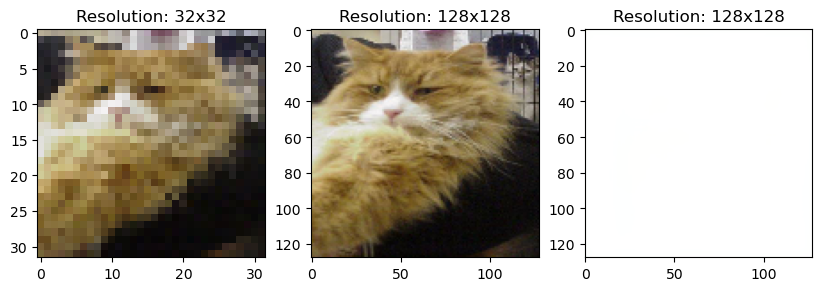

Epoch 12 Training:   0%|          | 0/233 [00:00<?, ?it/s]

3/3 [==============================] - 8s 2s/step


Epoch 12 Training:   0%|          | 1/233 [01:17<5:00:48, 77.80s/it]

3/3 [==============================] - 9s 2s/step


Epoch 12 Training:   1%|          | 2/233 [02:36<5:01:13, 78.24s/it]

3/3 [==============================] - 8s 2s/step


Epoch 12 Training:   1%|▏         | 3/233 [03:54<4:59:03, 78.01s/it]

3/3 [==============================] - 9s 2s/step


Epoch 12 Training:   2%|▏         | 4/233 [05:12<4:57:50, 78.04s/it]

3/3 [==============================] - 9s 2s/step


Epoch 12 Training:   2%|▏         | 5/233 [06:30<4:57:14, 78.22s/it]

3/3 [==============================] - 8s 2s/step


Epoch 12 Training:   3%|▎         | 6/233 [07:48<4:55:31, 78.11s/it]

3/3 [==============================] - 8s 2s/step


Epoch 12 Training:   3%|▎         | 7/233 [09:06<4:53:23, 77.89s/it]

3/3 [==============================] - 9s 2s/step


Epoch 12 Training:   3%|▎         | 8/233 [10:23<4:51:52, 77.83s/it]

3/3 [==============================] - 8s 2s/step


Epoch 12 Training:   4%|▍         | 9/233 [11:42<4:51:06, 77.98s/it]

3/3 [==============================] - 9s 2s/step


Epoch 12 Training:   4%|▍         | 10/233 [13:00<4:49:51, 77.99s/it]

3/3 [==============================] - 9s 2s/step


Epoch 12 Training:   5%|▍         | 11/233 [14:18<4:49:30, 78.24s/it]

3/3 [==============================] - 9s 2s/step


Epoch 12 Training:   5%|▌         | 12/233 [15:37<4:48:16, 78.26s/it]

3/3 [==============================] - 9s 2s/step


Epoch 12 Training:   6%|▌         | 13/233 [16:56<4:48:12, 78.60s/it]

3/3 [==============================] - 9s 3s/step


Epoch 12 Training:   6%|▌         | 14/233 [18:16<4:48:43, 79.10s/it]

3/3 [==============================] - 9s 2s/step


Epoch 12 Training:   6%|▋         | 15/233 [19:37<4:49:15, 79.61s/it]

3/3 [==============================] - 9s 2s/step


Epoch 12 Training:   7%|▋         | 16/233 [20:57<4:48:18, 79.72s/it]

3/3 [==============================] - 9s 3s/step


Epoch 12 Training:   7%|▋         | 17/233 [22:16<4:46:37, 79.62s/it]

3/3 [==============================] - 9s 3s/step


Epoch 12 Training:   8%|▊         | 18/233 [23:38<4:47:50, 80.33s/it]

3/3 [==============================] - 9s 2s/step


Epoch 12 Training:   8%|▊         | 19/233 [24:57<4:44:48, 79.85s/it]

3/3 [==============================] - 9s 2s/step


Epoch 12 Training:   9%|▊         | 20/233 [26:16<4:42:30, 79.58s/it]

3/3 [==============================] - 9s 2s/step


Epoch 12 Training:   9%|▉         | 21/233 [27:34<4:39:45, 79.18s/it]

3/3 [==============================] - 9s 2s/step


Epoch 12 Training:   9%|▉         | 22/233 [28:53<4:37:52, 79.01s/it]

3/3 [==============================] - 9s 2s/step


Epoch 12 Training:  10%|▉         | 23/233 [30:12<4:36:04, 78.88s/it]

3/3 [==============================] - 9s 2s/step


Epoch 12 Training:  10%|█         | 24/233 [31:30<4:34:24, 78.78s/it]

3/3 [==============================] - 9s 3s/step


Epoch 12 Training:  11%|█         | 25/233 [32:48<4:32:39, 78.65s/it]

3/3 [==============================] - 9s 2s/step


Epoch 12 Training:  11%|█         | 26/233 [34:07<4:30:48, 78.50s/it]

3/3 [==============================] - 9s 2s/step


Epoch 12 Training:  12%|█▏        | 27/233 [35:25<4:29:12, 78.41s/it]

3/3 [==============================] - 8s 2s/step


Epoch 12 Training:  12%|█▏        | 28/233 [36:43<4:27:42, 78.36s/it]

3/3 [==============================] - 9s 3s/step


Epoch 12 Training:  12%|█▏        | 29/233 [38:04<4:29:31, 79.27s/it]

3/3 [==============================] - 9s 3s/step


Epoch 12 Training:  13%|█▎        | 30/233 [39:24<4:28:37, 79.40s/it]

3/3 [==============================] - 8s 2s/step


Epoch 12 Training:  13%|█▎        | 31/233 [40:42<4:25:51, 78.97s/it]

3/3 [==============================] - 8s 2s/step


Epoch 12 Training:  14%|█▎        | 32/233 [42:00<4:23:40, 78.71s/it]

3/3 [==============================] - 9s 2s/step


Epoch 12 Training:  14%|█▍        | 33/233 [43:22<4:25:05, 79.53s/it]

3/3 [==============================] - 9s 3s/step


Epoch 12 Training:  15%|█▍        | 34/233 [44:44<4:26:10, 80.25s/it]

3/3 [==============================] - 9s 3s/step


Epoch 12 Training:  15%|█▌        | 35/233 [46:04<4:25:24, 80.43s/it]

3/3 [==============================] - 9s 3s/step


Epoch 12 Training:  15%|█▌        | 36/233 [47:25<4:24:35, 80.59s/it]

3/3 [==============================] - 9s 2s/step


Epoch 12 Training:  16%|█▌        | 37/233 [48:44<4:21:43, 80.12s/it]

3/3 [==============================] - 9s 2s/step


Epoch 12 Training:  16%|█▋        | 38/233 [50:03<4:18:40, 79.59s/it]

3/3 [==============================] - 9s 3s/step


Epoch 12 Training:  17%|█▋        | 39/233 [51:26<4:21:18, 80.81s/it]

3/3 [==============================] - 9s 3s/step


Epoch 12 Training:  17%|█▋        | 40/233 [52:48<4:20:36, 81.02s/it]

3/3 [==============================] - 9s 3s/step


Epoch 12 Training:  18%|█▊        | 41/233 [54:12<4:22:00, 81.88s/it]

3/3 [==============================] - 9s 2s/step


Epoch 12 Training:  18%|█▊        | 42/233 [55:33<4:19:38, 81.56s/it]

3/3 [==============================] - 9s 3s/step


Epoch 12 Training:  18%|█▊        | 43/233 [56:54<4:17:47, 81.41s/it]

3/3 [==============================] - 9s 3s/step


Epoch 12 Training:  19%|█▉        | 44/233 [58:14<4:15:04, 80.98s/it]

3/3 [==============================] - 9s 3s/step


Epoch 12 Training:  19%|█▉        | 45/233 [59:35<4:14:22, 81.19s/it]

3/3 [==============================] - 9s 3s/step


Epoch 12 Training:  20%|█▉        | 46/233 [1:00:58<4:14:13, 81.57s/it]

3/3 [==============================] - 9s 3s/step


Epoch 12 Training:  20%|██        | 47/233 [1:02:20<4:13:28, 81.77s/it]

3/3 [==============================] - 9s 2s/step


Epoch 12 Training:  21%|██        | 48/233 [1:03:43<4:12:48, 81.99s/it]

3/3 [==============================] - 9s 3s/step


Epoch 12 Training:  21%|██        | 49/233 [1:05:04<4:11:12, 81.91s/it]

3/3 [==============================] - 9s 2s/step


Epoch 12 Training:  21%|██▏       | 50/233 [1:06:26<4:09:21, 81.76s/it]

3/3 [==============================] - 9s 3s/step


Epoch 12 Training:  22%|██▏       | 51/233 [1:07:47<4:07:29, 81.59s/it]

3/3 [==============================] - 9s 2s/step


In [ ]:
#train(generator, discriminator, train_gen, test_gen, gen_loss_fn, dis_loss_fn, optimizer, optimizer, epochs)
#train(epochs, batch_size, output_dir, model_save_dir, generator, discriminator, train_gen, test_gen, gen_loss_fn, dis_loss_fn)
train(epochs, batch_size, output_dir, model_save_dir, generator, discriminator, train_gen, test_gen, gen_optimizer, disc_optimizer, gen_loss_fn, dis_loss_fn)

